In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
# from base import *
from joblib import Parallel, delayed
import random
import scipy

In [3]:
import matplotlib.pyplot as plt

from matplotlib import colors
import matplotlib
import six
import matplotlib.dates as mdates
import datetime
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('seaborn-poster')
from sklearn.metrics import r2_score

In [4]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [5]:
from MNMAPI import *
from MNM_mcnb import *
from mcDODE import *

In [6]:
data_folder = os.path.join('/home/lemma/Documents/MAC-POSTS/data/input_files_7link_multiclass_new')

In [7]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)

In [8]:
# nb.dump_to_folder('test')

In [30]:
observed_link_list = [3, 4, 5, 6]
ml_car = 6
ml_truck = 4
data_dict = dict()
num_interval = nb.config.config_dict['DTA']['max_interval']
true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 100
true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 10
# true_car_x = np.random.rand(num_interval * len(observed_link_list)) * 100
# true_truck_x = np.random.rand(num_interval * len(observed_link_list)) * 10
# L_car_one = np.random.randint(2, size = (ml_car, len(observed_link_list)))
L_car_one = np.array([[1, 0, 0, 1],
                      [0, 0, 1, 1],
                      [1, 1, 0, 1],
                      [1, 0, 1, 1],
                      [1, 0, 0, 0],
                      [0, 1, 0, 0]])
L_truck_one = np.array([[1, 0, 1, 1],
                        [0, 0, 0, 1],
                        [1, 1, 0, 1],
                        [1, 0, 0, 0]])
# L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

config = dict()
config['use_car_link_flow'] = True
config['use_truck_link_flow'] = True
config['use_car_link_tt'] = True
config['use_truck_link_tt'] = True
config['car_count_agg'] = True
config['truck_count_agg'] = True
config['link_car_flow_weight'] = 1
config['link_truck_flow_weight'] = 1
config['link_car_tt_weight'] = 1
config['link_truck_tt_weight'] = 1
config['num_data'] = 8
config['observed_links'] = observed_link_list
config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


dode = MCDODE(nb, config)
dta = dode._run_simulation(true_car_f, true_truck_f)


noise_level = 0.1
# (true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
# true_car_x = true_dar_car.dot(true_car_f)
# true_truck_x = true_dar_truck.dot(true_truck_f)
data_dict['car_count_agg_L_list'] = list()
data_dict['truck_count_agg_L_list'] = list()
data_dict['car_link_flow'] = []
data_dict['truck_link_flow'] = []
data_dict['car_link_tt'] = []
data_dict['truck_link_tt'] = []
for i in range(config['num_data']):
    true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_car_tt = dta.get_car_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    true_truck_tt = dta.get_truck_link_tt(np.arange(0, dode.num_loading_interval, dode.ass_freq)).flatten(order = 'F')
    m_car = L_car.dot(true_car_x)
    m_truck = L_truck.dot(true_truck_x)
    data_dict['car_count_agg_L_list'].append(L_car)
    data_dict['truck_count_agg_L_list'].append(L_truck)
    data_dict['car_link_flow'].append(m_car + np.random.uniform(-1, 1, m_car.shape) * noise_level * m_car)
    data_dict['truck_link_flow'].append(m_truck + np.random.uniform(-1, 1, m_truck.shape) * noise_level * m_truck)
    data_dict['car_link_tt'].append(true_car_tt + np.random.uniform(-1, 1, true_car_tt.shape) * noise_level * true_car_tt)
    data_dict['truck_link_tt'].append(true_truck_tt + np.random.uniform(-1, 1, true_truck_tt.shape) * noise_level * true_truck_tt)

In [31]:
dode.paths_list

[0, 1, 2]

In [32]:
true_truck_tt

array([15.84, 15.84, 15.84, 15.84, 37.  , 13.  , 13.  , 18.  , 24.  ,
       14.  , 18.  , 19.  , 24.  , 21.  , 15.  , 33.  , 26.  , 28.  ,
       15.  , 15.  , 58.  , 18.  , 18.  , 17.  , 17.  , 22.  , 14.  ,
       20.  , 19.  , 26.  , 18.  , 16.  , 20.  , 16.  , 14.  , 14.  ,
       19.  , 16.  , 16.  , 20.  ])

In [33]:
true_truck_x

array([ 7.7,  2.3, 11.9,  5.1,  3.2,  5.8, 10.8,  7.5,  2.4,  5.5,  6.3,
        3.3,  3.1,  2.1,  9.2,  6.6,  1. ,  7.9,  6.7,  5.4,  5.9,  2.9,
       14.5,  9. ,  7.5,  3.4, 10.1,  2.3,  6.8,  4.1, 15. ,  8.9,  7.4,
        6.2, 11.9,  4.2,  3.6,  3.9,  6.2,  2.2])

In [34]:
true_car_x

array([ 42.8,  20.2,  80.5,  40.4,  25.9,  56.9,  81.7,  56.7,  48.1,
        94. ,  93.8,  47. ,  50.9,  36.6, 147. ,  97.9,  16.6, 124.8,
       111.6,  93.4,  55.9,  30.6, 135.5,  81.3,  74.7,  30.6,  97.2,
        19.9,  16.3,  16.7,  42.7,  23.5,  61.3,  39.5,  91.6,  33.3,
        74. ,  61.8, 125.2,  52.5])

In [35]:
m_truck

array([24.7,  5.1, 15.1,  7.7, 21.5,  7.5, 16.5,  3.2, 12. ,  3.3, 11.2,
        2.4, 18.9,  6.6, 11.8,  3.1, 13.1,  5.4, 14.3,  1. , 29.4,  9. ,
       17.8,  5.9, 19.9,  2.3, 13.2,  7.5, 30.7,  8.9, 19.8,  6.8, 23.5,
        4.2, 17.8,  7.4, 12. ,  2.2,  9.7,  3.6])

In [36]:
dode = MCDODE(nb, config)

In [37]:
dode.add_data(data_dict)

In [38]:
# (car_flow, truck_flow) = dode.init_path_flow(car_scale = 10, truck_scale = 1)

In [39]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 50, step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)

Epoch: 0 Loss: 1202.006222478193 {'truck_count_loss': 84.2350858992481, 'car_tt_loss': 36.56288147507133, 'car_count_loss': 1021.4957608802763, 'truck_tt_loss': 59.71249422359748}
Epoch: 1 Loss: 1229.68165470112 {'truck_count_loss': 79.4462155030146, 'car_tt_loss': 36.56323103973321, 'car_count_loss': 1014.7730534076809, 'truck_tt_loss': 98.89915475069137}
Epoch: 2 Loss: 1268.2239016617023 {'truck_count_loss': 74.86215995473717, 'car_tt_loss': 36.56288147507132, 'car_count_loss': 1006.4089336679332, 'truck_tt_loss': 150.38992656396056}
Epoch: 3 Loss: 1209.4069582852544 {'truck_count_loss': 69.18131539782968, 'car_tt_loss': 36.56288147507133, 'car_count_loss': 997.7759206691885, 'truck_tt_loss': 105.88684074316494}
Epoch: 4 Loss: 1188.7606111196644 {'truck_count_loss': 63.16267998838182, 'car_tt_loss': 36.56288147507133, 'car_count_loss': 990.3547623930631, 'truck_tt_loss': 98.68028726314819}
Epoch: 5 Loss: 1150.5259800110698 {'truck_count_loss': 56.973826729409396, 'car_tt_loss': 36.56

Epoch: 45 Loss: 1352.6653756415726 {'truck_count_loss': 42.061371228519974, 'car_tt_loss': 191.32336175192248, 'car_count_loss': 795.5404459243011, 'truck_tt_loss': 323.7401967368292}
Epoch: 46 Loss: 1279.8391924221073 {'truck_count_loss': 42.552853490866084, 'car_tt_loss': 154.95918411418089, 'car_count_loss': 796.4390135079506, 'truck_tt_loss': 285.8881413091098}
Epoch: 47 Loss: 1351.0678449300128 {'truck_count_loss': 43.94204932239187, 'car_tt_loss': 182.6097346564258, 'car_count_loss': 798.2752706146041, 'truck_tt_loss': 326.24079033659115}
Epoch: 48 Loss: 1373.404778452759 {'truck_count_loss': 44.63563725317508, 'car_tt_loss': 228.65687170392042, 'car_count_loss': 797.2785612474129, 'truck_tt_loss': 302.83370824825084}
Epoch: 49 Loss: 1378.0915068524403 {'truck_count_loss': 45.34257718770672, 'car_tt_loss': 211.68081254027106, 'car_count_loss': 798.9097377602029, 'truck_tt_loss': 322.1583793642593}


In [41]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow_mp(max_epoch = 100, step_size = 0.1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, 
                                                          adagrad = True, n_process = 8)

Epoch: 0 Loss: 1200.5944729205526
Epoch: 1 Loss: 1198.6296269490088
Epoch: 2 Loss: 1180.0207314362003
Epoch: 3 Loss: 1577.2288810519
Epoch: 4 Loss: 1339.9878569629661
Epoch: 5 Loss: 1207.8710191380205
Epoch: 6 Loss: 1308.8282832389648
Epoch: 7 Loss: 1120.4968385711088
Epoch: 8 Loss: 1144.4383211545753
Epoch: 9 Loss: 1089.418489285183
Epoch: 10 Loss: 1076.512659258612
Epoch: 11 Loss: 1068.0448219704167
Epoch: 12 Loss: 1049.2258124543093
Epoch: 13 Loss: 1032.106960243377
Epoch: 14 Loss: 1024.643537862552
Epoch: 15 Loss: 1008.7314432274068
Epoch: 16 Loss: 1013.1424925091036
Epoch: 17 Loss: 1000.8964843407588
Epoch: 18 Loss: 1042.515748840217
Epoch: 19 Loss: 980.6005573929566
Epoch: 20 Loss: 1098.3220743762952
Epoch: 21 Loss: 999.7427564345701
Epoch: 22 Loss: 1110.1608944285383
Epoch: 23 Loss: 972.1874710950614
Epoch: 24 Loss: 950.9433061871678
Epoch: 25 Loss: 945.5524691656709
Epoch: 26 Loss: 950.3519543619524
Epoch: 27 Loss: 968.4622297668235
Epoch: 28 Loss: 941.1274827899456
Epoch: 29 L

In [112]:
(car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 150, step_size = 1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)

Epoch: 0 Loss: 1354.597279727744 1532764312.65
Epoch: 1 Loss: 1329.1729161518333 1532764312.71
Epoch: 2 Loss: 1299.4582383453023 1532764312.78
Epoch: 3 Loss: 1267.333604429961 1532764312.85
Epoch: 4 Loss: 1242.5742174918698 1532764312.93
Epoch: 5 Loss: 1210.584764398143 1532764313.02
Epoch: 6 Loss: 1179.8583446305383 1532764313.11
Epoch: 7 Loss: 1154.8944839023843 1532764313.2
Epoch: 8 Loss: 1128.576423709497 1532764313.3
Epoch: 9 Loss: 1109.4344479013805 1532764313.4
Epoch: 10 Loss: 1085.342841663516 1532764313.5
Epoch: 11 Loss: 1063.1277737808439 1532764313.61
Epoch: 12 Loss: 1043.786434522364 1532764313.72
Epoch: 13 Loss: 1028.8688138925095 1532764313.83
Epoch: 14 Loss: 1010.5673199741223 1532764313.94
Epoch: 15 Loss: 988.8346512196996 1532764314.05
Epoch: 16 Loss: 970.9579846762874 1532764314.17
Epoch: 17 Loss: 950.6894227666525 1532764314.29
Epoch: 18 Loss: 934.5791488373625 1532764314.42
Epoch: 19 Loss: 914.0801134703971 1532764314.54
Epoch: 20 Loss: 896.0419147378403 1532764314.

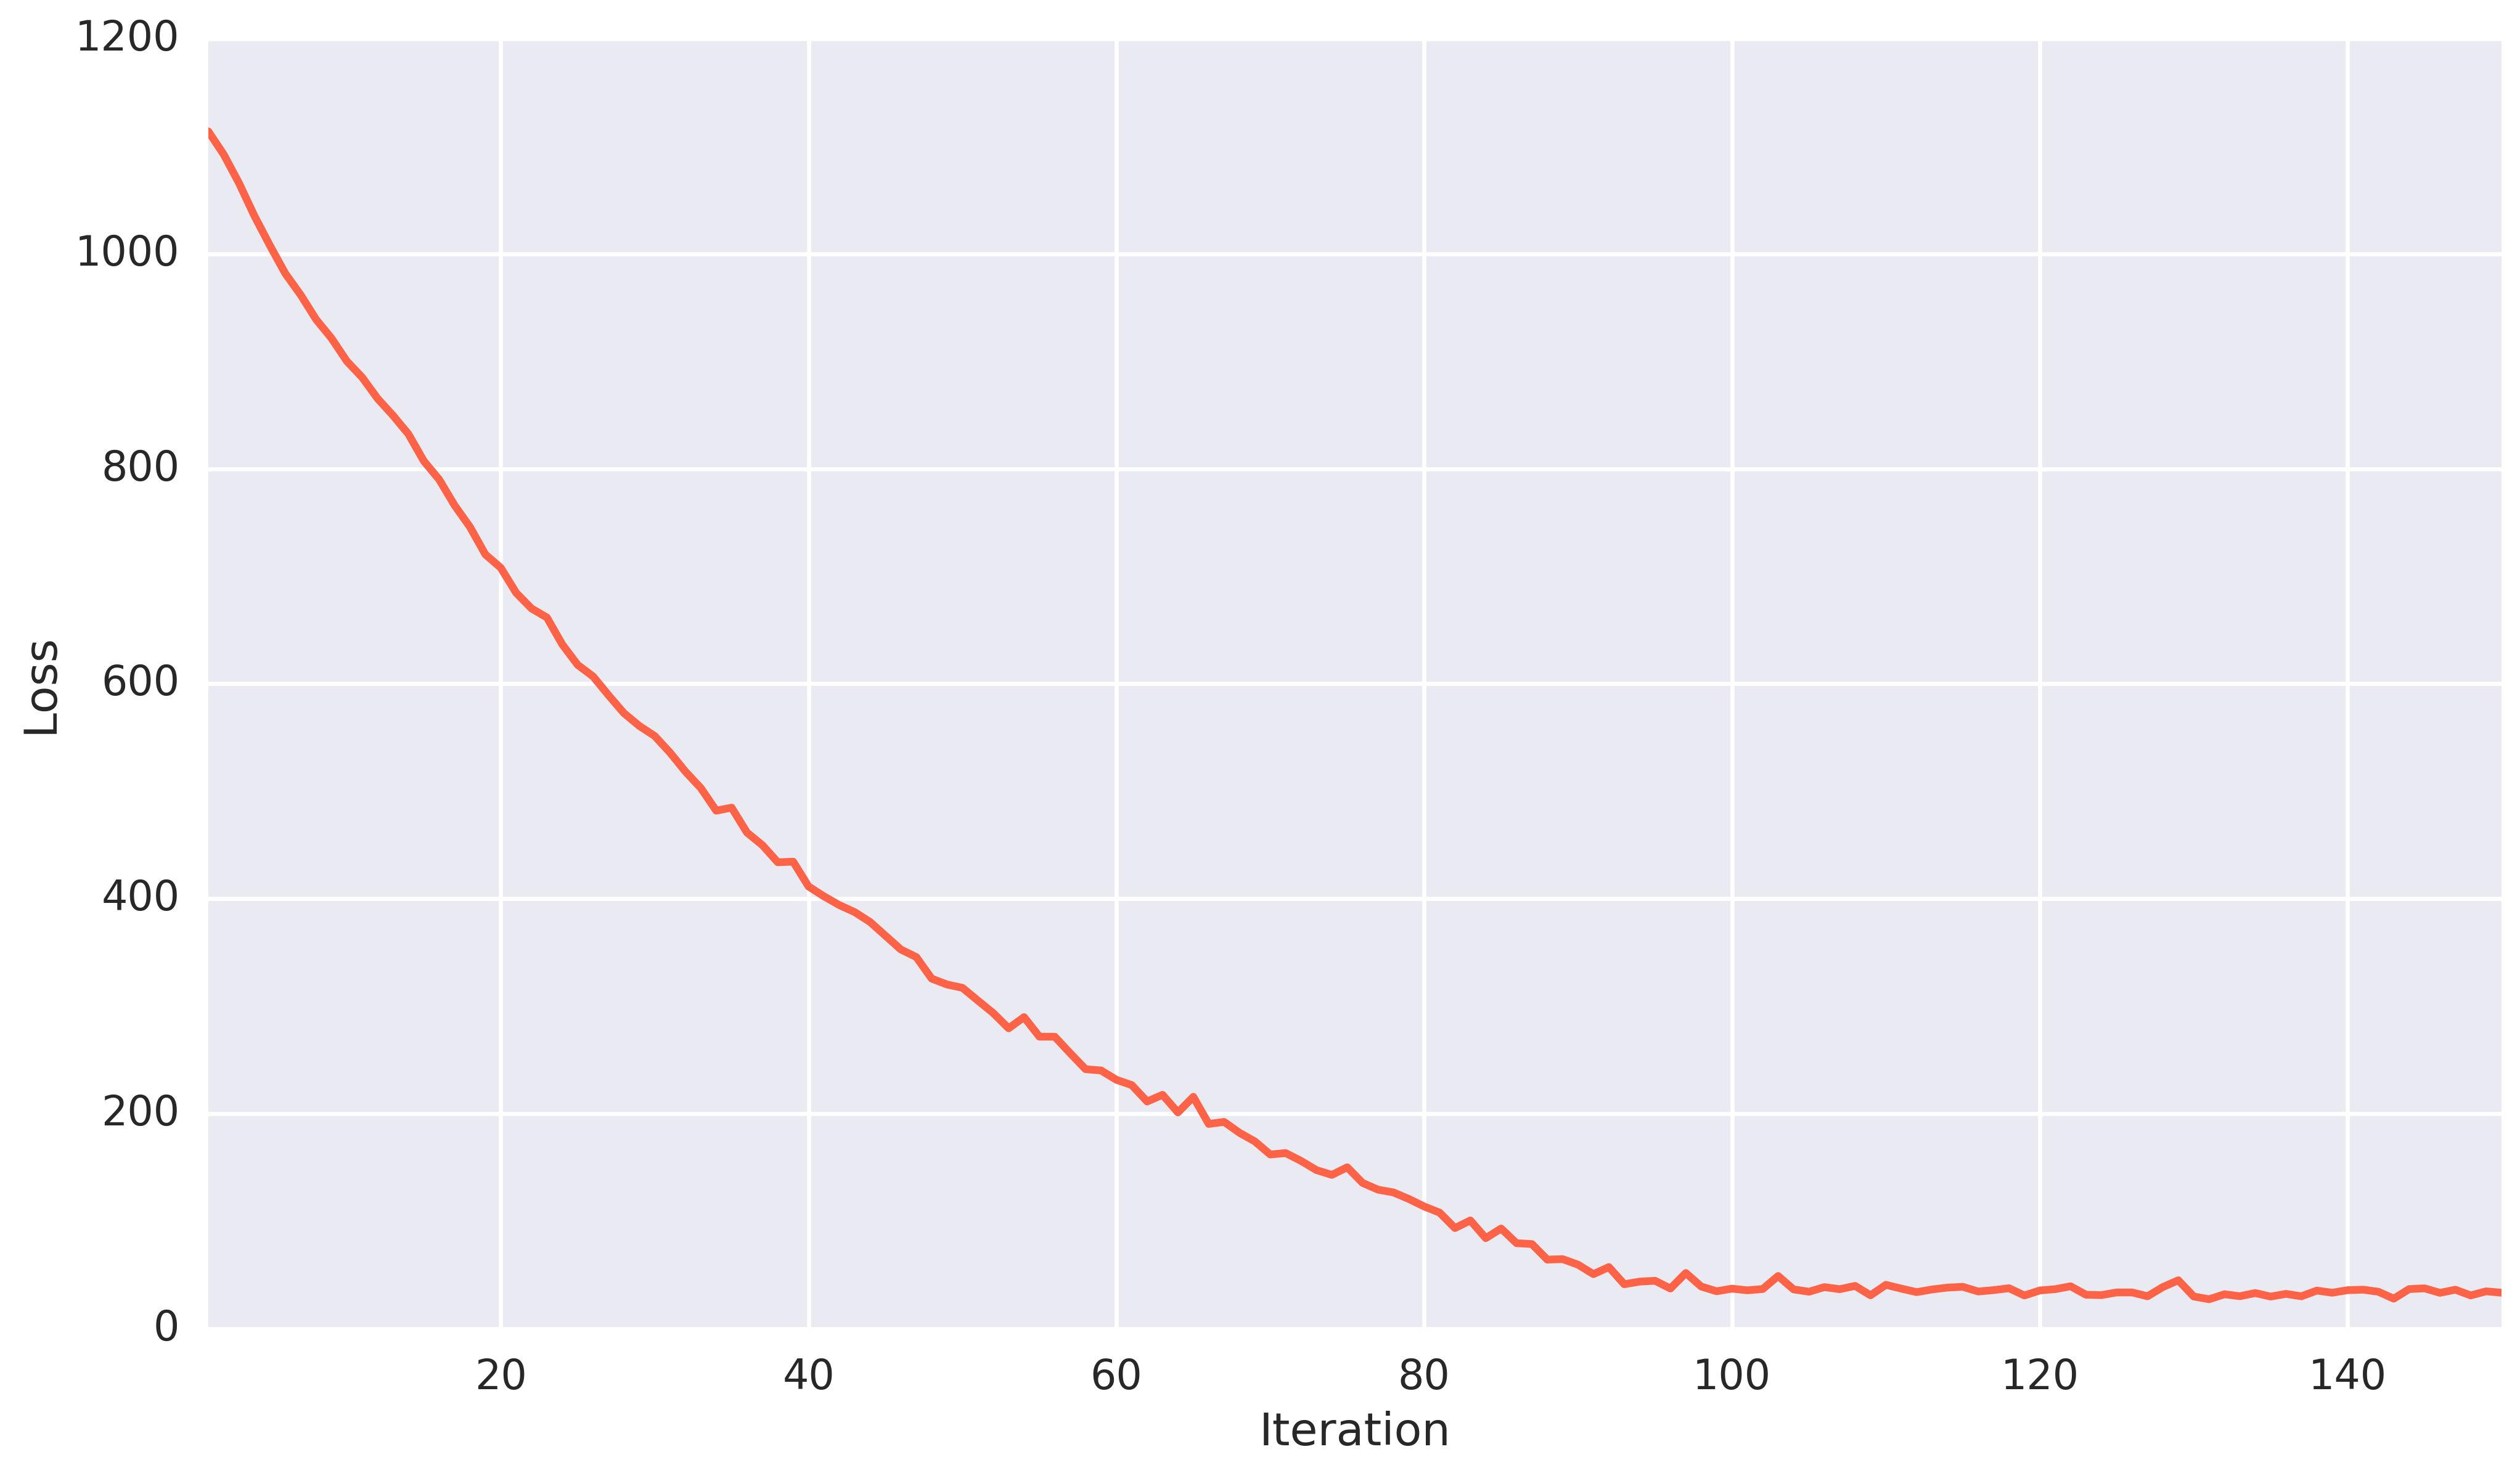

In [238]:
plt.figure(figsize = (16,9), dpi=300)
plt.plot(range(1,151), l_list, color = 'tomato', linewidth = 3)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.xlim([1, 150])
plt.show()

In [113]:
dta = dode._run_simulation(car_flow, truck_flow)
estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
              np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')

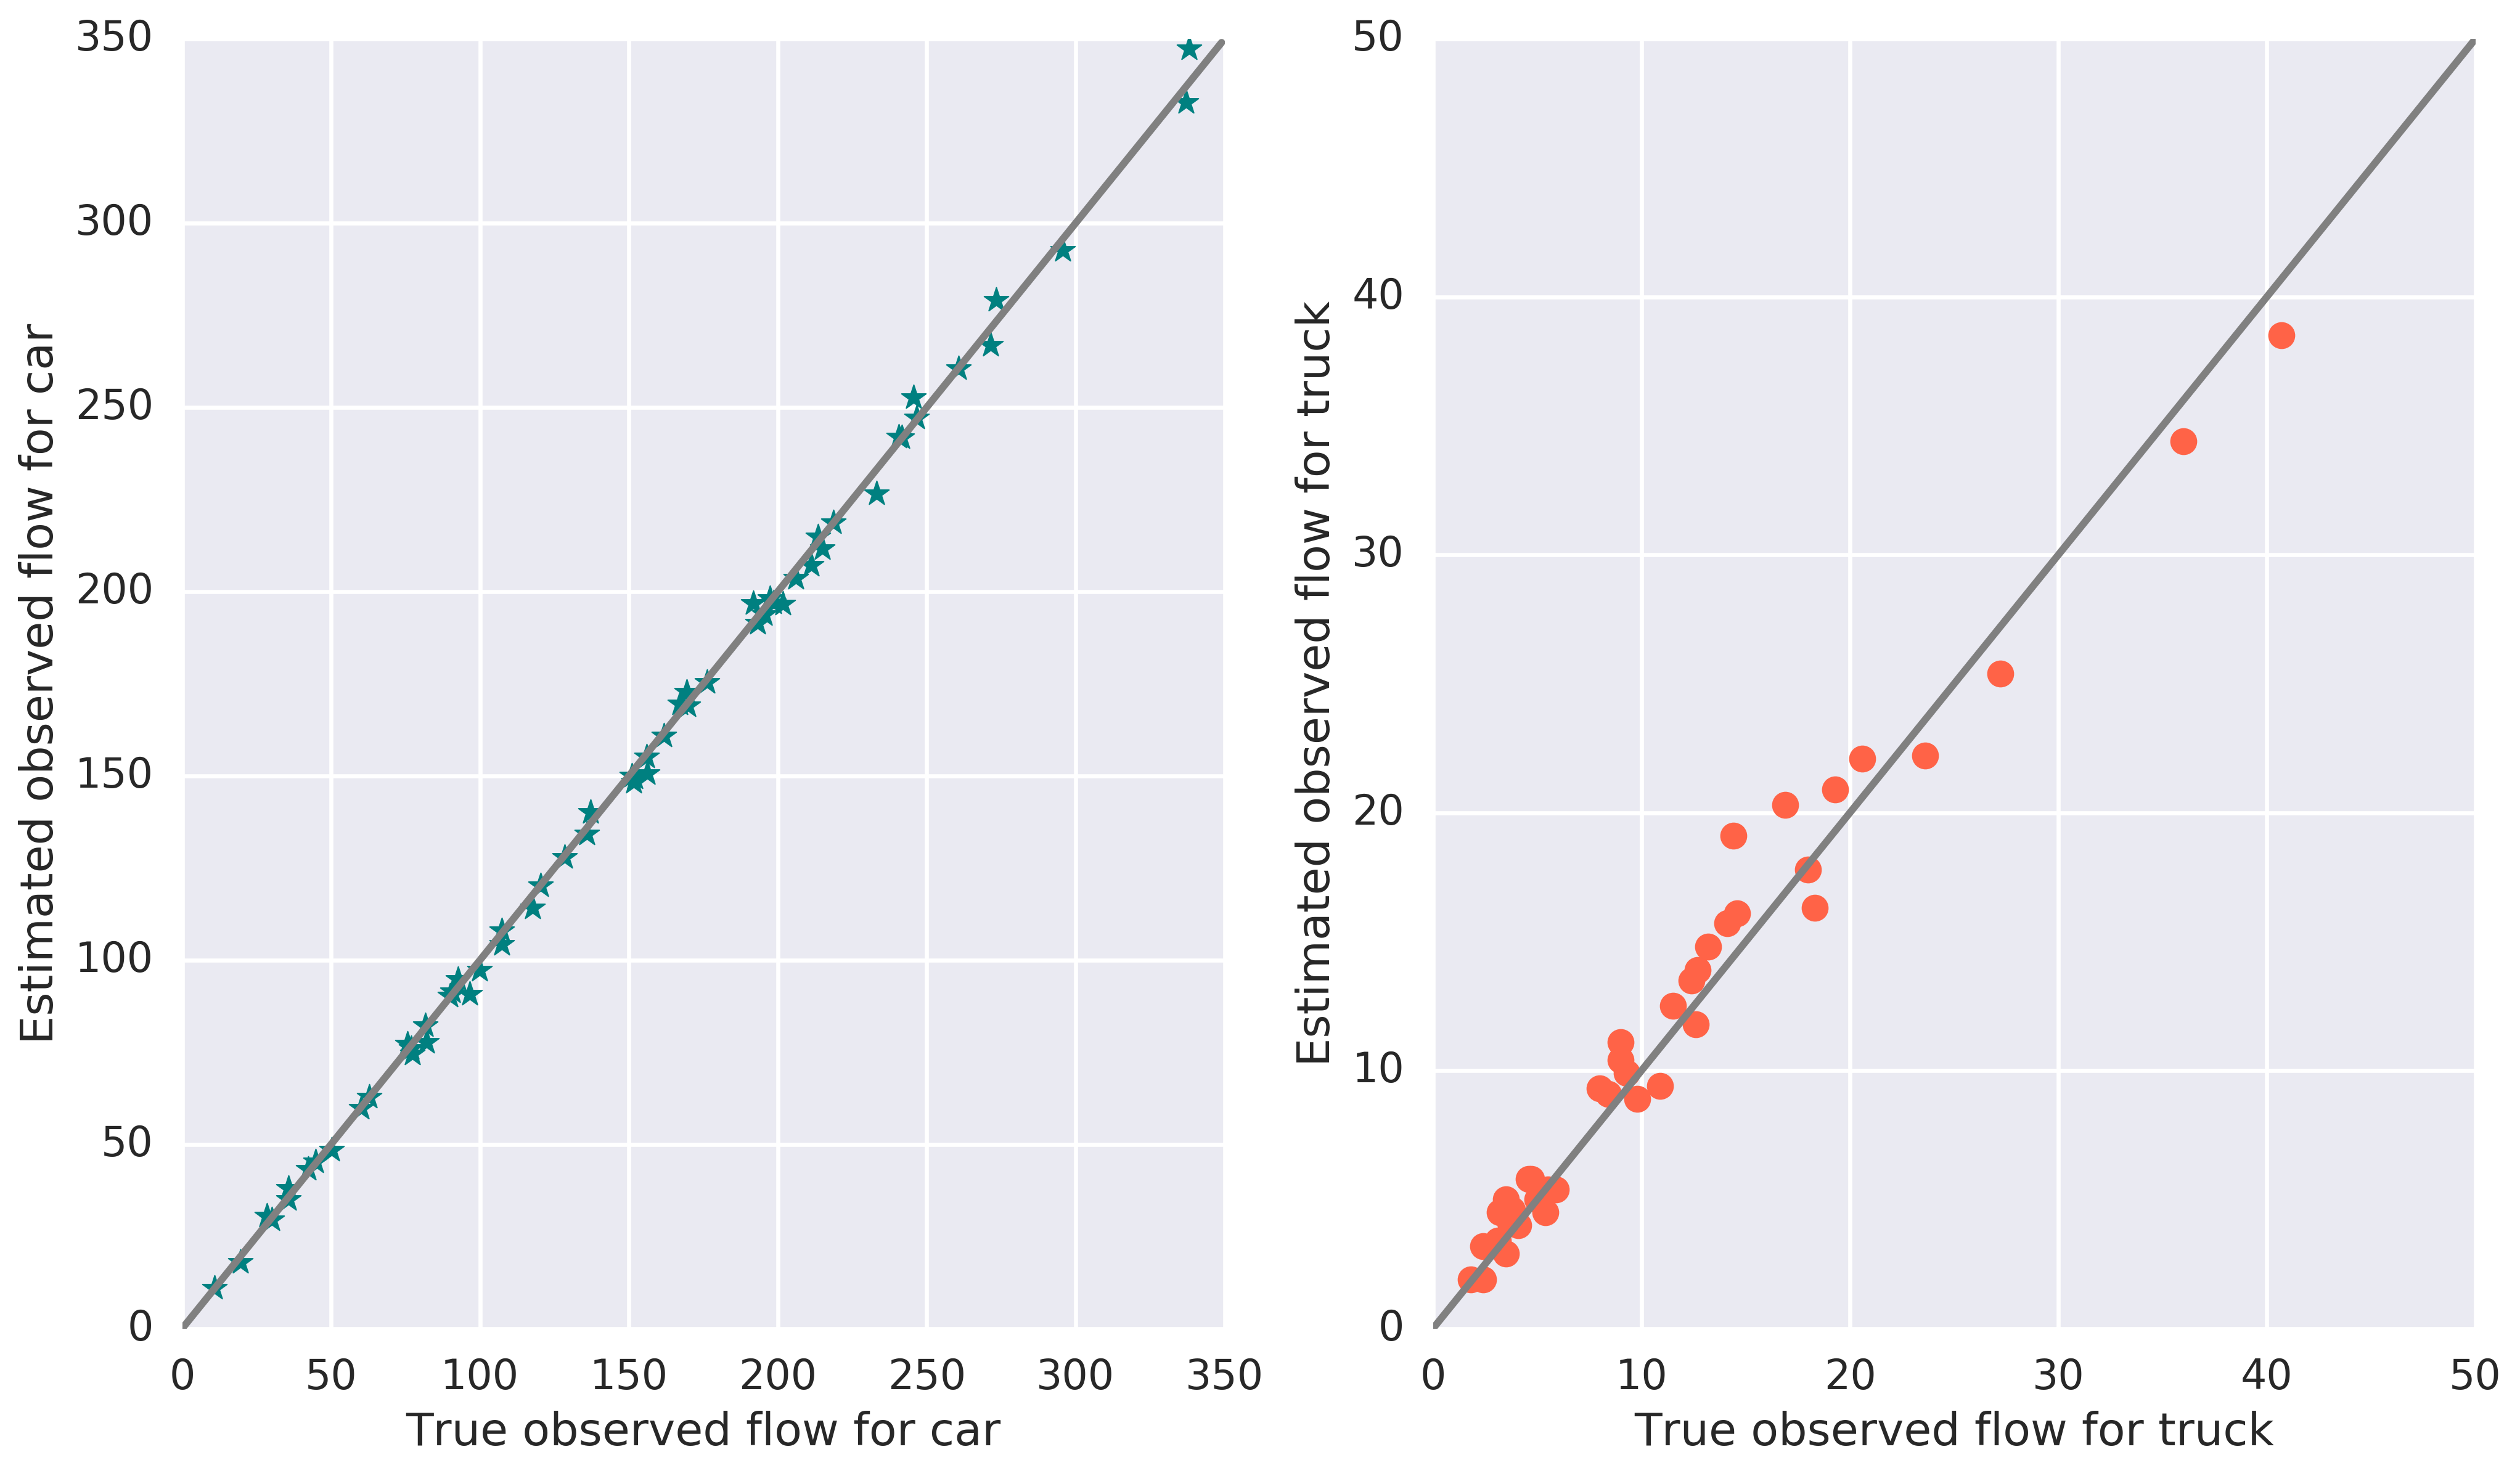

In [121]:

fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(m_car, L_car.dot(estimated_car_x), label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(m_truck, L_truck.dot(estimated_truck_x), label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated observed flow for car')
axes[0].set_xlabel('True observed flow for car')
axes[1].set_ylabel('Estimated observed flow for truck')
axes[1].set_xlabel('True observed flow for truck')
axes[0].set_xlim([0, 350])
axes[0].set_ylim([0, 350])
axes[1].set_xlim([0, 50])
axes[1].set_ylim([0, 50])
plt.show()

In [115]:
e_m_truck =L_truck.dot(estimated_truck_x)
print r2_score(m_car, L_car.dot(estimated_car_x))
print r2_score(m_truck[e_m_truck < 50], e_m_truck[e_m_truck < 50])

0.9985990689888352
0.9716385859040566


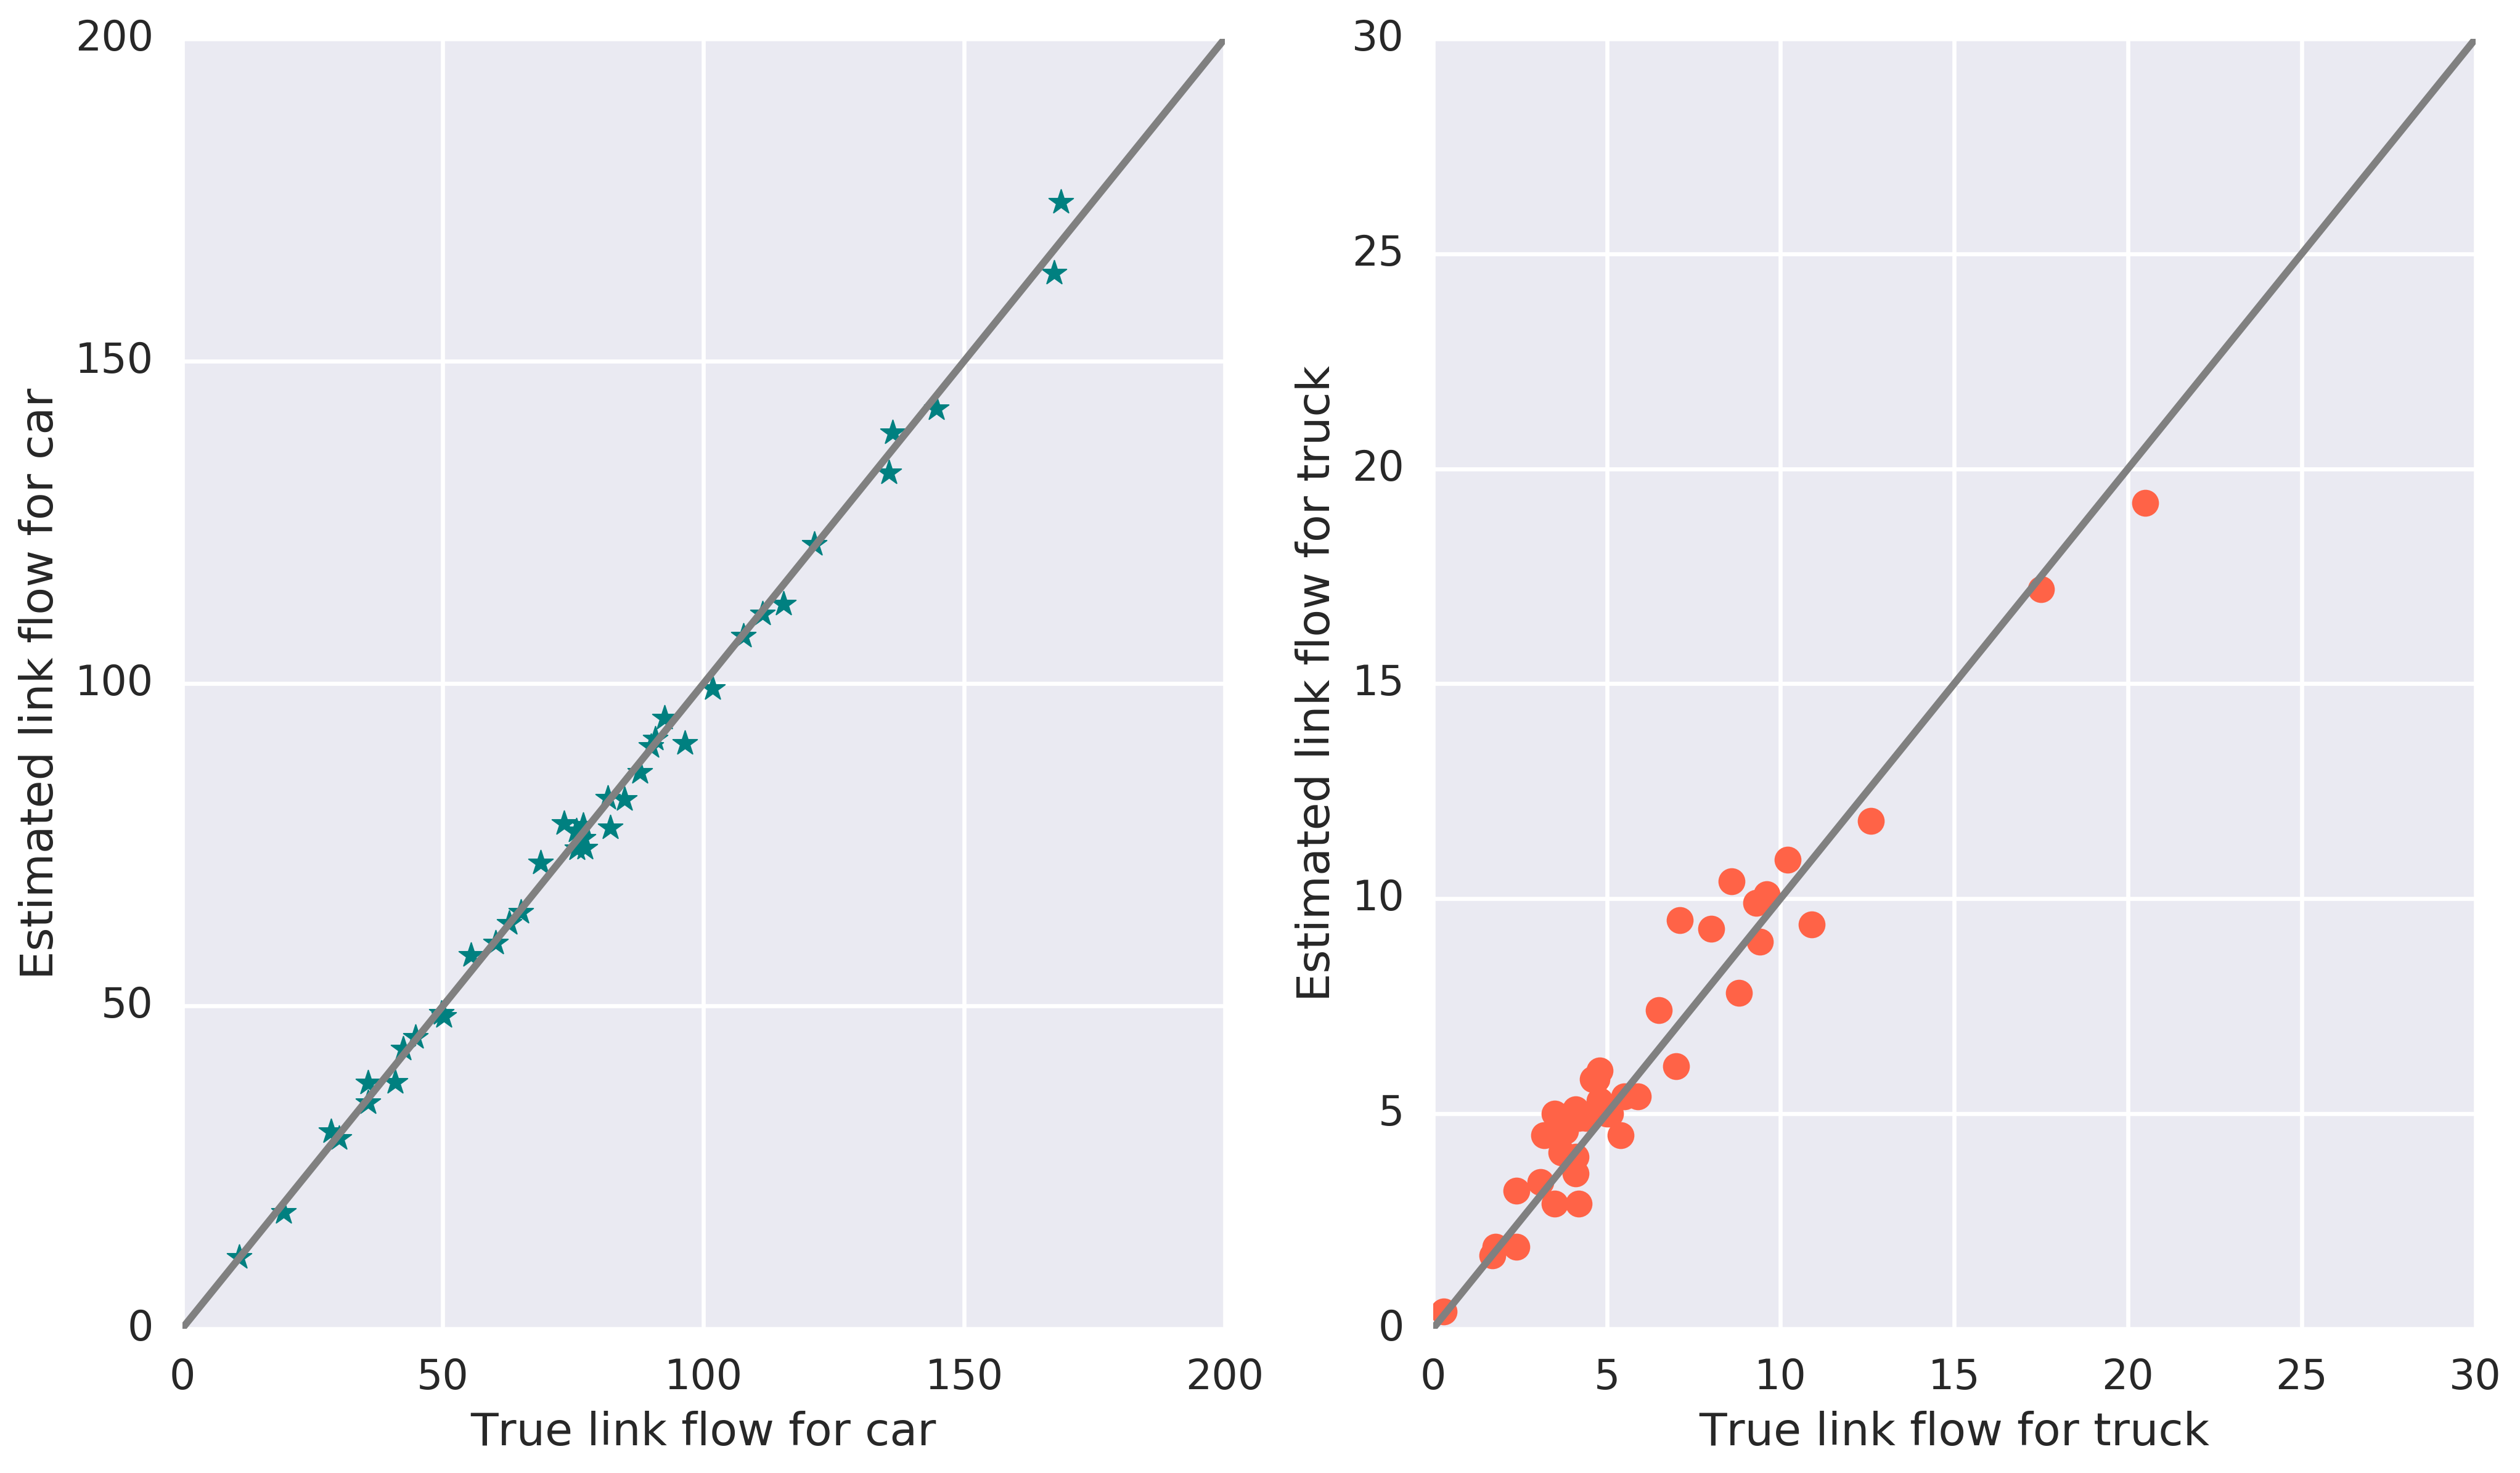

In [116]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(true_car_x, estimated_car_x, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(true_truck_x, estimated_truck_x, label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated link flow for car')
axes[0].set_xlabel('True link flow for car')
axes[1].set_ylabel('Estimated link flow for truck')
axes[1].set_xlabel('True link flow for truck')
axes[0].set_xlim([0, 200])
axes[0].set_ylim([0, 200])
axes[1].set_xlim([0, 30])
axes[1].set_ylim([0, 30])
plt.show()

In [117]:
print r2_score(true_car_x, estimated_car_x)
print r2_score(true_truck_x[estimated_truck_x<30], estimated_truck_x[estimated_truck_x<30])

0.9959004943084437
0.9466253716954103


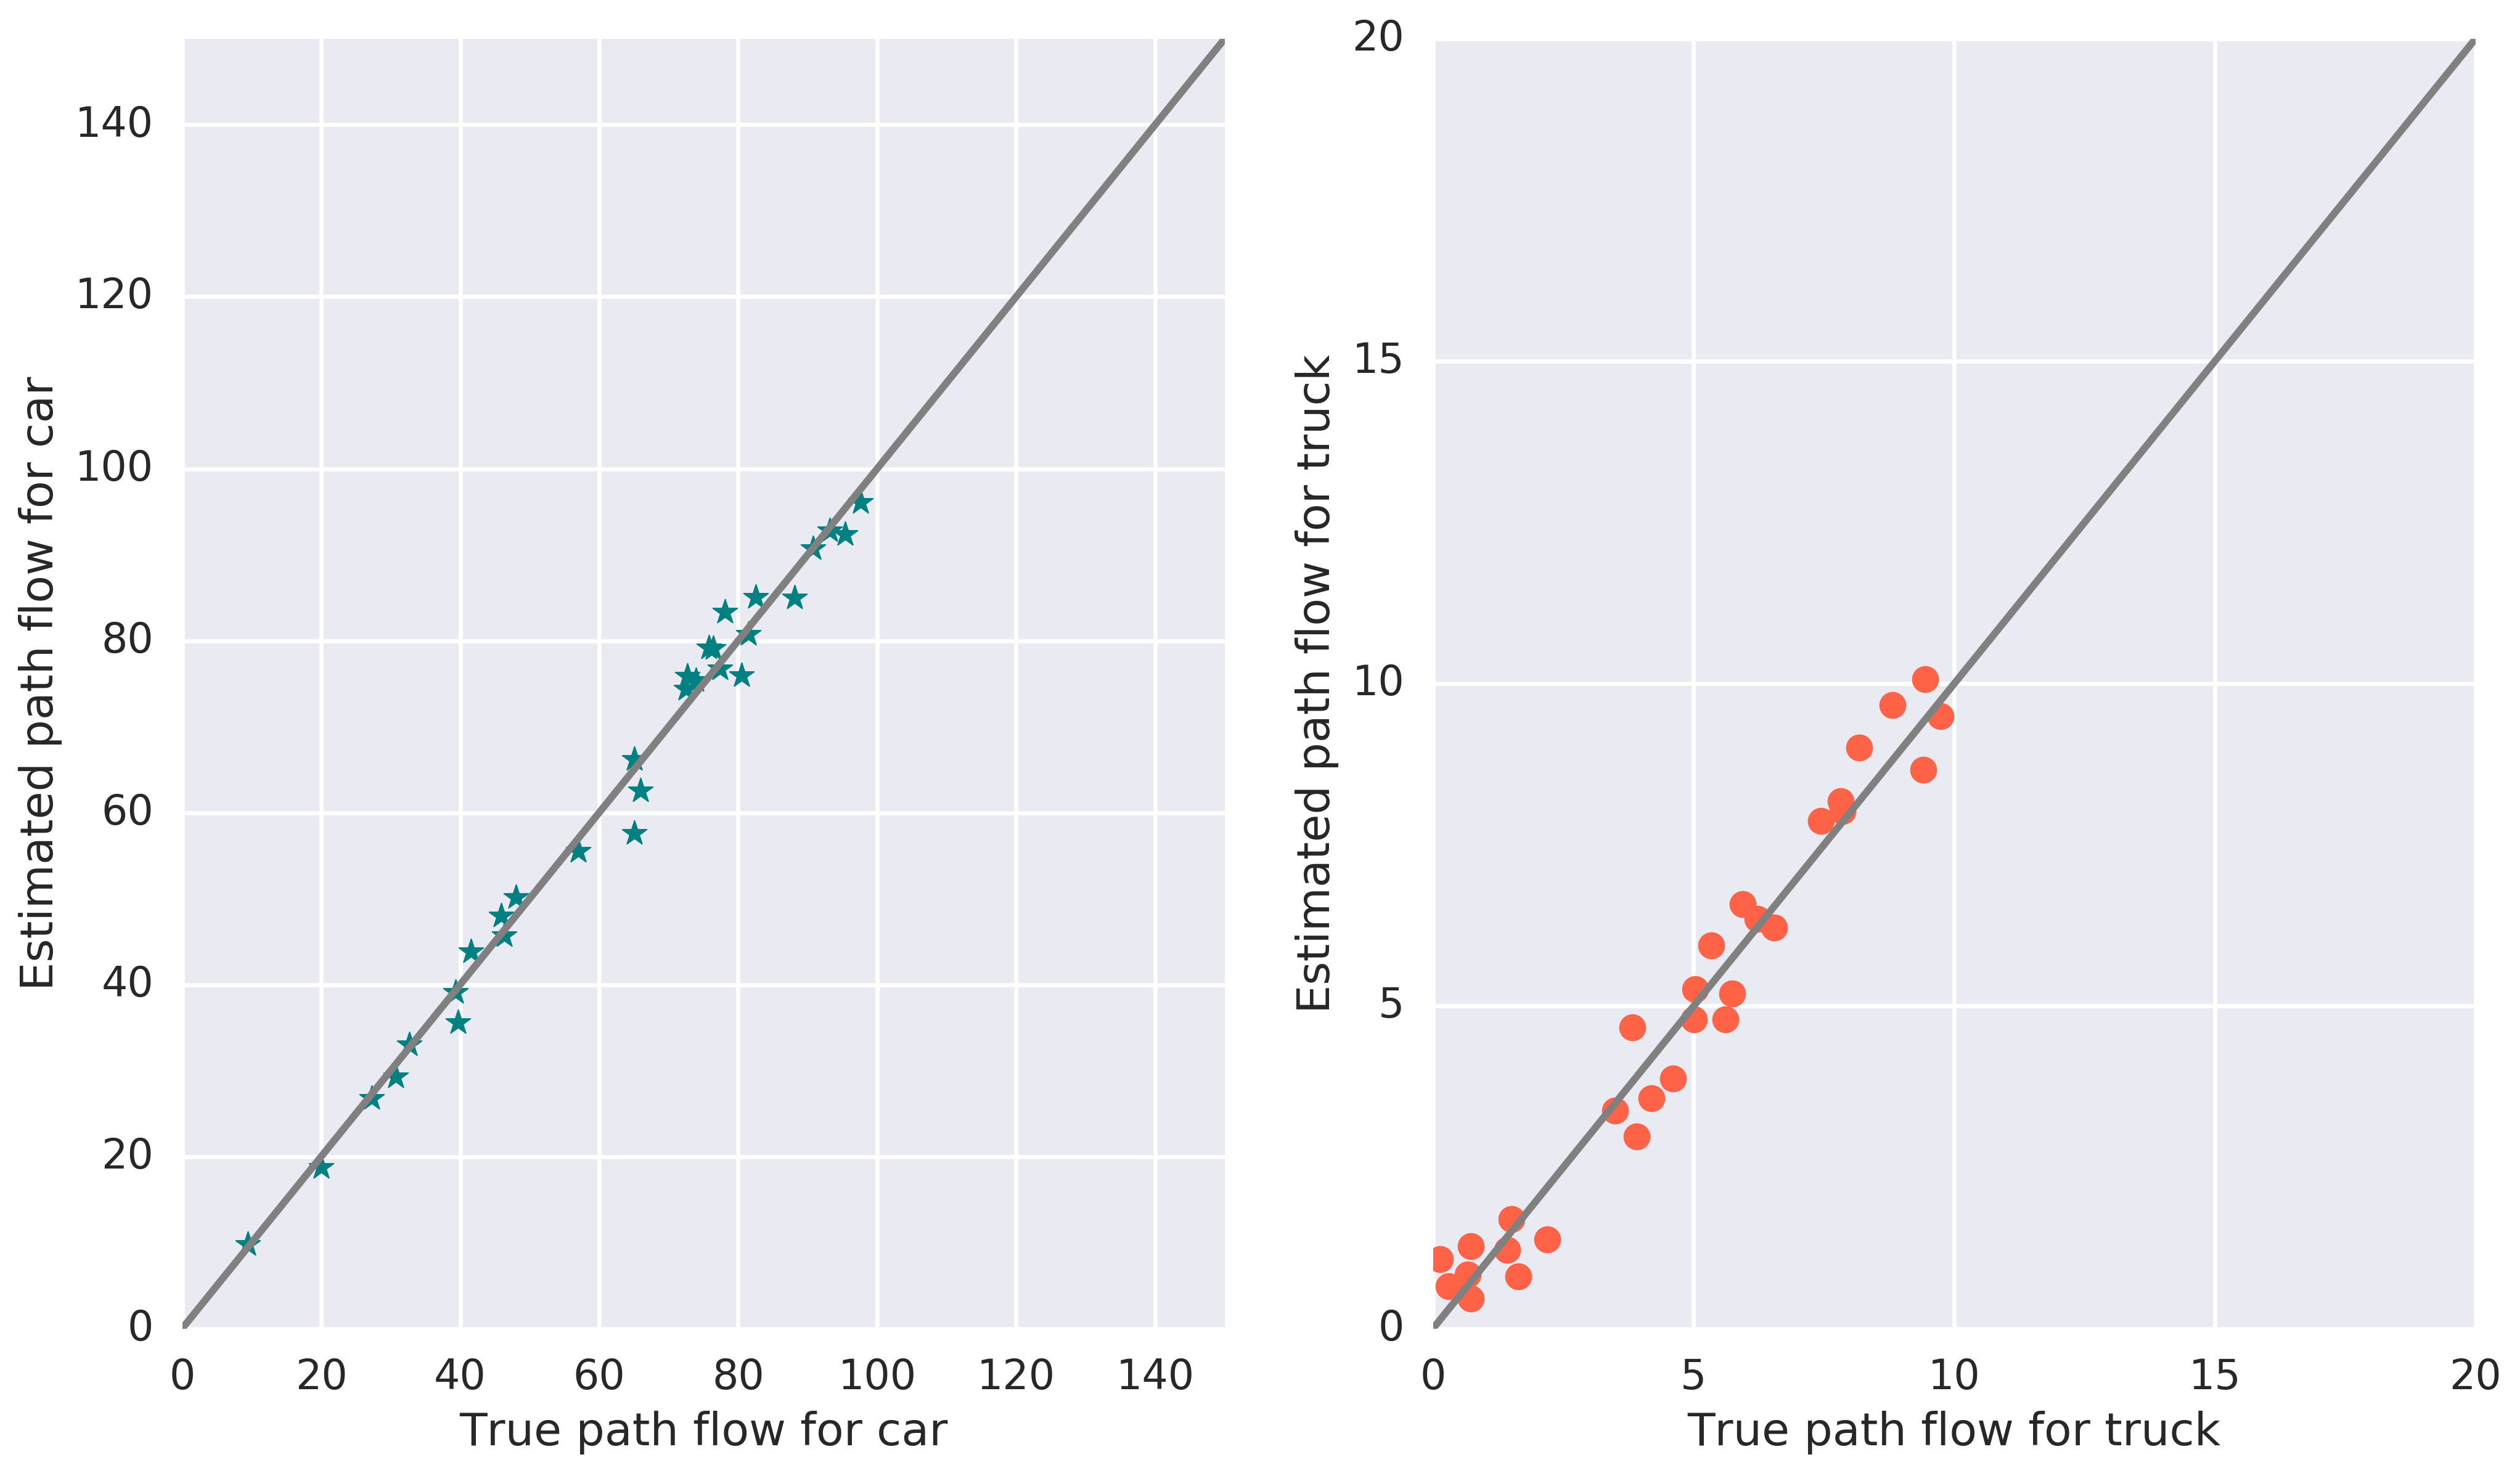

In [120]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
truck_flow = true_truck_f + np.random.rand(len(true_car_f)) * 2- 1
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(true_car_f, car_flow, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(true_truck_f, truck_flow, label = "Proposed closed-form method", color = 'tomato', 
                marker = "o", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated path flow for car')
axes[0].set_xlabel('True path flow for car')
axes[1].set_ylabel('Estimated path flow for truck')
axes[1].set_xlabel('True path flow for truck')
axes[0].set_xlim([0, 150])
axes[0].set_ylim([0, 150])
axes[1].set_xlim([0, 20])
axes[1].set_ylim([0, 20])
plt.show()

In [119]:
print r2_score(true_car_f[car_flow<140], car_flow[car_flow<140])
print r2_score(true_truck_f[truck_flow<15], truck_flow[truck_flow<15])

0.9872693215740989
0.9680718318021317


## Compare algorithm

In [123]:
(car_flow, truck_flow, l_list1) = dode.estimate_path_flow(max_epoch = 150, step_size = 0.01, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = False)

Epoch: 0 Loss: 1364.6658068351483 1532841537.3
Epoch: 1 Loss: 1161.6377234506535 1532841537.38
Epoch: 2 Loss: 1019.2521932254131 1532841537.47
Epoch: 3 Loss: 921.1949789428463 1532841537.57
Epoch: 4 Loss: 818.661397722325 1532841537.68
Epoch: 5 Loss: 749.0695007036074 1532841537.79
Epoch: 6 Loss: 707.6523954434502 1532841537.91
Epoch: 7 Loss: 671.5257471977343 1532841538.04
Epoch: 8 Loss: 636.3963475781404 1532841538.19
Epoch: 9 Loss: 599.3100917037578 1532841538.32
Epoch: 10 Loss: 572.5492045013009 1532841538.45
Epoch: 11 Loss: 548.5560993304825 1532841538.59
Epoch: 12 Loss: 525.2583547060798 1532841538.73
Epoch: 13 Loss: 508.5498674555207 1532841538.88
Epoch: 14 Loss: 487.0724424699639 1532841539.02
Epoch: 15 Loss: 472.38976873828955 1532841539.17
Epoch: 16 Loss: 454.9143050272444 1532841539.31
Epoch: 17 Loss: 446.40047211637267 1532841539.47
Epoch: 18 Loss: 429.78965948614683 1532841539.66
Epoch: 19 Loss: 415.15228128786464 1532841539.83
Epoch: 20 Loss: 405.70510421620156 1532841540

In [124]:
(car_flow, truck_flow, l_list2) = dode.estimate_path_flow(max_epoch = 150, step_size = 1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)

Epoch: 0 Loss: 1360.873961489111 1532841563.06
Epoch: 1 Loss: 1339.020816347145 1532841563.12
Epoch: 2 Loss: 1306.9574471903027 1532841563.18
Epoch: 3 Loss: 1272.0503392241842 1532841563.25
Epoch: 4 Loss: 1245.883412900568 1532841563.33
Epoch: 5 Loss: 1215.521878106897 1532841563.41
Epoch: 6 Loss: 1192.2610745786278 1532841563.5
Epoch: 7 Loss: 1163.9912104908526 1532841563.58
Epoch: 8 Loss: 1141.364736041897 1532841563.68
Epoch: 9 Loss: 1114.5954672323726 1532841563.78
Epoch: 10 Loss: 1092.4221795952647 1532841563.88
Epoch: 11 Loss: 1074.4688089745646 1532841563.98
Epoch: 12 Loss: 1048.9706966621175 1532841564.08
Epoch: 13 Loss: 1028.1153814670427 1532841564.18
Epoch: 14 Loss: 1010.4905574362459 1532841564.28
Epoch: 15 Loss: 990.3528894117097 1532841564.38
Epoch: 16 Loss: 978.7754419139694 1532841564.5
Epoch: 17 Loss: 956.1311996466939 1532841564.6
Epoch: 18 Loss: 935.6949183934446 1532841564.72
Epoch: 19 Loss: 925.6030691475339 1532841564.83
Epoch: 20 Loss: 899.3527813133223 153284156

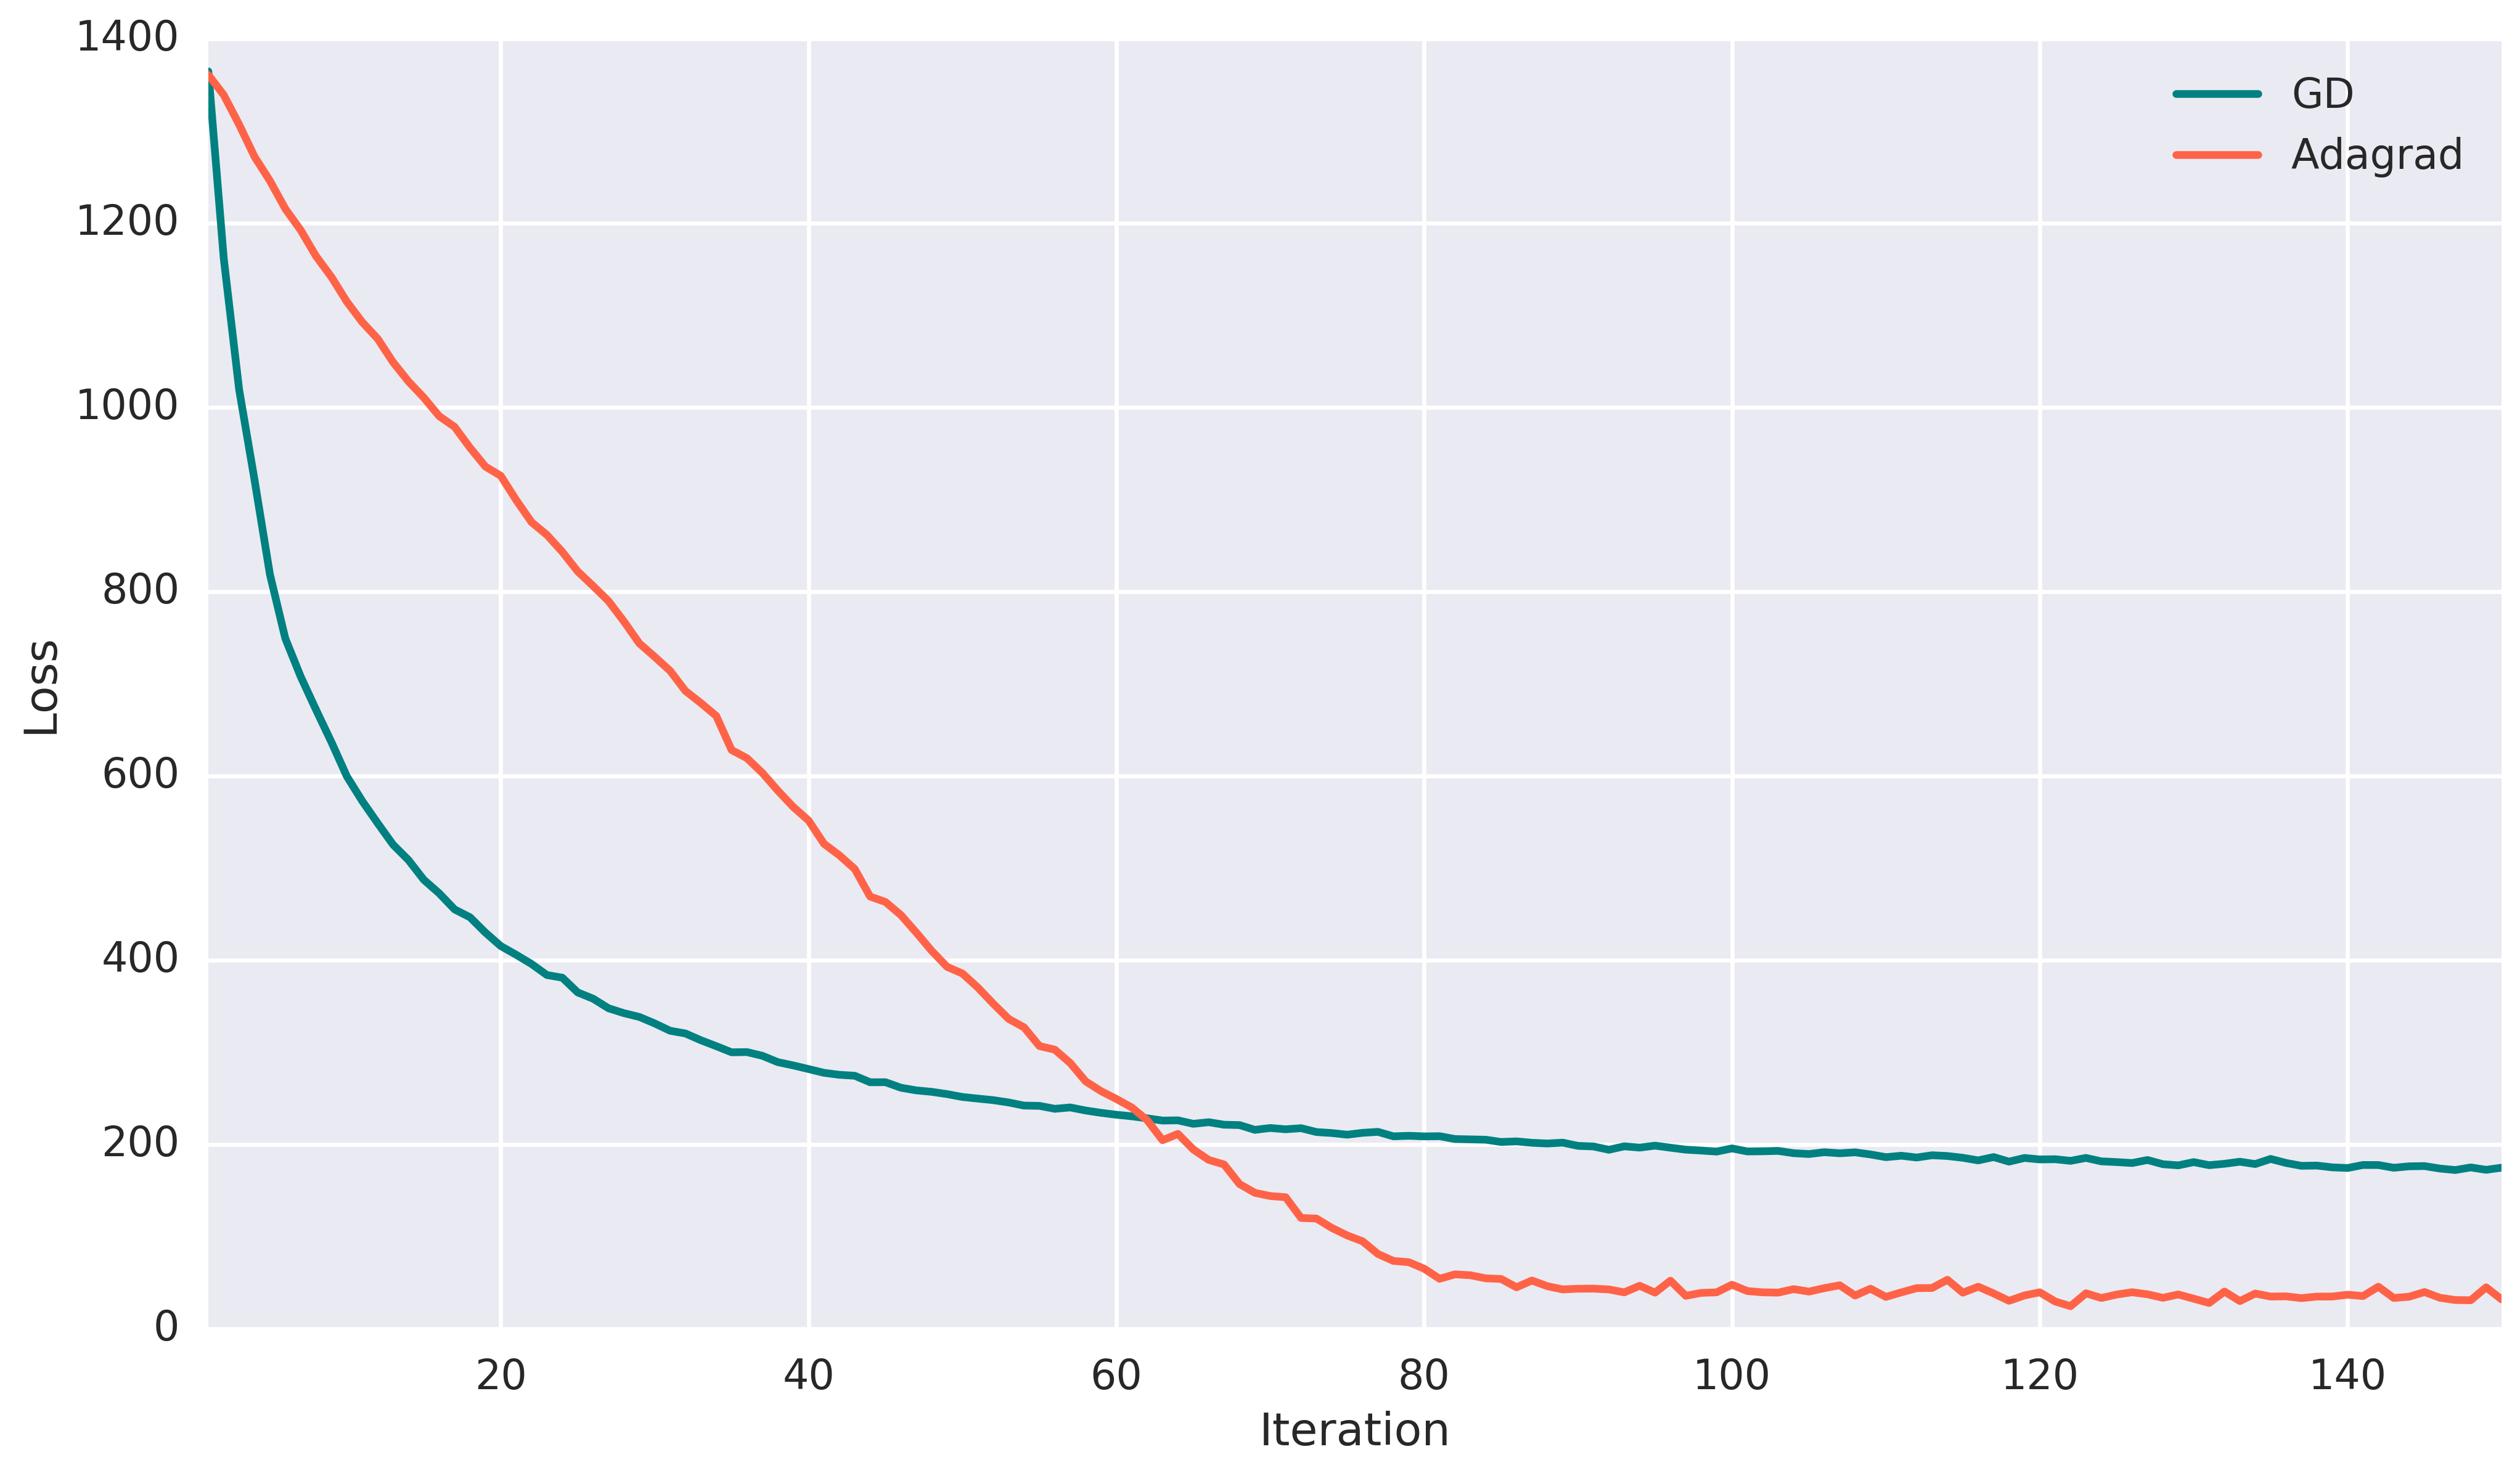

In [125]:
plt.figure(figsize = (16,9), dpi = 300)
plt.plot(range(1,151), l_list1, color = 'teal', label ="GD", linewidth = 3)
plt.plot(range(1,151), l_list2, color = 'tomato', label = "Adagrad", linewidth = 3)
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.xlim([1, 150])
plt.show()

## Different initia

In [17]:
dode = MCDODE(nb, config)
dode.add_data(data_dict)
res_df = pd.DataFrame(index = range(100), columns = ['y_car', 'y_truck', 'x_car', 'x_truck', 'f_car', 'f_truck'])
for i in range(100):
    dode = MCDODE(nb, config)
    dode.add_data(data_dict)
    (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 150, step_size = 1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)
    dta = dode._run_simulation(car_flow, truck_flow)
    estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    y_car = r2_score(m_car, L_car.dot(estimated_car_x))
    e_m_truck =L_truck.dot(estimated_truck_x)
    y_truck = r2_score(m_truck[e_m_truck < 50], e_m_truck[e_m_truck < 50])
    truck_flow = true_truck_f + (np.random.rand(len(true_car_f)) * 2- 1) * np.random.rand() * 2
    x_car = r2_score(true_car_x, estimated_car_x)
    x_truck = r2_score(true_truck_x[estimated_truck_x<30], estimated_truck_x[estimated_truck_x<30])
    f_car =  r2_score(true_car_f[car_flow<140], car_flow[car_flow<140])
    f_truck =  r2_score(true_truck_f[truck_flow<15], truck_flow[truck_flow<15])
    res_df.iloc[i] = [y_car, y_truck, x_car, x_truck, f_car, f_truck]

Epoch: 0 Loss: 1212.7300224289643 1532754129.04
Epoch: 1 Loss: 1185.384756239878 1532754129.09
Epoch: 2 Loss: 1156.0279276272931 1532754129.15
Epoch: 3 Loss: 1121.0376416203105 1532754129.22
Epoch: 4 Loss: 1087.621008642649 1532754129.29
Epoch: 5 Loss: 1055.3389525122861 1532754129.37
Epoch: 6 Loss: 1026.138132085513 1532754129.44
Epoch: 7 Loss: 995.5379929102146 1532754129.52
Epoch: 8 Loss: 975.1310139189588 1532754129.61
Epoch: 9 Loss: 951.6536934527574 1532754129.69
Epoch: 10 Loss: 932.1947537161121 1532754129.78
Epoch: 11 Loss: 915.1188857863377 1532754129.87
Epoch: 12 Loss: 897.7309890631161 1532754129.98
Epoch: 13 Loss: 884.6974848073387 1532754130.08
Epoch: 14 Loss: 863.8078790379045 1532754130.18
Epoch: 15 Loss: 841.2305679057274 1532754130.27
Epoch: 16 Loss: 825.6586853004893 1532754130.38
Epoch: 17 Loss: 809.157558530533 1532754130.48
Epoch: 18 Loss: 791.1657391422906 1532754130.58
Epoch: 19 Loss: 770.745663292533 1532754130.69
Epoch: 20 Loss: 760.27752650953 1532754130.8
Epo

Epoch: 20 Loss: 760.1958561763762 1532754153.13
Epoch: 21 Loss: 736.6425467751276 1532754153.24
Epoch: 22 Loss: 721.8831715215429 1532754153.35
Epoch: 23 Loss: 706.8238539794781 1532754153.47
Epoch: 24 Loss: 688.5161996238958 1532754153.6
Epoch: 25 Loss: 673.6182448114068 1532754153.73
Epoch: 26 Loss: 651.1418723670924 1532754153.85
Epoch: 27 Loss: 636.3706223483255 1532754153.98
Epoch: 28 Loss: 618.276531100856 1532754154.1
Epoch: 29 Loss: 600.8785471806484 1532754154.23
Epoch: 30 Loss: 595.4271703340966 1532754154.35
Epoch: 31 Loss: 571.3347782536273 1532754154.48
Epoch: 32 Loss: 552.3152273253231 1532754154.61
Epoch: 33 Loss: 530.2413292360136 1532754154.74
Epoch: 34 Loss: 518.296810284803 1532754154.88
Epoch: 35 Loss: 508.23639912272284 1532754155.02
Epoch: 36 Loss: 488.57772181609266 1532754155.16
Epoch: 37 Loss: 477.26328784790144 1532754155.29
Epoch: 38 Loss: 453.03106187718515 1532754155.43
Epoch: 39 Loss: 433.9841065501575 1532754155.57
Epoch: 40 Loss: 427.88047561762875 15327

Epoch: 39 Loss: 476.4318743706372 1532754177.49
Epoch: 40 Loss: 459.6739880512205 1532754177.63
Epoch: 41 Loss: 442.65719291430895 1532754177.78
Epoch: 42 Loss: 434.528709098641 1532754177.92
Epoch: 43 Loss: 419.3776443112673 1532754178.07
Epoch: 44 Loss: 398.21536802819736 1532754178.21
Epoch: 45 Loss: 388.05749110810575 1532754178.36
Epoch: 46 Loss: 369.85828848093456 1532754178.51
Epoch: 47 Loss: 357.7396952182869 1532754178.66
Epoch: 48 Loss: 365.14490258582066 1532754178.81
Epoch: 49 Loss: 344.4061651842957 1532754178.96
Epoch: 50 Loss: 331.74621368966143 1532754179.11
Epoch: 51 Loss: 319.38861180731647 1532754179.26
Epoch: 52 Loss: 306.35058500637683 1532754179.41
Epoch: 53 Loss: 295.11155067844527 1532754179.57
Epoch: 54 Loss: 279.2391446260497 1532754179.72
Epoch: 55 Loss: 273.19340291090504 1532754179.88
Epoch: 56 Loss: 258.7942009610438 1532754180.04
Epoch: 57 Loss: 252.181225001442 1532754180.2
Epoch: 58 Loss: 244.3421721664084 1532754180.38
Epoch: 59 Loss: 227.8655950260145

Epoch: 60 Loss: 168.0298473435299 1532754203.05
Epoch: 61 Loss: 155.42144853616176 1532754203.21
Epoch: 62 Loss: 159.3258115851348 1532754203.38
Epoch: 63 Loss: 144.58022570267502 1532754203.53
Epoch: 64 Loss: 139.09645123967934 1532754203.72
Epoch: 65 Loss: 130.76227143912726 1532754203.9
Epoch: 66 Loss: 121.25192530452622 1532754204.08
Epoch: 67 Loss: 118.25183148116855 1532754204.27
Epoch: 68 Loss: 95.75196611612492 1532754204.44
Epoch: 69 Loss: 107.96421770126923 1532754204.6
Epoch: 70 Loss: 96.06750436862036 1532754204.77
Epoch: 71 Loss: 93.9197294204194 1532754204.98
Epoch: 72 Loss: 89.45174668394843 1532754205.17
Epoch: 73 Loss: 85.25728163475333 1532754205.34
Epoch: 74 Loss: 78.41439883549893 1532754205.52
Epoch: 75 Loss: 72.70615144245602 1532754205.69
Epoch: 76 Loss: 76.43286378531106 1532754205.87
Epoch: 77 Loss: 65.10684074554182 1532754206.03
Epoch: 78 Loss: 63.293949348906565 1532754206.2
Epoch: 79 Loss: 60.78897419689595 1532754206.37
Epoch: 80 Loss: 58.08534541023796 15

Epoch: 80 Loss: 56.315727873193545 1532754228.7
Epoch: 81 Loss: 56.50245847808801 1532754228.87
Epoch: 82 Loss: 55.396349454681655 1532754229.03
Epoch: 83 Loss: 52.07750385752434 1532754229.19
Epoch: 84 Loss: 49.79614063520426 1532754229.35
Epoch: 85 Loss: 48.6353860203387 1532754229.5
Epoch: 86 Loss: 52.131100764117306 1532754229.66
Epoch: 87 Loss: 51.5551237319392 1532754229.81
Epoch: 88 Loss: 46.34083103521511 1532754229.97
Epoch: 89 Loss: 55.38140049136044 1532754230.13
Epoch: 90 Loss: 46.671533503624104 1532754230.28
Epoch: 91 Loss: 45.151352798420085 1532754230.45
Epoch: 92 Loss: 43.56994397538336 1532754230.62
Epoch: 93 Loss: 49.783248799308154 1532754230.78
Epoch: 94 Loss: 43.724115071764615 1532754230.94
Epoch: 95 Loss: 40.91458754818289 1532754231.09
Epoch: 96 Loss: 45.30682983088989 1532754231.25
Epoch: 97 Loss: 36.37652964843705 1532754231.41
Epoch: 98 Loss: 37.39714664402352 1532754231.56
Epoch: 99 Loss: 36.580146501795994 1532754231.72
Epoch: 100 Loss: 36.95957004119477 1

Epoch: 101 Loss: 35.47468209561265 1532754255.69
Epoch: 102 Loss: 36.120126272686846 1532754255.86
Epoch: 103 Loss: 40.69942835305091 1532754256.03
Epoch: 104 Loss: 32.57554190090686 1532754256.21
Epoch: 105 Loss: 37.49917260004101 1532754256.38
Epoch: 106 Loss: 41.89589271054001 1532754256.55
Epoch: 107 Loss: 40.836544134832536 1532754256.73
Epoch: 108 Loss: 34.1544334867983 1532754256.9
Epoch: 109 Loss: 35.68015592216497 1532754257.08
Epoch: 110 Loss: 37.28775740667122 1532754257.26
Epoch: 111 Loss: 40.663991739808196 1532754257.45
Epoch: 112 Loss: 39.82969926529943 1532754257.62
Epoch: 113 Loss: 35.81081038464836 1532754257.8
Epoch: 114 Loss: 33.82925495094805 1532754257.97
Epoch: 115 Loss: 39.79621787205602 1532754258.14
Epoch: 116 Loss: 34.39932368695293 1532754258.31
Epoch: 117 Loss: 35.21397633885425 1532754258.49
Epoch: 118 Loss: 33.237374881200395 1532754258.66
Epoch: 119 Loss: 36.33981116601373 1532754258.83
Epoch: 120 Loss: 28.95472969619255 1532754259.0
Epoch: 121 Loss: 41.

Epoch: 120 Loss: 42.01587892045091 1532754281.65
Epoch: 121 Loss: 31.001777892639375 1532754281.84
Epoch: 122 Loss: 35.87874275761698 1532754282.03
Epoch: 123 Loss: 34.03114532121784 1532754282.22
Epoch: 124 Loss: 37.77237069424093 1532754282.39
Epoch: 125 Loss: 38.41591538734073 1532754282.57
Epoch: 126 Loss: 31.868365416972633 1532754282.75
Epoch: 127 Loss: 27.622497951497966 1532754282.92
Epoch: 128 Loss: 30.061344694285754 1532754283.09
Epoch: 129 Loss: 32.78786808734448 1532754283.26
Epoch: 130 Loss: 35.44579341531186 1532754283.44
Epoch: 131 Loss: 26.2798357544981 1532754283.62
Epoch: 132 Loss: 46.85359938828851 1532754283.79
Epoch: 133 Loss: 34.24841598545039 1532754283.97
Epoch: 134 Loss: 39.718528118813595 1532754284.14
Epoch: 135 Loss: 29.24657493975453 1532754284.3
Epoch: 136 Loss: 35.19933790871414 1532754284.47
Epoch: 137 Loss: 27.374100326004225 1532754284.67
Epoch: 138 Loss: 30.580437513552347 1532754284.85
Epoch: 139 Loss: 24.52759529654236 1532754285.01
Epoch: 140 Loss

Epoch: 139 Loss: 28.4081331003474 1532754308.45
Epoch: 140 Loss: 41.96724514816829 1532754308.62
Epoch: 141 Loss: 36.96530900713981 1532754308.8
Epoch: 142 Loss: 31.37332468437669 1532754308.98
Epoch: 143 Loss: 28.579515198975177 1532754309.15
Epoch: 144 Loss: 29.97751755171373 1532754309.32
Epoch: 145 Loss: 39.59733348560072 1532754309.5
Epoch: 146 Loss: 37.13132565006957 1532754309.68
Epoch: 147 Loss: 39.844136134287105 1532754309.85
Epoch: 148 Loss: 27.29896429590324 1532754310.03
Epoch: 149 Loss: 31.68000904459704 1532754310.2
Epoch: 0 Loss: 1214.8968520661604 1532754310.42
Epoch: 1 Loss: 1191.6150186273499 1532754310.48
Epoch: 2 Loss: 1160.2756846174423 1532754310.54
Epoch: 3 Loss: 1127.3855561501193 1532754310.61
Epoch: 4 Loss: 1094.4783431807775 1532754310.68
Epoch: 5 Loss: 1062.4887491920629 1532754310.75
Epoch: 6 Loss: 1033.8054830524325 1532754310.83
Epoch: 7 Loss: 1005.3273069825916 1532754310.92
Epoch: 8 Loss: 978.458527071043 1532754311.0
Epoch: 9 Loss: 955.2040848853826 1

Epoch: 10 Loss: 939.010104629884 1532754333.33
Epoch: 11 Loss: 922.0716296817918 1532754333.42
Epoch: 12 Loss: 902.9913264417759 1532754333.52
Epoch: 13 Loss: 884.8240725186229 1532754333.61
Epoch: 14 Loss: 872.5115869788475 1532754333.71
Epoch: 15 Loss: 855.108508332564 1532754333.81
Epoch: 16 Loss: 829.1753287367802 1532754333.91
Epoch: 17 Loss: 810.5196267382157 1532754334.02
Epoch: 18 Loss: 796.867340782613 1532754334.13
Epoch: 19 Loss: 780.3264537586592 1532754334.24
Epoch: 20 Loss: 761.5273763223001 1532754334.35
Epoch: 21 Loss: 736.1914108634002 1532754334.46
Epoch: 22 Loss: 722.973961151257 1532754334.58
Epoch: 23 Loss: 710.7976081933173 1532754334.69
Epoch: 24 Loss: 689.1204932324522 1532754334.81
Epoch: 25 Loss: 665.8888050650793 1532754334.92
Epoch: 26 Loss: 654.7038454759959 1532754335.05
Epoch: 27 Loss: 643.2453481715862 1532754335.17
Epoch: 28 Loss: 628.7559727737486 1532754335.3
Epoch: 29 Loss: 604.2369611047463 1532754335.43
Epoch: 30 Loss: 593.6049391802998 1532754335.

Epoch: 31 Loss: 571.9898338963319 1532754358.46
Epoch: 32 Loss: 554.2489342866509 1532754358.59
Epoch: 33 Loss: 531.337532753822 1532754358.73
Epoch: 34 Loss: 520.8920735862606 1532754358.86
Epoch: 35 Loss: 496.80581804754485 1532754358.99
Epoch: 36 Loss: 483.70786991660424 1532754359.13
Epoch: 37 Loss: 464.2336371100065 1532754359.27
Epoch: 38 Loss: 454.5960114431044 1532754359.41
Epoch: 39 Loss: 437.2820040015193 1532754359.55
Epoch: 40 Loss: 419.9239161240251 1532754359.69
Epoch: 41 Loss: 409.5833163960292 1532754359.83
Epoch: 42 Loss: 400.0624452772032 1532754359.98
Epoch: 43 Loss: 388.3607526491076 1532754360.12
Epoch: 44 Loss: 366.8956407933016 1532754360.27
Epoch: 45 Loss: 357.51158143873585 1532754360.41
Epoch: 46 Loss: 342.17308326895284 1532754360.56
Epoch: 47 Loss: 330.7643607036512 1532754360.71
Epoch: 48 Loss: 305.8349739692346 1532754360.86
Epoch: 49 Loss: 294.4720309398529 1532754361.01
Epoch: 50 Loss: 291.7637390232821 1532754361.17
Epoch: 51 Loss: 271.8627110494468 153

Epoch: 52 Loss: 264.9914271714765 1532754385.49
Epoch: 53 Loss: 237.59000541371378 1532754385.66
Epoch: 54 Loss: 232.00661196009136 1532754385.83
Epoch: 55 Loss: 236.02496744894873 1532754385.99
Epoch: 56 Loss: 211.96583550665156 1532754386.17
Epoch: 57 Loss: 206.84761789348056 1532754386.35
Epoch: 58 Loss: 183.75834389654753 1532754386.52
Epoch: 59 Loss: 185.06692733982763 1532754386.71
Epoch: 60 Loss: 168.82934233304482 1532754386.88
Epoch: 61 Loss: 161.69938994047578 1532754387.06
Epoch: 62 Loss: 157.73535451267585 1532754387.3
Epoch: 63 Loss: 140.12589626988165 1532754387.48
Epoch: 64 Loss: 139.64639418048623 1532754387.67
Epoch: 65 Loss: 127.69510770361966 1532754387.84
Epoch: 66 Loss: 112.67576729974634 1532754388.01
Epoch: 67 Loss: 111.87395950762729 1532754388.19
Epoch: 68 Loss: 107.41694785952843 1532754388.38
Epoch: 69 Loss: 95.33277621006138 1532754388.56
Epoch: 70 Loss: 86.46337173147383 1532754388.74
Epoch: 71 Loss: 85.75813572723565 1532754388.91
Epoch: 72 Loss: 78.634369

Epoch: 71 Loss: 85.14672109436607 1532754412.84
Epoch: 72 Loss: 89.24142705529293 1532754413.01
Epoch: 73 Loss: 81.03832082571674 1532754413.19
Epoch: 74 Loss: 79.28292355920036 1532754413.36
Epoch: 75 Loss: 75.52329284917671 1532754413.53
Epoch: 76 Loss: 68.0981244356248 1532754413.73
Epoch: 77 Loss: 68.63669206706199 1532754413.94
Epoch: 78 Loss: 60.87615273677359 1532754414.12
Epoch: 79 Loss: 64.60610921997213 1532754414.3
Epoch: 80 Loss: 62.88218216046943 1532754414.49
Epoch: 81 Loss: 57.65792688102353 1532754414.67
Epoch: 82 Loss: 57.73345289151143 1532754414.84
Epoch: 83 Loss: 55.61315835176597 1532754415.01
Epoch: 84 Loss: 53.59383987033483 1532754415.18
Epoch: 85 Loss: 51.96222040389627 1532754415.35
Epoch: 86 Loss: 60.19813306373255 1532754415.52
Epoch: 87 Loss: 46.37018530619902 1532754415.69
Epoch: 88 Loss: 48.71986693924641 1532754415.86
Epoch: 89 Loss: 45.0772790256409 1532754416.04
Epoch: 90 Loss: 49.81345504602666 1532754416.22
Epoch: 91 Loss: 46.16365516220251 153275441

Epoch: 91 Loss: 50.65259444038169 1532754440.03
Epoch: 92 Loss: 44.72508484312616 1532754440.19
Epoch: 93 Loss: 52.222401967871676 1532754440.35
Epoch: 94 Loss: 45.71088605315087 1532754440.52
Epoch: 95 Loss: 43.28584032743021 1532754440.68
Epoch: 96 Loss: 43.27152107402827 1532754440.85
Epoch: 97 Loss: 40.94850038151051 1532754441.01
Epoch: 98 Loss: 41.15665209467486 1532754441.19
Epoch: 99 Loss: 40.299189870441495 1532754441.36
Epoch: 100 Loss: 38.703055337346925 1532754441.52
Epoch: 101 Loss: 43.90941049838886 1532754441.69
Epoch: 102 Loss: 40.15019147326667 1532754441.86
Epoch: 103 Loss: 40.306614384066044 1532754442.02
Epoch: 104 Loss: 40.11288491462162 1532754442.19
Epoch: 105 Loss: 34.01357746664911 1532754442.35
Epoch: 106 Loss: 46.75327717514108 1532754442.52
Epoch: 107 Loss: 36.66366290168081 1532754442.69
Epoch: 108 Loss: 37.091189121508464 1532754442.85
Epoch: 109 Loss: 36.665485195814085 1532754443.02
Epoch: 110 Loss: 31.94687893133794 1532754443.18
Epoch: 111 Loss: 37.888

Epoch: 110 Loss: 28.357210141212164 1532754466.1
Epoch: 111 Loss: 33.99564795184456 1532754466.28
Epoch: 112 Loss: 43.493390333170204 1532754466.46
Epoch: 113 Loss: 33.99031506420722 1532754466.63
Epoch: 114 Loss: 34.05786161293599 1532754466.8
Epoch: 115 Loss: 29.000725190250805 1532754466.97
Epoch: 116 Loss: 38.63648223155714 1532754467.15
Epoch: 117 Loss: 33.6126743355822 1532754467.33
Epoch: 118 Loss: 34.796416941461686 1532754467.5
Epoch: 119 Loss: 26.879365088140066 1532754467.68
Epoch: 120 Loss: 34.72323226241612 1532754467.85
Epoch: 121 Loss: 31.935079703351633 1532754468.02
Epoch: 122 Loss: 34.00521700842951 1532754468.2
Epoch: 123 Loss: 30.871649541268912 1532754468.37
Epoch: 124 Loss: 33.73478623833482 1532754468.54
Epoch: 125 Loss: 25.224557608866693 1532754468.71
Epoch: 126 Loss: 32.39967717289338 1532754468.89
Epoch: 127 Loss: 34.60543512414044 1532754469.06
Epoch: 128 Loss: 36.3660400765872 1532754469.23
Epoch: 129 Loss: 29.71941313619616 1532754469.4
Epoch: 130 Loss: 43

Epoch: 130 Loss: 32.25814771637917 1532754493.16
Epoch: 131 Loss: 29.726928051794275 1532754493.33
Epoch: 132 Loss: 40.80456560345097 1532754493.51
Epoch: 133 Loss: 29.463177550127497 1532754493.69
Epoch: 134 Loss: 35.033237076061205 1532754493.88
Epoch: 135 Loss: 30.146717794473112 1532754494.05
Epoch: 136 Loss: 29.349111560012947 1532754494.23
Epoch: 137 Loss: 37.04742808414745 1532754494.4
Epoch: 138 Loss: 35.87458829384559 1532754494.57
Epoch: 139 Loss: 31.63384648684012 1532754494.75
Epoch: 140 Loss: 31.139474956519575 1532754494.93
Epoch: 141 Loss: 31.689771088188685 1532754495.1
Epoch: 142 Loss: 30.34681825170631 1532754495.28
Epoch: 143 Loss: 30.745537410397475 1532754495.46
Epoch: 144 Loss: 24.211545279486636 1532754495.63
Epoch: 145 Loss: 27.059474370938695 1532754495.8
Epoch: 146 Loss: 28.550931937061602 1532754495.98
Epoch: 147 Loss: 32.085959994138165 1532754496.16
Epoch: 148 Loss: 33.17407943064825 1532754496.33
Epoch: 149 Loss: 36.570341193188035 1532754496.5
Epoch: 0 Lo

Epoch: 0 Loss: 1209.6267752699582 1532754520.15
Epoch: 1 Loss: 1185.2253310916146 1532754520.21
Epoch: 2 Loss: 1151.7882265811968 1532754520.27
Epoch: 3 Loss: 1115.0756170498382 1532754520.34
Epoch: 4 Loss: 1084.9810098655303 1532754520.41
Epoch: 5 Loss: 1052.1373783535541 1532754520.49
Epoch: 6 Loss: 1023.4520933526114 1532754520.57
Epoch: 7 Loss: 997.867649022538 1532754520.65
Epoch: 8 Loss: 973.3796603664385 1532754520.74
Epoch: 9 Loss: 949.7465132658965 1532754520.83
Epoch: 10 Loss: 934.3207348327663 1532754520.92
Epoch: 11 Loss: 913.670607910145 1532754521.02
Epoch: 12 Loss: 897.6916744031627 1532754521.11
Epoch: 13 Loss: 876.8841476256151 1532754521.21
Epoch: 14 Loss: 860.6618105714034 1532754521.31
Epoch: 15 Loss: 842.1487495590636 1532754521.41
Epoch: 16 Loss: 823.046553986415 1532754521.52
Epoch: 17 Loss: 804.1773392486344 1532754521.62
Epoch: 18 Loss: 784.5959539909559 1532754521.73
Epoch: 19 Loss: 774.1411362923926 1532754521.84
Epoch: 20 Loss: 745.7639469880569 1532754521.9

Epoch: 21 Loss: 745.866956916742 1532754545.67
Epoch: 22 Loss: 728.6120917905154 1532754545.79
Epoch: 23 Loss: 709.8555215056344 1532754545.92
Epoch: 24 Loss: 691.5708577598243 1532754546.04
Epoch: 25 Loss: 674.8092721347242 1532754546.17
Epoch: 26 Loss: 660.6241293392875 1532754546.29
Epoch: 27 Loss: 642.3253411781361 1532754546.42
Epoch: 28 Loss: 620.2860468837672 1532754546.55
Epoch: 29 Loss: 608.339257011835 1532754546.69
Epoch: 30 Loss: 589.4968910793434 1532754546.82
Epoch: 31 Loss: 576.9717568501163 1532754546.95
Epoch: 32 Loss: 562.6510257240152 1532754547.09
Epoch: 33 Loss: 543.5777728347988 1532754547.23
Epoch: 34 Loss: 528.5629459181278 1532754547.37
Epoch: 35 Loss: 516.6706400736444 1532754547.51
Epoch: 36 Loss: 491.92321163430324 1532754547.67
Epoch: 37 Loss: 481.3659195039856 1532754547.84
Epoch: 38 Loss: 460.4073235314267 1532754548.0
Epoch: 39 Loss: 452.2578131945264 1532754548.15
Epoch: 40 Loss: 436.82636867920615 1532754548.3
Epoch: 41 Loss: 412.24986028955294 1532754

Epoch: 42 Loss: 413.7898241812055 1532754571.97
Epoch: 43 Loss: 392.89768717539243 1532754572.12
Epoch: 44 Loss: 376.1984330977886 1532754572.27
Epoch: 45 Loss: 361.0289023208308 1532754572.42
Epoch: 46 Loss: 348.41483301913104 1532754572.57
Epoch: 47 Loss: 331.2672417878547 1532754572.73
Epoch: 48 Loss: 327.10441568543985 1532754572.88
Epoch: 49 Loss: 312.06939701138833 1532754573.04
Epoch: 50 Loss: 294.3383599307147 1532754573.2
Epoch: 51 Loss: 288.781930296589 1532754573.36
Epoch: 52 Loss: 275.44393685874707 1532754573.52
Epoch: 53 Loss: 260.09834775174363 1532754573.67
Epoch: 54 Loss: 239.1515121044205 1532754573.83
Epoch: 55 Loss: 243.84973449269242 1532754573.99
Epoch: 56 Loss: 222.78061335568643 1532754574.16
Epoch: 57 Loss: 210.95282916755863 1532754574.32
Epoch: 58 Loss: 210.58434965641524 1532754574.49
Epoch: 59 Loss: 201.74503785310185 1532754574.65
Epoch: 60 Loss: 187.3303006012337 1532754574.82
Epoch: 61 Loss: 165.22307016434954 1532754574.98
Epoch: 62 Loss: 153.0148618247

Epoch: 61 Loss: 165.96649542821294 1532754598.67
Epoch: 62 Loss: 151.68833164677326 1532754598.84
Epoch: 63 Loss: 145.95982404192705 1532754599.03
Epoch: 64 Loss: 139.57473206178585 1532754599.2
Epoch: 65 Loss: 129.3063881480289 1532754599.38
Epoch: 66 Loss: 121.2787688344931 1532754599.55
Epoch: 67 Loss: 117.57635734287123 1532754599.72
Epoch: 68 Loss: 113.3544265051484 1532754599.9
Epoch: 69 Loss: 108.18002786740274 1532754600.07
Epoch: 70 Loss: 98.78322525923767 1532754600.25
Epoch: 71 Loss: 98.61213788847024 1532754600.41
Epoch: 72 Loss: 96.79834321281149 1532754600.6
Epoch: 73 Loss: 80.61658739106849 1532754600.79
Epoch: 74 Loss: 79.72405399413582 1532754600.96
Epoch: 75 Loss: 79.40260114291549 1532754601.14
Epoch: 76 Loss: 71.71144768697023 1532754601.31
Epoch: 77 Loss: 74.45491970109157 1532754601.48
Epoch: 78 Loss: 57.80497771877596 1532754601.66
Epoch: 79 Loss: 63.81265831270207 1532754601.83
Epoch: 80 Loss: 59.83793108633381 1532754602.0
Epoch: 81 Loss: 60.31596727799994 1532

Epoch: 82 Loss: 53.14271750429407 1532754626.14
Epoch: 83 Loss: 56.479775508228194 1532754626.32
Epoch: 84 Loss: 47.424504939204226 1532754626.49
Epoch: 85 Loss: 52.14041823478318 1532754626.67
Epoch: 86 Loss: 45.60980040070007 1532754626.84
Epoch: 87 Loss: 52.497410728333094 1532754627.02
Epoch: 88 Loss: 43.41054925778481 1532754627.19
Epoch: 89 Loss: 48.77066515180952 1532754627.36
Epoch: 90 Loss: 44.88402588500698 1532754627.52
Epoch: 91 Loss: 42.934898052125526 1532754627.69
Epoch: 92 Loss: 40.154964204903855 1532754627.85
Epoch: 93 Loss: 42.40014051054655 1532754628.03
Epoch: 94 Loss: 37.244688701015725 1532754628.21
Epoch: 95 Loss: 47.78344272825231 1532754628.41
Epoch: 96 Loss: 41.785761142140224 1532754628.62
Epoch: 97 Loss: 38.683259999719716 1532754628.81
Epoch: 98 Loss: 35.307045153137906 1532754628.98
Epoch: 99 Loss: 40.588183643657786 1532754629.16
Epoch: 100 Loss: 38.86809504501221 1532754629.33
Epoch: 101 Loss: 34.62324432701862 1532754629.5
Epoch: 102 Loss: 36.106597866

Epoch: 101 Loss: 37.99341868259882 1532754652.99
Epoch: 102 Loss: 44.502635228610636 1532754653.17
Epoch: 103 Loss: 38.75576202211676 1532754653.33
Epoch: 104 Loss: 41.36925151094194 1532754653.5
Epoch: 105 Loss: 41.37030498591727 1532754653.67
Epoch: 106 Loss: 46.985435756645266 1532754653.84
Epoch: 107 Loss: 40.793730396588806 1532754654.01
Epoch: 108 Loss: 39.94310108499084 1532754654.18
Epoch: 109 Loss: 37.14791450882439 1532754654.35
Epoch: 110 Loss: 32.05860401485191 1532754654.51
Epoch: 111 Loss: 48.053290642079645 1532754654.68
Epoch: 112 Loss: 36.820441486382634 1532754654.84
Epoch: 113 Loss: 37.901690126813264 1532754655.01
Epoch: 114 Loss: 36.39772972050838 1532754655.18
Epoch: 115 Loss: 38.415855264170546 1532754655.34
Epoch: 116 Loss: 32.991034602015496 1532754655.51
Epoch: 117 Loss: 37.83672972718561 1532754655.68
Epoch: 118 Loss: 35.9914512467158 1532754655.84
Epoch: 119 Loss: 30.503151050716518 1532754656.01
Epoch: 120 Loss: 31.663800213296327 1532754656.18
Epoch: 121 L

Epoch: 120 Loss: 40.97007334404829 1532754679.7
Epoch: 121 Loss: 29.506807899530152 1532754679.87
Epoch: 122 Loss: 37.32032475673407 1532754680.04
Epoch: 123 Loss: 35.44819771229582 1532754680.22
Epoch: 124 Loss: 31.67389542743756 1532754680.39
Epoch: 125 Loss: 32.62151278642159 1532754680.57
Epoch: 126 Loss: 34.02985653221857 1532754680.76
Epoch: 127 Loss: 31.349437572593594 1532754680.93
Epoch: 128 Loss: 30.52026112055946 1532754681.11
Epoch: 129 Loss: 36.56161008432673 1532754681.28
Epoch: 130 Loss: 37.52666991593526 1532754681.45
Epoch: 131 Loss: 27.553015479393117 1532754681.61
Epoch: 132 Loss: 31.261329281781254 1532754681.78
Epoch: 133 Loss: 27.35619819874084 1532754681.95
Epoch: 134 Loss: 43.764674803748875 1532754682.12
Epoch: 135 Loss: 27.179103354372835 1532754682.28
Epoch: 136 Loss: 35.03764241819019 1532754682.45
Epoch: 137 Loss: 28.26841500149186 1532754682.62
Epoch: 138 Loss: 39.72866023328638 1532754682.79
Epoch: 139 Loss: 35.59411684049245 1532754682.95
Epoch: 140 Loss

Epoch: 140 Loss: 40.12768628516731 1532754705.7
Epoch: 141 Loss: 29.75984675163663 1532754705.87
Epoch: 142 Loss: 34.623788966427476 1532754706.03
Epoch: 143 Loss: 32.405112454766254 1532754706.2
Epoch: 144 Loss: 29.961366860490507 1532754706.36
Epoch: 145 Loss: 30.67872045688739 1532754706.53
Epoch: 146 Loss: 38.781281856320724 1532754706.7
Epoch: 147 Loss: 27.684375891813023 1532754706.86
Epoch: 148 Loss: 28.819782828842065 1532754707.03
Epoch: 149 Loss: 34.005622887391574 1532754707.2
Epoch: 0 Loss: 1222.5986072293028 1532754707.42
Epoch: 1 Loss: 1202.7826844193567 1532754707.47
Epoch: 2 Loss: 1173.0091022187373 1532754707.53
Epoch: 3 Loss: 1143.937673135912 1532754707.6
Epoch: 4 Loss: 1109.746274432083 1532754707.67
Epoch: 5 Loss: 1076.7589323592128 1532754707.75
Epoch: 6 Loss: 1043.6201405389536 1532754707.82
Epoch: 7 Loss: 1021.3594689382295 1532754707.91
Epoch: 8 Loss: 992.4023910484542 1532754708.0
Epoch: 9 Loss: 973.3303302690531 1532754708.09
Epoch: 10 Loss: 951.0186766067636

Epoch: 10 Loss: 930.5068826121196 1532754730.98
Epoch: 11 Loss: 912.8707049259713 1532754731.07
Epoch: 12 Loss: 896.3730863621581 1532754731.17
Epoch: 13 Loss: 879.8705384357781 1532754731.26
Epoch: 14 Loss: 866.2990052935246 1532754731.36
Epoch: 15 Loss: 844.7671624330978 1532754731.46
Epoch: 16 Loss: 822.6686948202886 1532754731.57
Epoch: 17 Loss: 807.4827222867465 1532754731.67
Epoch: 18 Loss: 787.0785150167304 1532754731.78
Epoch: 19 Loss: 770.657260844966 1532754731.89
Epoch: 20 Loss: 754.9438923355142 1532754732.0
Epoch: 21 Loss: 732.4391374621596 1532754732.12
Epoch: 22 Loss: 718.4976360764368 1532754732.24
Epoch: 23 Loss: 700.1046169675969 1532754732.35
Epoch: 24 Loss: 682.7256899018023 1532754732.47
Epoch: 25 Loss: 662.8182499438861 1532754732.6
Epoch: 26 Loss: 652.8015919575948 1532754732.72
Epoch: 27 Loss: 636.798792427313 1532754732.84
Epoch: 28 Loss: 615.3887284260657 1532754732.97
Epoch: 29 Loss: 594.7925479550419 1532754733.1
Epoch: 30 Loss: 580.2523143669504 1532754733.

Epoch: 31 Loss: 563.0606279211763 1532754755.97
Epoch: 32 Loss: 538.3811656960016 1532754756.1
Epoch: 33 Loss: 527.1761786365956 1532754756.25
Epoch: 34 Loss: 514.6204508551668 1532754756.39
Epoch: 35 Loss: 496.2683467604897 1532754756.53
Epoch: 36 Loss: 481.4432132074257 1532754756.67
Epoch: 37 Loss: 460.7967274716526 1532754756.81
Epoch: 38 Loss: 443.8498239201042 1532754756.96
Epoch: 39 Loss: 437.7738637278771 1532754757.11
Epoch: 40 Loss: 419.7431104142068 1532754757.25
Epoch: 41 Loss: 399.34104578545714 1532754757.4
Epoch: 42 Loss: 382.8631451758009 1532754757.55
Epoch: 43 Loss: 378.94594309014354 1532754757.7
Epoch: 44 Loss: 360.78644771661146 1532754757.85
Epoch: 45 Loss: 347.52070666779116 1532754758.01
Epoch: 46 Loss: 333.7043870449843 1532754758.16
Epoch: 47 Loss: 318.71255503432 1532754758.32
Epoch: 48 Loss: 301.2366921327278 1532754758.47
Epoch: 49 Loss: 288.0502022741398 1532754758.64
Epoch: 50 Loss: 287.01044831854995 1532754758.79
Epoch: 51 Loss: 269.15778993998254 15327

Epoch: 51 Loss: 260.1970753273908 1532754781.73
Epoch: 52 Loss: 250.18161347661655 1532754781.9
Epoch: 53 Loss: 243.06972653571734 1532754782.06
Epoch: 54 Loss: 224.33725843810822 1532754782.22
Epoch: 55 Loss: 209.36114681847442 1532754782.38
Epoch: 56 Loss: 199.65802871787497 1532754782.54
Epoch: 57 Loss: 192.52523329328525 1532754782.71
Epoch: 58 Loss: 185.31675408800163 1532754782.87
Epoch: 59 Loss: 164.3944841423826 1532754783.04
Epoch: 60 Loss: 163.37992142094808 1532754783.2
Epoch: 61 Loss: 145.1548070271146 1532754783.37
Epoch: 62 Loss: 148.61380960728275 1532754783.53
Epoch: 63 Loss: 134.1261188575165 1532754783.7
Epoch: 64 Loss: 128.48157628980832 1532754783.86
Epoch: 65 Loss: 123.32620472542455 1532754784.03
Epoch: 66 Loss: 109.69332685938703 1532754784.19
Epoch: 67 Loss: 105.04046323406533 1532754784.36
Epoch: 68 Loss: 106.5552543883184 1532754784.53
Epoch: 69 Loss: 102.80073760800174 1532754784.7
Epoch: 70 Loss: 96.29891342002144 1532754784.87
Epoch: 71 Loss: 87.46456638381

Epoch: 72 Loss: 98.65314847179236 1532754807.86
Epoch: 73 Loss: 89.00758878333325 1532754808.03
Epoch: 74 Loss: 87.14154102713363 1532754808.2
Epoch: 75 Loss: 75.7404903942162 1532754808.36
Epoch: 76 Loss: 74.25609226922735 1532754808.53
Epoch: 77 Loss: 68.7752970809075 1532754808.7
Epoch: 78 Loss: 68.13979025581071 1532754808.87
Epoch: 79 Loss: 65.01019043214578 1532754809.04
Epoch: 80 Loss: 58.88908232071351 1532754809.21
Epoch: 81 Loss: 61.263304669856765 1532754809.38
Epoch: 82 Loss: 58.11536546799874 1532754809.54
Epoch: 83 Loss: 56.252625969334204 1532754809.71
Epoch: 84 Loss: 55.14198328179288 1532754809.88
Epoch: 85 Loss: 53.78337378823736 1532754810.05
Epoch: 86 Loss: 54.97334311777319 1532754810.21
Epoch: 87 Loss: 46.29594794555517 1532754810.38
Epoch: 88 Loss: 51.18939644246261 1532754810.55
Epoch: 89 Loss: 45.943604297924345 1532754810.72
Epoch: 90 Loss: 44.50172173773387 1532754810.88
Epoch: 91 Loss: 43.729268916191735 1532754811.06
Epoch: 92 Loss: 52.225941327980486 15327

Epoch: 92 Loss: 45.95911696155113 1532754833.95
Epoch: 93 Loss: 41.82253642429902 1532754834.17
Epoch: 94 Loss: 42.757942050318775 1532754834.35
Epoch: 95 Loss: 41.417268994277414 1532754834.53
Epoch: 96 Loss: 39.67802331206457 1532754834.7
Epoch: 97 Loss: 42.46553153281614 1532754834.88
Epoch: 98 Loss: 48.098278542634525 1532754835.05
Epoch: 99 Loss: 47.771506312745004 1532754835.22
Epoch: 100 Loss: 41.83554323516922 1532754835.4
Epoch: 101 Loss: 43.21008503481663 1532754835.57
Epoch: 102 Loss: 39.94395440895519 1532754835.74
Epoch: 103 Loss: 38.5155607214206 1532754835.92
Epoch: 104 Loss: 37.51490771458764 1532754836.09
Epoch: 105 Loss: 35.60071452046909 1532754836.27
Epoch: 106 Loss: 34.46652764016005 1532754836.44
Epoch: 107 Loss: 39.91321775437545 1532754836.61
Epoch: 108 Loss: 36.50364149827203 1532754836.78
Epoch: 109 Loss: 37.80959460602075 1532754836.95
Epoch: 110 Loss: 42.3760934907398 1532754837.12
Epoch: 111 Loss: 38.991509443428114 1532754837.29
Epoch: 112 Loss: 34.6815154

Epoch: 112 Loss: 42.937212250545386 1532754860.75
Epoch: 113 Loss: 28.730767519302763 1532754860.91
Epoch: 114 Loss: 38.648365035356655 1532754861.09
Epoch: 115 Loss: 39.3708580628461 1532754861.26
Epoch: 116 Loss: 33.07343486694883 1532754861.42
Epoch: 117 Loss: 31.434143740270347 1532754861.59
Epoch: 118 Loss: 34.209608702936215 1532754861.77
Epoch: 119 Loss: 38.11457856428801 1532754861.94
Epoch: 120 Loss: 35.453595265891806 1532754862.11
Epoch: 121 Loss: 37.77597492969619 1532754862.28
Epoch: 122 Loss: 38.86227220036756 1532754862.45
Epoch: 123 Loss: 34.31791018990066 1532754862.61
Epoch: 124 Loss: 33.05954644923212 1532754862.78
Epoch: 125 Loss: 38.495140715006976 1532754862.95
Epoch: 126 Loss: 29.109910938282766 1532754863.12
Epoch: 127 Loss: 31.31909076532752 1532754863.29
Epoch: 128 Loss: 30.731051000715066 1532754863.46
Epoch: 129 Loss: 31.544594903707967 1532754863.63
Epoch: 130 Loss: 29.449146804633955 1532754863.79
Epoch: 131 Loss: 35.265417398535114 1532754863.96
Epoch: 13

Epoch: 132 Loss: 38.5362755349864 1532754886.98
Epoch: 133 Loss: 41.17943626090978 1532754887.14
Epoch: 134 Loss: 31.752593938434426 1532754887.31
Epoch: 135 Loss: 30.608343383777964 1532754887.48
Epoch: 136 Loss: 31.401827269131132 1532754887.65
Epoch: 137 Loss: 28.573888298916906 1532754887.82
Epoch: 138 Loss: 34.471337353573716 1532754887.98
Epoch: 139 Loss: 37.68249042206671 1532754888.15
Epoch: 140 Loss: 33.05493760883804 1532754888.32
Epoch: 141 Loss: 43.89279518169105 1532754888.49
Epoch: 142 Loss: 26.334948588208576 1532754888.66
Epoch: 143 Loss: 31.550118030721578 1532754888.83
Epoch: 144 Loss: 35.22250711528409 1532754888.99
Epoch: 145 Loss: 29.57270027564394 1532754889.17
Epoch: 146 Loss: 39.540244545129674 1532754889.34
Epoch: 147 Loss: 26.024425941993318 1532754889.51
Epoch: 148 Loss: 31.9502290683529 1532754889.68
Epoch: 149 Loss: 24.058344107551164 1532754889.85
Epoch: 0 Loss: 1203.7142865893104 1532754890.06
Epoch: 1 Loss: 1176.9236223091143 1532754890.12
Epoch: 2 Loss:

Epoch: 4 Loss: 1099.7379123289504 1532754913.46
Epoch: 5 Loss: 1066.6956468722115 1532754913.54
Epoch: 6 Loss: 1039.9599022705618 1532754913.62
Epoch: 7 Loss: 1003.480443893129 1532754913.7
Epoch: 8 Loss: 986.7116872248088 1532754913.79
Epoch: 9 Loss: 965.0313105275301 1532754913.88
Epoch: 10 Loss: 944.6993552599354 1532754913.97
Epoch: 11 Loss: 923.0327979748272 1532754914.06
Epoch: 12 Loss: 907.3090465390243 1532754914.16
Epoch: 13 Loss: 889.8522168239091 1532754914.26
Epoch: 14 Loss: 866.9563210313399 1532754914.36
Epoch: 15 Loss: 850.7423179328534 1532754914.46
Epoch: 16 Loss: 834.427588088122 1532754914.56
Epoch: 17 Loss: 818.9057163852036 1532754914.67
Epoch: 18 Loss: 798.5332302720094 1532754914.78
Epoch: 19 Loss: 778.1936123807541 1532754914.9
Epoch: 20 Loss: 755.0611448191198 1532754915.01
Epoch: 21 Loss: 743.3778464271888 1532754915.12
Epoch: 22 Loss: 731.7684203519048 1532754915.25
Epoch: 23 Loss: 706.6323033471481 1532754915.36
Epoch: 24 Loss: 689.7792054546665 1532754915.4

Epoch: 25 Loss: 661.3204413568335 1532754938.47
Epoch: 26 Loss: 639.3175259271297 1532754938.6
Epoch: 27 Loss: 630.2759042972308 1532754938.73
Epoch: 28 Loss: 601.4626529575767 1532754938.86
Epoch: 29 Loss: 594.1081198673614 1532754938.99
Epoch: 30 Loss: 576.0432327886475 1532754939.12
Epoch: 31 Loss: 556.7767388048389 1532754939.26
Epoch: 32 Loss: 547.3176044018603 1532754939.39
Epoch: 33 Loss: 524.2264780288385 1532754939.53
Epoch: 34 Loss: 509.58263700732596 1532754939.67
Epoch: 35 Loss: 498.54288263670065 1532754939.82
Epoch: 36 Loss: 471.7606629435536 1532754939.96
Epoch: 37 Loss: 452.45190405237173 1532754940.11
Epoch: 38 Loss: 450.5581368536311 1532754940.25
Epoch: 39 Loss: 433.59884614523804 1532754940.41
Epoch: 40 Loss: 413.4564219113959 1532754940.57
Epoch: 41 Loss: 394.3659794846221 1532754940.72
Epoch: 42 Loss: 384.31833969823884 1532754940.87
Epoch: 43 Loss: 368.86188224313446 1532754941.03
Epoch: 44 Loss: 359.5885897187967 1532754941.18
Epoch: 45 Loss: 344.9971450397471 1

Epoch: 46 Loss: 335.02136620079864 1532754964.44
Epoch: 47 Loss: 331.8141721450049 1532754964.59
Epoch: 48 Loss: 313.5788435654513 1532754964.74
Epoch: 49 Loss: 296.51389490987884 1532754964.9
Epoch: 50 Loss: 297.8312186227242 1532754965.06
Epoch: 51 Loss: 275.18750489698954 1532754965.23
Epoch: 52 Loss: 265.46858330228554 1532754965.39
Epoch: 53 Loss: 246.31824040702648 1532754965.54
Epoch: 54 Loss: 238.7461457215274 1532754965.71
Epoch: 55 Loss: 217.62695352552979 1532754965.87
Epoch: 56 Loss: 216.31245015735573 1532754966.03
Epoch: 57 Loss: 202.18005396658154 1532754966.19
Epoch: 58 Loss: 189.4228820204636 1532754966.36
Epoch: 59 Loss: 172.13914884399682 1532754966.52
Epoch: 60 Loss: 173.34992827047893 1532754966.68
Epoch: 61 Loss: 158.76787187831502 1532754966.85
Epoch: 62 Loss: 155.01897227952156 1532754967.01
Epoch: 63 Loss: 132.62421178866947 1532754967.18
Epoch: 64 Loss: 135.83224437133097 1532754967.35
Epoch: 65 Loss: 132.1172191714341 1532754967.51
Epoch: 66 Loss: 106.7352186

Epoch: 67 Loss: 112.93178085383458 1532754990.82
Epoch: 68 Loss: 110.38407669627259 1532754990.98
Epoch: 69 Loss: 99.17670887985857 1532754991.17
Epoch: 70 Loss: 92.82684966030452 1532754991.34
Epoch: 71 Loss: 76.1855069921488 1532754991.51
Epoch: 72 Loss: 77.98323040777852 1532754991.68
Epoch: 73 Loss: 75.16755489726647 1532754991.85
Epoch: 74 Loss: 75.00348668997626 1532754992.02
Epoch: 75 Loss: 71.76687258010182 1532754992.19
Epoch: 76 Loss: 62.873975535338566 1532754992.36
Epoch: 77 Loss: 74.59255138230041 1532754992.53
Epoch: 78 Loss: 70.96782102677886 1532754992.7
Epoch: 79 Loss: 62.22745613053344 1532754992.88
Epoch: 80 Loss: 53.131698280510726 1532754993.04
Epoch: 81 Loss: 52.5700818737059 1532754993.21
Epoch: 82 Loss: 56.3038433600907 1532754993.38
Epoch: 83 Loss: 52.792443151660336 1532754993.55
Epoch: 84 Loss: 52.39542302731496 1532754993.72
Epoch: 85 Loss: 57.15417219767604 1532754993.89
Epoch: 86 Loss: 51.17663684829789 1532754994.06
Epoch: 87 Loss: 52.448863833878164 1532

Epoch: 87 Loss: 50.02110366987698 1532755017.8
Epoch: 88 Loss: 54.49654993611348 1532755017.96
Epoch: 89 Loss: 50.64679821376275 1532755018.13
Epoch: 90 Loss: 49.02367961452811 1532755018.29
Epoch: 91 Loss: 47.4484201422693 1532755018.46
Epoch: 92 Loss: 52.30247954542944 1532755018.62
Epoch: 93 Loss: 51.32524508258529 1532755018.79
Epoch: 94 Loss: 47.40744885128569 1532755018.95
Epoch: 95 Loss: 42.26307386776363 1532755019.11
Epoch: 96 Loss: 46.49969106652145 1532755019.28
Epoch: 97 Loss: 43.10877938691493 1532755019.45
Epoch: 98 Loss: 43.717735622810395 1532755019.61
Epoch: 99 Loss: 36.71663293433753 1532755019.78
Epoch: 100 Loss: 39.95081872698455 1532755019.94
Epoch: 101 Loss: 38.64085413971708 1532755020.11
Epoch: 102 Loss: 38.90941033337921 1532755020.28
Epoch: 103 Loss: 42.215409665621415 1532755020.47
Epoch: 104 Loss: 41.18647497006067 1532755020.65
Epoch: 105 Loss: 38.26052392028423 1532755020.81
Epoch: 106 Loss: 42.14238418072936 1532755020.97
Epoch: 107 Loss: 41.0330693900378

Epoch: 108 Loss: 38.39031666659242 1532755043.96
Epoch: 109 Loss: 33.566411867080284 1532755044.13
Epoch: 110 Loss: 36.64793405458443 1532755044.29
Epoch: 111 Loss: 30.819585337212608 1532755044.46
Epoch: 112 Loss: 39.01720796405635 1532755044.63
Epoch: 113 Loss: 37.07661349200078 1532755044.79
Epoch: 114 Loss: 39.50107060819507 1532755044.96
Epoch: 115 Loss: 28.978628159309693 1532755045.12
Epoch: 116 Loss: 34.720477603235466 1532755045.29
Epoch: 117 Loss: 30.155509358747686 1532755045.46
Epoch: 118 Loss: 34.560572554545665 1532755045.63
Epoch: 119 Loss: 33.55823169120979 1532755045.8
Epoch: 120 Loss: 32.35539772939326 1532755045.96
Epoch: 121 Loss: 39.37713466661584 1532755046.13
Epoch: 122 Loss: 29.48175036047251 1532755046.32
Epoch: 123 Loss: 29.02821583344938 1532755046.5
Epoch: 124 Loss: 35.88250620752475 1532755046.68
Epoch: 125 Loss: 25.218652828514028 1532755046.85
Epoch: 126 Loss: 31.414582890397547 1532755047.01
Epoch: 127 Loss: 29.114983721108914 1532755047.18
Epoch: 128 Lo

Epoch: 127 Loss: 28.27161627470196 1532755070.33
Epoch: 128 Loss: 27.693246262380608 1532755070.49
Epoch: 129 Loss: 29.833734317719895 1532755070.66
Epoch: 130 Loss: 30.197209179163924 1532755070.82
Epoch: 131 Loss: 34.44716776547759 1532755070.99
Epoch: 132 Loss: 29.867475850907063 1532755071.15
Epoch: 133 Loss: 26.365028847811615 1532755071.32
Epoch: 134 Loss: 30.619192928971067 1532755071.48
Epoch: 135 Loss: 34.358751505374215 1532755071.65
Epoch: 136 Loss: 32.19900909507752 1532755071.81
Epoch: 137 Loss: 35.49300420452029 1532755071.98
Epoch: 138 Loss: 30.503326150090935 1532755072.14
Epoch: 139 Loss: 28.693899135229767 1532755072.31
Epoch: 140 Loss: 27.524246129494287 1532755072.47
Epoch: 141 Loss: 36.13189746664644 1532755072.63
Epoch: 142 Loss: 32.18778220770796 1532755072.81
Epoch: 143 Loss: 32.30494333070255 1532755073.02
Epoch: 144 Loss: 35.592529028065755 1532755073.18
Epoch: 145 Loss: 27.72712262806558 1532755073.37
Epoch: 146 Loss: 37.969289841396645 1532755073.54
Epoch: 1

Epoch: 146 Loss: 25.519679084337195 1532755097.21
Epoch: 147 Loss: 29.203904512700177 1532755097.38
Epoch: 148 Loss: 24.3822264884162 1532755097.55
Epoch: 149 Loss: 41.80480359170474 1532755097.72
Epoch: 0 Loss: 1201.2674124200962 1532755097.94
Epoch: 1 Loss: 1177.6912128417462 1532755098.0
Epoch: 2 Loss: 1146.209268911768 1532755098.06
Epoch: 3 Loss: 1116.1577182984984 1532755098.13
Epoch: 4 Loss: 1084.415482490997 1532755098.21
Epoch: 5 Loss: 1052.0364058309124 1532755098.28
Epoch: 6 Loss: 1022.9462339213803 1532755098.36
Epoch: 7 Loss: 993.6438095900629 1532755098.45
Epoch: 8 Loss: 972.0076671923877 1532755098.54
Epoch: 9 Loss: 947.8993405788609 1532755098.63
Epoch: 10 Loss: 925.8004315607839 1532755098.72
Epoch: 11 Loss: 900.368127360033 1532755098.82
Epoch: 12 Loss: 886.7500263141662 1532755098.91
Epoch: 13 Loss: 867.9157219547025 1532755099.01
Epoch: 14 Loss: 857.7168564988641 1532755099.12
Epoch: 15 Loss: 833.4304947827985 1532755099.22
Epoch: 16 Loss: 811.6733454527773 15327550

Epoch: 18 Loss: 788.0687802869405 1532755122.77
Epoch: 19 Loss: 767.2758320707047 1532755122.88
Epoch: 20 Loss: 744.7491913394528 1532755123.0
Epoch: 21 Loss: 733.8744047981186 1532755123.12
Epoch: 22 Loss: 714.8500627886089 1532755123.24
Epoch: 23 Loss: 696.150661344607 1532755123.36
Epoch: 24 Loss: 674.635893879579 1532755123.49
Epoch: 25 Loss: 660.5567675704131 1532755123.62
Epoch: 26 Loss: 645.7874591515492 1532755123.74
Epoch: 27 Loss: 630.2689901899962 1532755123.88
Epoch: 28 Loss: 608.8469127826427 1532755124.02
Epoch: 29 Loss: 598.5811705611962 1532755124.15
Epoch: 30 Loss: 582.5475228504554 1532755124.29
Epoch: 31 Loss: 560.856427152731 1532755124.42
Epoch: 32 Loss: 543.8921023679319 1532755124.56
Epoch: 33 Loss: 526.8440814686554 1532755124.69
Epoch: 34 Loss: 516.5208129877386 1532755124.84
Epoch: 35 Loss: 497.397039046037 1532755124.98
Epoch: 36 Loss: 481.0040271864433 1532755125.13
Epoch: 37 Loss: 457.9945228548939 1532755125.28
Epoch: 38 Loss: 446.1457206316135 1532755125.

Epoch: 39 Loss: 429.90975769431054 1532755149.21
Epoch: 40 Loss: 419.7878737001181 1532755149.36
Epoch: 41 Loss: 404.0469201868745 1532755149.52
Epoch: 42 Loss: 388.6079956130023 1532755149.67
Epoch: 43 Loss: 372.654841562425 1532755149.83
Epoch: 44 Loss: 360.9231322553621 1532755149.98
Epoch: 45 Loss: 349.4288015773622 1532755150.14
Epoch: 46 Loss: 329.72879806488504 1532755150.3
Epoch: 47 Loss: 323.14684289205275 1532755150.47
Epoch: 48 Loss: 299.81963977130465 1532755150.63
Epoch: 49 Loss: 298.77965209382756 1532755150.79
Epoch: 50 Loss: 286.858816008049 1532755150.95
Epoch: 51 Loss: 266.46474251210765 1532755151.12
Epoch: 52 Loss: 262.3927540312236 1532755151.29
Epoch: 53 Loss: 246.4946571184162 1532755151.45
Epoch: 54 Loss: 234.8638772843513 1532755151.62
Epoch: 55 Loss: 211.35341005172745 1532755151.79
Epoch: 56 Loss: 216.00425182051885 1532755151.95
Epoch: 57 Loss: 200.38102887441406 1532755152.13
Epoch: 58 Loss: 185.10220127829282 1532755152.3
Epoch: 59 Loss: 177.1581187001933 

Epoch: 59 Loss: 167.82580866800012 1532755175.94
Epoch: 60 Loss: 178.4256558220643 1532755176.1
Epoch: 61 Loss: 162.66705470437188 1532755176.28
Epoch: 62 Loss: 152.90930221666963 1532755176.45
Epoch: 63 Loss: 150.68033067661423 1532755176.62
Epoch: 64 Loss: 135.52413047791475 1532755176.79
Epoch: 65 Loss: 122.28850772682668 1532755176.96
Epoch: 66 Loss: 125.29076226028678 1532755177.13
Epoch: 67 Loss: 111.78800318588435 1532755177.31
Epoch: 68 Loss: 106.51367353322259 1532755177.47
Epoch: 69 Loss: 98.72093049417049 1532755177.65
Epoch: 70 Loss: 102.76670476072337 1532755177.82
Epoch: 71 Loss: 96.38084307129223 1532755178.0
Epoch: 72 Loss: 79.85056734034212 1532755178.17
Epoch: 73 Loss: 81.5546351309712 1532755178.34
Epoch: 74 Loss: 74.42072353163131 1532755178.51
Epoch: 75 Loss: 79.9958254610532 1532755178.69
Epoch: 76 Loss: 70.53694963517569 1532755178.86
Epoch: 77 Loss: 62.79136102948974 1532755179.04
Epoch: 78 Loss: 63.0907029907845 1532755179.21
Epoch: 79 Loss: 63.05506783997085 1

Epoch: 79 Loss: 60.096745681341886 1532755203.25
Epoch: 80 Loss: 56.106039638820214 1532755203.42
Epoch: 81 Loss: 56.91545923310515 1532755203.59
Epoch: 82 Loss: 56.55624639729771 1532755203.76
Epoch: 83 Loss: 53.9244383726244 1532755203.94
Epoch: 84 Loss: 49.29475489233387 1532755204.1
Epoch: 85 Loss: 48.11605855324186 1532755204.28
Epoch: 86 Loss: 53.007024340024884 1532755204.45
Epoch: 87 Loss: 47.53184744799998 1532755204.62
Epoch: 88 Loss: 59.095673449657255 1532755204.79
Epoch: 89 Loss: 49.264194391588234 1532755204.97
Epoch: 90 Loss: 49.7866635258678 1532755205.15
Epoch: 91 Loss: 44.54848705925986 1532755205.33
Epoch: 92 Loss: 42.78038017246399 1532755205.5
Epoch: 93 Loss: 40.175627422242954 1532755205.67
Epoch: 94 Loss: 43.45967848265056 1532755205.84
Epoch: 95 Loss: 44.74448766182358 1532755206.02
Epoch: 96 Loss: 41.74371176106855 1532755206.19
Epoch: 97 Loss: 38.53093798247494 1532755206.36
Epoch: 98 Loss: 48.986742103929146 1532755206.54
Epoch: 99 Loss: 38.79298471295682 153

Epoch: 99 Loss: 36.35215183917817 1532755230.7
Epoch: 100 Loss: 39.43963710899213 1532755230.9
Epoch: 101 Loss: 42.848880696711625 1532755231.11
Epoch: 102 Loss: 37.25968611588302 1532755231.31
Epoch: 103 Loss: 43.50848265491126 1532755231.49
Epoch: 104 Loss: 38.27107373755361 1532755231.7
Epoch: 105 Loss: 39.47883271075018 1532755231.91
Epoch: 106 Loss: 34.10704668169324 1532755232.1
Epoch: 107 Loss: 30.807812650486067 1532755232.3
Epoch: 108 Loss: 35.87207644530714 1532755232.49
Epoch: 109 Loss: 38.162228830052136 1532755232.68
Epoch: 110 Loss: 39.67024723358398 1532755232.85
Epoch: 111 Loss: 35.238396984425925 1532755233.04
Epoch: 112 Loss: 42.274345675418346 1532755233.23
Epoch: 113 Loss: 30.431231343929163 1532755233.43
Epoch: 114 Loss: 35.46669100262824 1532755233.61
Epoch: 115 Loss: 41.45659131931187 1532755233.79
Epoch: 116 Loss: 38.67633442204466 1532755233.96
Epoch: 117 Loss: 25.526759209114232 1532755234.14
Epoch: 118 Loss: 38.841689587180355 1532755234.38
Epoch: 119 Loss: 2

Epoch: 118 Loss: 40.04283556531409 1532755259.03
Epoch: 119 Loss: 28.359108651844107 1532755259.2
Epoch: 120 Loss: 28.909261793767467 1532755259.37
Epoch: 121 Loss: 35.09420856798359 1532755259.54
Epoch: 122 Loss: 28.83477533758056 1532755259.72
Epoch: 123 Loss: 32.24798493815852 1532755259.89
Epoch: 124 Loss: 33.20932400339569 1532755260.06
Epoch: 125 Loss: 35.18892475591194 1532755260.24
Epoch: 126 Loss: 30.092507926352233 1532755260.41
Epoch: 127 Loss: 31.47503595807448 1532755260.58
Epoch: 128 Loss: 34.36462930284368 1532755260.76
Epoch: 129 Loss: 37.24439315336086 1532755260.93
Epoch: 130 Loss: 29.778930204872953 1532755261.11
Epoch: 131 Loss: 28.578071544705523 1532755261.28
Epoch: 132 Loss: 34.32442468021217 1532755261.46
Epoch: 133 Loss: 35.76827924950118 1532755261.63
Epoch: 134 Loss: 37.22602791282612 1532755261.81
Epoch: 135 Loss: 28.98146557755465 1532755261.98
Epoch: 136 Loss: 35.209555056243225 1532755262.17
Epoch: 137 Loss: 37.80337079802906 1532755262.34
Epoch: 138 Loss

Epoch: 138 Loss: 27.538112583794664 1532755286.32
Epoch: 139 Loss: 22.49646993404499 1532755286.49
Epoch: 140 Loss: 28.882429204881753 1532755286.67
Epoch: 141 Loss: 32.51843278351562 1532755286.85
Epoch: 142 Loss: 27.02016603139031 1532755287.03
Epoch: 143 Loss: 36.91720311629705 1532755287.2
Epoch: 144 Loss: 38.214281241399846 1532755287.37
Epoch: 145 Loss: 34.66656423980928 1532755287.54
Epoch: 146 Loss: 34.68998299874575 1532755287.72
Epoch: 147 Loss: 40.23421904680733 1532755287.89
Epoch: 148 Loss: 27.552828225130007 1532755288.07
Epoch: 149 Loss: 34.314224108956026 1532755288.24
Epoch: 0 Loss: 1203.5185952518257 1532755288.48
Epoch: 1 Loss: 1178.9776956738976 1532755288.53
Epoch: 2 Loss: 1149.8412697069507 1532755288.6
Epoch: 3 Loss: 1119.2179648222352 1532755288.67
Epoch: 4 Loss: 1083.5441741529683 1532755288.74
Epoch: 5 Loss: 1051.5149163217832 1532755288.82
Epoch: 6 Loss: 1022.9001243125974 1532755288.9
Epoch: 7 Loss: 990.5299783406454 1532755288.99
Epoch: 8 Loss: 969.41988045

Epoch: 7 Loss: 1011.5929661396624 1532755312.82
Epoch: 8 Loss: 979.7578257790191 1532755312.91
Epoch: 9 Loss: 956.8060201238275 1532755313.01
Epoch: 10 Loss: 937.5801435794131 1532755313.1
Epoch: 11 Loss: 917.5754181069003 1532755313.2
Epoch: 12 Loss: 903.2786896491666 1532755313.3
Epoch: 13 Loss: 880.5612524774416 1532755313.4
Epoch: 14 Loss: 866.7699715293184 1532755313.5
Epoch: 15 Loss: 846.4788651991797 1532755313.61
Epoch: 16 Loss: 832.7762893661139 1532755313.72
Epoch: 17 Loss: 811.1235904764654 1532755313.84
Epoch: 18 Loss: 796.7283797579876 1532755313.95
Epoch: 19 Loss: 773.3518516798142 1532755314.07
Epoch: 20 Loss: 758.7803990757918 1532755314.18
Epoch: 21 Loss: 744.3778745143227 1532755314.3
Epoch: 22 Loss: 723.7110515539996 1532755314.42
Epoch: 23 Loss: 701.6305507923925 1532755314.55
Epoch: 24 Loss: 684.10402533077 1532755314.67
Epoch: 25 Loss: 669.3916476201767 1532755314.8
Epoch: 26 Loss: 652.1621982431127 1532755314.93
Epoch: 27 Loss: 633.9713965314713 1532755315.06
Epo

Epoch: 28 Loss: 611.1584703620626 1532755339.17
Epoch: 29 Loss: 595.723401556598 1532755339.3
Epoch: 30 Loss: 585.2944288979032 1532755339.44
Epoch: 31 Loss: 562.123074904394 1532755339.58
Epoch: 32 Loss: 551.6617649342237 1532755339.72
Epoch: 33 Loss: 532.506120550681 1532755339.86
Epoch: 34 Loss: 513.111677025838 1532755340.01
Epoch: 35 Loss: 501.5101754238229 1532755340.16
Epoch: 36 Loss: 482.6404088063482 1532755340.31
Epoch: 37 Loss: 462.4308324137884 1532755340.46
Epoch: 38 Loss: 455.4900733670583 1532755340.62
Epoch: 39 Loss: 434.4620897801653 1532755340.77
Epoch: 40 Loss: 423.4658904732097 1532755340.92
Epoch: 41 Loss: 403.91224041327644 1532755341.08
Epoch: 42 Loss: 392.70077250852876 1532755341.24
Epoch: 43 Loss: 376.10881618303324 1532755341.4
Epoch: 44 Loss: 370.6806599949354 1532755341.56
Epoch: 45 Loss: 348.0165886168088 1532755341.72
Epoch: 46 Loss: 335.0066621024072 1532755341.88
Epoch: 47 Loss: 317.3963728221257 1532755342.04
Epoch: 48 Loss: 309.06071640094757 15327553

Epoch: 49 Loss: 304.4736115896102 1532755366.2
Epoch: 50 Loss: 287.7542506088647 1532755366.36
Epoch: 51 Loss: 271.25146766520834 1532755366.52
Epoch: 52 Loss: 264.27748019103694 1532755366.69
Epoch: 53 Loss: 258.5014681574701 1532755366.86
Epoch: 54 Loss: 247.87837718023644 1532755367.02
Epoch: 55 Loss: 236.16763533347162 1532755367.19
Epoch: 56 Loss: 229.40541187540566 1532755367.35
Epoch: 57 Loss: 210.93728712412266 1532755367.52
Epoch: 58 Loss: 196.4869400279351 1532755367.69
Epoch: 59 Loss: 183.09485328481423 1532755367.87
Epoch: 60 Loss: 171.58356329947722 1532755368.03
Epoch: 61 Loss: 165.39626417496993 1532755368.2
Epoch: 62 Loss: 155.08529277502234 1532755368.38
Epoch: 63 Loss: 145.16476411523084 1532755368.56
Epoch: 64 Loss: 132.90958176226533 1532755368.74
Epoch: 65 Loss: 131.55340043102794 1532755368.93
Epoch: 66 Loss: 110.5711113236903 1532755369.1
Epoch: 67 Loss: 110.9990395419719 1532755369.28
Epoch: 68 Loss: 112.37678539385557 1532755369.45
Epoch: 69 Loss: 97.3865195014

Epoch: 69 Loss: 101.41144378697011 1532755393.65
Epoch: 70 Loss: 93.07901729237452 1532755393.82
Epoch: 71 Loss: 86.30982684005586 1532755394.0
Epoch: 72 Loss: 88.38258477958829 1532755394.18
Epoch: 73 Loss: 66.74043455727 1532755394.35
Epoch: 74 Loss: 79.79275126894593 1532755394.53
Epoch: 75 Loss: 66.7900362853651 1532755394.7
Epoch: 76 Loss: 80.17812177885925 1532755394.88
Epoch: 77 Loss: 55.009662074127846 1532755395.05
Epoch: 78 Loss: 64.66110824622854 1532755395.23
Epoch: 79 Loss: 56.61787513924153 1532755395.41
Epoch: 80 Loss: 60.956172757100134 1532755395.59
Epoch: 81 Loss: 55.01400238293583 1532755395.77
Epoch: 82 Loss: 60.71427350661448 1532755395.95
Epoch: 83 Loss: 54.85092945632006 1532755396.12
Epoch: 84 Loss: 54.437339643472846 1532755396.29
Epoch: 85 Loss: 49.190481407523095 1532755396.47
Epoch: 86 Loss: 51.13302761022396 1532755396.64
Epoch: 87 Loss: 43.18289828212788 1532755396.82
Epoch: 88 Loss: 51.459955800159264 1532755396.99
Epoch: 89 Loss: 45.36928327425642 153275

Epoch: 89 Loss: 48.434745516675726 1532755420.88
Epoch: 90 Loss: 40.31040991887937 1532755421.05
Epoch: 91 Loss: 45.81812598898786 1532755421.22
Epoch: 92 Loss: 43.13427774241095 1532755421.4
Epoch: 93 Loss: 37.7046203638559 1532755421.57
Epoch: 94 Loss: 42.472475177660804 1532755421.75
Epoch: 95 Loss: 44.495632761400216 1532755421.92
Epoch: 96 Loss: 32.97828366292904 1532755422.09
Epoch: 97 Loss: 41.47640534197123 1532755422.27
Epoch: 98 Loss: 35.73440436635786 1532755422.44
Epoch: 99 Loss: 32.85715842144006 1532755422.62
Epoch: 100 Loss: 36.1232291299952 1532755422.79
Epoch: 101 Loss: 29.151293459530017 1532755422.96
Epoch: 102 Loss: 39.87937565638046 1532755423.13
Epoch: 103 Loss: 28.883436480808633 1532755423.31
Epoch: 104 Loss: 36.62136807378114 1532755423.48
Epoch: 105 Loss: 34.753827639533064 1532755423.66
Epoch: 106 Loss: 32.6779437944742 1532755423.83
Epoch: 107 Loss: 32.44144329879609 1532755424.0
Epoch: 108 Loss: 32.7911660920742 1532755424.17
Epoch: 109 Loss: 27.82619808726

Epoch: 109 Loss: 32.436279746473275 1532755448.07
Epoch: 110 Loss: 40.18278822204144 1532755448.24
Epoch: 111 Loss: 30.347171448676537 1532755448.41
Epoch: 112 Loss: 38.35651367146904 1532755448.59
Epoch: 113 Loss: 29.997794167879416 1532755448.77
Epoch: 114 Loss: 27.690309247671593 1532755448.94
Epoch: 115 Loss: 30.74997852268206 1532755449.12
Epoch: 116 Loss: 33.22442256834709 1532755449.29
Epoch: 117 Loss: 30.312757728154942 1532755449.47
Epoch: 118 Loss: 32.87429163608111 1532755449.64
Epoch: 119 Loss: 36.91486459037074 1532755449.82
Epoch: 120 Loss: 32.59857829963664 1532755449.99
Epoch: 121 Loss: 31.397705399356294 1532755450.17
Epoch: 122 Loss: 34.291260623341095 1532755450.35
Epoch: 123 Loss: 32.03713986912733 1532755450.52
Epoch: 124 Loss: 30.68049040807977 1532755450.7
Epoch: 125 Loss: 27.772984609378522 1532755450.87
Epoch: 126 Loss: 38.477794044747775 1532755451.05
Epoch: 127 Loss: 34.72237303107393 1532755451.22
Epoch: 128 Loss: 38.36676162256703 1532755451.4
Epoch: 129 Lo

Epoch: 129 Loss: 27.067152728460663 1532755475.39
Epoch: 130 Loss: 36.77328520485032 1532755475.57
Epoch: 131 Loss: 34.389631315556535 1532755475.75
Epoch: 132 Loss: 34.445434122822334 1532755475.93
Epoch: 133 Loss: 35.0525482231162 1532755476.1
Epoch: 134 Loss: 32.274692162626785 1532755476.27
Epoch: 135 Loss: 29.080846973884757 1532755476.45
Epoch: 136 Loss: 39.16089112364931 1532755476.64
Epoch: 137 Loss: 34.86955270957472 1532755476.82
Epoch: 138 Loss: 30.027401059489183 1532755477.0
Epoch: 139 Loss: 33.45737452376156 1532755477.18
Epoch: 140 Loss: 26.318585017708656 1532755477.35
Epoch: 141 Loss: 44.77817492639979 1532755477.53
Epoch: 142 Loss: 32.73019389598359 1532755477.71
Epoch: 143 Loss: 34.21749299147049 1532755477.88
Epoch: 144 Loss: 30.644026344418133 1532755478.06
Epoch: 145 Loss: 35.673757999576 1532755478.24
Epoch: 146 Loss: 30.97597087783728 1532755478.42
Epoch: 147 Loss: 31.570553952085895 1532755478.59
Epoch: 148 Loss: 26.781178784081686 1532755478.77
Epoch: 149 Loss

Epoch: 149 Loss: 27.412523385748692 1532755502.67
Epoch: 0 Loss: 1215.513727270927 1532755502.9
Epoch: 1 Loss: 1192.0571201320756 1532755502.95
Epoch: 2 Loss: 1161.4357111569534 1532755503.01
Epoch: 3 Loss: 1128.0286427157262 1532755503.08
Epoch: 4 Loss: 1095.7473264530802 1532755503.16
Epoch: 5 Loss: 1064.4435661013124 1532755503.24
Epoch: 6 Loss: 1035.3648889672309 1532755503.32
Epoch: 7 Loss: 1007.2968414816008 1532755503.41
Epoch: 8 Loss: 982.6526464380489 1532755503.5
Epoch: 9 Loss: 959.0380580675151 1532755503.59
Epoch: 10 Loss: 939.6853287821416 1532755503.68
Epoch: 11 Loss: 914.2878471370517 1532755503.78
Epoch: 12 Loss: 901.6283374909292 1532755503.88
Epoch: 13 Loss: 874.4348580095728 1532755503.98
Epoch: 14 Loss: 863.1261531006459 1532755504.08
Epoch: 15 Loss: 845.9746905764324 1532755504.19
Epoch: 16 Loss: 831.1284845295305 1532755504.29
Epoch: 17 Loss: 809.3165612676846 1532755504.4
Epoch: 18 Loss: 791.9503593105499 1532755504.51
Epoch: 19 Loss: 770.9130127075559 1532755504

Epoch: 20 Loss: 765.3550708071374 1532755529.2
Epoch: 21 Loss: 744.3465647891859 1532755529.32
Epoch: 22 Loss: 725.1220025845089 1532755529.44
Epoch: 23 Loss: 699.8349589260691 1532755529.56
Epoch: 24 Loss: 687.4659973899163 1532755529.68
Epoch: 25 Loss: 676.0116960919498 1532755529.8
Epoch: 26 Loss: 655.2291240941186 1532755529.93
Epoch: 27 Loss: 642.423754816756 1532755530.05
Epoch: 28 Loss: 617.7755453637122 1532755530.18
Epoch: 29 Loss: 599.3432850906901 1532755530.34
Epoch: 30 Loss: 587.8360096736641 1532755530.5
Epoch: 31 Loss: 569.3136756240885 1532755530.65
Epoch: 32 Loss: 551.7467688213111 1532755530.79
Epoch: 33 Loss: 531.693241435157 1532755530.93
Epoch: 34 Loss: 524.6160191641609 1532755531.07
Epoch: 35 Loss: 506.5445093101992 1532755531.21
Epoch: 36 Loss: 491.8372577181373 1532755531.36
Epoch: 37 Loss: 470.9482485594086 1532755531.51
Epoch: 38 Loss: 455.4430097008312 1532755531.65
Epoch: 39 Loss: 439.4558379961931 1532755531.8
Epoch: 40 Loss: 425.915709035088 1532755531.95

Epoch: 41 Loss: 413.9201556478366 1532755556.32
Epoch: 42 Loss: 406.7659900879583 1532755556.48
Epoch: 43 Loss: 388.05184728987354 1532755556.64
Epoch: 44 Loss: 365.71104222827734 1532755556.8
Epoch: 45 Loss: 358.2285063810073 1532755556.96
Epoch: 46 Loss: 344.11794941966497 1532755557.12
Epoch: 47 Loss: 331.70419789471015 1532755557.3
Epoch: 48 Loss: 322.8276291306754 1532755557.47
Epoch: 49 Loss: 304.4165284060709 1532755557.63
Epoch: 50 Loss: 290.78087165267584 1532755557.8
Epoch: 51 Loss: 281.4688113533218 1532755557.97
Epoch: 52 Loss: 270.20529280806545 1532755558.13
Epoch: 53 Loss: 252.1031963183457 1532755558.31
Epoch: 54 Loss: 239.2103594961915 1532755558.47
Epoch: 55 Loss: 228.17520791835574 1532755558.65
Epoch: 56 Loss: 222.00457837260583 1532755558.84
Epoch: 57 Loss: 209.20802489418026 1532755559.01
Epoch: 58 Loss: 197.5429432018091 1532755559.18
Epoch: 59 Loss: 188.21587735267184 1532755559.37
Epoch: 60 Loss: 178.18180455518788 1532755559.55
Epoch: 61 Loss: 165.244557321416

Epoch: 60 Loss: 177.2418726565349 1532755583.42
Epoch: 61 Loss: 164.66803728945092 1532755583.59
Epoch: 62 Loss: 154.57225958469786 1532755583.77
Epoch: 63 Loss: 153.6479897648556 1532755583.94
Epoch: 64 Loss: 136.05744289219 1532755584.11
Epoch: 65 Loss: 131.31372534341907 1532755584.28
Epoch: 66 Loss: 127.06707603681126 1532755584.45
Epoch: 67 Loss: 116.08511940289235 1532755584.62
Epoch: 68 Loss: 117.06105675820568 1532755584.79
Epoch: 69 Loss: 96.54005257955828 1532755584.96
Epoch: 70 Loss: 93.57261293448748 1532755585.14
Epoch: 71 Loss: 98.70045954522139 1532755585.31
Epoch: 72 Loss: 94.57262116115038 1532755585.49
Epoch: 73 Loss: 83.76937835365402 1532755585.66
Epoch: 74 Loss: 75.44097440077695 1532755585.84
Epoch: 75 Loss: 66.05606090843443 1532755586.02
Epoch: 76 Loss: 76.05331662246725 1532755586.19
Epoch: 77 Loss: 73.53195688301544 1532755586.37
Epoch: 78 Loss: 62.02191153335426 1532755586.55
Epoch: 79 Loss: 56.47559196547676 1532755586.74
Epoch: 80 Loss: 64.78154339089312 15

Epoch: 81 Loss: 55.02612959651369 1532755610.8
Epoch: 82 Loss: 56.55612222247625 1532755610.98
Epoch: 83 Loss: 55.82155612702836 1532755611.16
Epoch: 84 Loss: 58.15282854942362 1532755611.33
Epoch: 85 Loss: 51.33273846387825 1532755611.5
Epoch: 86 Loss: 46.52237891955664 1532755611.68
Epoch: 87 Loss: 48.971267062369606 1532755611.86
Epoch: 88 Loss: 46.35757494880001 1532755612.03
Epoch: 89 Loss: 49.30773803960563 1532755612.21
Epoch: 90 Loss: 47.66537941726555 1532755612.38
Epoch: 91 Loss: 53.55400749721623 1532755612.55
Epoch: 92 Loss: 43.3140346273003 1532755612.72
Epoch: 93 Loss: 48.08887390615143 1532755612.89
Epoch: 94 Loss: 39.27310626983468 1532755613.06
Epoch: 95 Loss: 44.45365271156736 1532755613.23
Epoch: 96 Loss: 43.622330740600326 1532755613.4
Epoch: 97 Loss: 44.835479465082656 1532755613.57
Epoch: 98 Loss: 41.755516367549774 1532755613.74
Epoch: 99 Loss: 44.40958200040488 1532755613.91
Epoch: 100 Loss: 43.92567701077357 1532755614.09
Epoch: 101 Loss: 35.18692380152346 1532

Epoch: 101 Loss: 42.79954963420727 1532755638.02
Epoch: 102 Loss: 42.57175341932228 1532755638.19
Epoch: 103 Loss: 41.232352807821535 1532755638.36
Epoch: 104 Loss: 39.09401832755401 1532755638.53
Epoch: 105 Loss: 31.33405684014687 1532755638.7
Epoch: 106 Loss: 38.67327493341901 1532755638.88
Epoch: 107 Loss: 33.041112695770515 1532755639.06
Epoch: 108 Loss: 32.92658868329636 1532755639.23
Epoch: 109 Loss: 29.53786133855866 1532755639.41
Epoch: 110 Loss: 37.6847546842314 1532755639.61
Epoch: 111 Loss: 40.15338395114298 1532755639.79
Epoch: 112 Loss: 28.843915619035066 1532755639.97
Epoch: 113 Loss: 32.76865983088754 1532755640.14
Epoch: 114 Loss: 29.783243289316765 1532755640.31
Epoch: 115 Loss: 40.78242487644184 1532755640.48
Epoch: 116 Loss: 39.05396111350352 1532755640.66
Epoch: 117 Loss: 36.157018827408244 1532755640.85
Epoch: 118 Loss: 39.93636276042581 1532755641.03
Epoch: 119 Loss: 23.878996567981076 1532755641.2
Epoch: 120 Loss: 28.429167284214632 1532755641.38
Epoch: 121 Loss:

Epoch: 121 Loss: 37.806995649443415 1532755664.65
Epoch: 122 Loss: 28.457968455024083 1532755664.83
Epoch: 123 Loss: 42.18430649261234 1532755665.02
Epoch: 124 Loss: 31.165688879600356 1532755665.19
Epoch: 125 Loss: 31.013622406095887 1532755665.37
Epoch: 126 Loss: 34.0170635434653 1532755665.54
Epoch: 127 Loss: 30.327774750961286 1532755665.71
Epoch: 128 Loss: 33.09423064125852 1532755665.88
Epoch: 129 Loss: 36.759758068288846 1532755666.05
Epoch: 130 Loss: 38.6153227949393 1532755666.22
Epoch: 131 Loss: 34.327759739321095 1532755666.39
Epoch: 132 Loss: 33.77221353903447 1532755666.56
Epoch: 133 Loss: 27.103724411536312 1532755666.74
Epoch: 134 Loss: 35.894806276669144 1532755666.9
Epoch: 135 Loss: 36.096124943669196 1532755667.07
Epoch: 136 Loss: 33.6205536726409 1532755667.25
Epoch: 137 Loss: 37.59650545168947 1532755667.41
Epoch: 138 Loss: 32.606069528845396 1532755667.58
Epoch: 139 Loss: 34.43802259249525 1532755667.75
Epoch: 140 Loss: 30.325775899894364 1532755667.92
Epoch: 141 L

Epoch: 140 Loss: 34.145296655896985 1532755691.7
Epoch: 141 Loss: 34.18409844204517 1532755691.88
Epoch: 142 Loss: 33.46301749121905 1532755692.06
Epoch: 143 Loss: 32.626567190025696 1532755692.26
Epoch: 144 Loss: 31.612607037696513 1532755692.43
Epoch: 145 Loss: 33.341164033692635 1532755692.6
Epoch: 146 Loss: 27.60531029953726 1532755692.77
Epoch: 147 Loss: 36.35486615500609 1532755692.94
Epoch: 148 Loss: 33.44357518359756 1532755693.11
Epoch: 149 Loss: 39.01486407328997 1532755693.28
Epoch: 0 Loss: 1224.4589112170001 1532755693.52
Epoch: 1 Loss: 1201.6377814492412 1532755693.57
Epoch: 2 Loss: 1167.3654737178704 1532755693.63
Epoch: 3 Loss: 1137.0286170103782 1532755693.7
Epoch: 4 Loss: 1102.018608964439 1532755693.78
Epoch: 5 Loss: 1070.80356466268 1532755693.86
Epoch: 6 Loss: 1040.658019157267 1532755693.94
Epoch: 7 Loss: 1018.2416320452148 1532755694.03
Epoch: 8 Loss: 982.3789087661615 1532755694.12
Epoch: 9 Loss: 969.9091461689358 1532755694.22
Epoch: 10 Loss: 948.2096392981009 1

Epoch: 10 Loss: 944.5896652212846 1532755718.73
Epoch: 11 Loss: 926.0207675331286 1532755718.82
Epoch: 12 Loss: 904.4612003422686 1532755718.92
Epoch: 13 Loss: 882.3866926739747 1532755719.03
Epoch: 14 Loss: 871.9946116389427 1532755719.15
Epoch: 15 Loss: 851.877313615048 1532755719.28
Epoch: 16 Loss: 828.2919905234547 1532755719.39
Epoch: 17 Loss: 815.3241201989084 1532755719.5
Epoch: 18 Loss: 798.5842001496302 1532755719.61
Epoch: 19 Loss: 783.3756313005052 1532755719.72
Epoch: 20 Loss: 761.5849081648436 1532755719.84
Epoch: 21 Loss: 736.067394589235 1532755719.95
Epoch: 22 Loss: 711.3643773130023 1532755720.08
Epoch: 23 Loss: 707.9498153260545 1532755720.2
Epoch: 24 Loss: 683.754667335397 1532755720.32
Epoch: 25 Loss: 668.9945640413913 1532755720.45
Epoch: 26 Loss: 656.6039683307121 1532755720.58
Epoch: 27 Loss: 634.0780030573833 1532755720.7
Epoch: 28 Loss: 622.9765731070962 1532755720.83
Epoch: 29 Loss: 603.0856540398951 1532755720.97
Epoch: 30 Loss: 587.9575366062595 1532755721.1

Epoch: 31 Loss: 557.5604856719651 1532755745.7
Epoch: 32 Loss: 542.7231658087132 1532755745.84
Epoch: 33 Loss: 528.0712083270079 1532755745.98
Epoch: 34 Loss: 506.31885535050344 1532755746.13
Epoch: 35 Loss: 492.0081982096256 1532755746.28
Epoch: 36 Loss: 480.0190233678252 1532755746.42
Epoch: 37 Loss: 461.8002804590387 1532755746.59
Epoch: 38 Loss: 446.58755856834534 1532755746.74
Epoch: 39 Loss: 423.6017546451016 1532755746.89
Epoch: 40 Loss: 419.06283373754445 1532755747.06
Epoch: 41 Loss: 400.13598193623 1532755747.21
Epoch: 42 Loss: 387.809391999531 1532755747.38
Epoch: 43 Loss: 373.5625066827938 1532755747.54
Epoch: 44 Loss: 365.90876867836977 1532755747.7
Epoch: 45 Loss: 342.353047115516 1532755747.89
Epoch: 46 Loss: 324.712073274721 1532755748.08
Epoch: 47 Loss: 317.71962481427636 1532755748.27
Epoch: 48 Loss: 306.9735279551279 1532755748.43
Epoch: 49 Loss: 294.9727365768359 1532755748.6
Epoch: 50 Loss: 277.7848515698652 1532755748.77
Epoch: 51 Loss: 272.5713768557413 153275574

Epoch: 51 Loss: 270.0870590694529 1532755772.67
Epoch: 52 Loss: 260.02603652605836 1532755772.83
Epoch: 53 Loss: 238.93891697555912 1532755772.99
Epoch: 54 Loss: 232.13396366467344 1532755773.16
Epoch: 55 Loss: 227.34879323277272 1532755773.32
Epoch: 56 Loss: 201.97904151691483 1532755773.48
Epoch: 57 Loss: 196.6584344561359 1532755773.65
Epoch: 58 Loss: 190.91724553754986 1532755773.81
Epoch: 59 Loss: 177.79774837037976 1532755773.98
Epoch: 60 Loss: 163.4007478817384 1532755774.14
Epoch: 61 Loss: 159.28281099064506 1532755774.31
Epoch: 62 Loss: 152.3608045070514 1532755774.47
Epoch: 63 Loss: 136.01145848425432 1532755774.64
Epoch: 64 Loss: 120.28883899922462 1532755774.81
Epoch: 65 Loss: 117.03329779445765 1532755774.98
Epoch: 66 Loss: 114.54329704736024 1532755775.15
Epoch: 67 Loss: 107.95255385692614 1532755775.33
Epoch: 68 Loss: 99.93965921067316 1532755775.5
Epoch: 69 Loss: 90.93974750075886 1532755775.68
Epoch: 70 Loss: 84.68005717159568 1532755775.85
Epoch: 71 Loss: 82.324762839

Epoch: 71 Loss: 84.98569969990685 1532755799.58
Epoch: 72 Loss: 83.39070929020171 1532755799.75
Epoch: 73 Loss: 72.62282044812483 1532755799.93
Epoch: 74 Loss: 72.36891768607187 1532755800.1
Epoch: 75 Loss: 70.79942197046077 1532755800.27
Epoch: 76 Loss: 61.30646627980026 1532755800.44
Epoch: 77 Loss: 60.311712459895475 1532755800.62
Epoch: 78 Loss: 56.22616862618892 1532755800.8
Epoch: 79 Loss: 60.68502345369964 1532755800.97
Epoch: 80 Loss: 56.389079479726895 1532755801.15
Epoch: 81 Loss: 57.739981454375794 1532755801.32
Epoch: 82 Loss: 57.39140842708606 1532755801.49
Epoch: 83 Loss: 52.558517362458645 1532755801.67
Epoch: 84 Loss: 49.44368797298784 1532755801.84
Epoch: 85 Loss: 48.068834463470694 1532755802.01
Epoch: 86 Loss: 54.23701133994128 1532755802.18
Epoch: 87 Loss: 52.064559065434906 1532755802.36
Epoch: 88 Loss: 48.11264793713859 1532755802.53
Epoch: 89 Loss: 53.802045276584906 1532755802.71
Epoch: 90 Loss: 45.95473067951549 1532755802.88
Epoch: 91 Loss: 46.88601701342754 1

Epoch: 91 Loss: 49.92118756865452 1532755826.94
Epoch: 92 Loss: 43.40012296737248 1532755827.11
Epoch: 93 Loss: 42.624096390622185 1532755827.29
Epoch: 94 Loss: 46.88959604937437 1532755827.46
Epoch: 95 Loss: 36.696870406389806 1532755827.63
Epoch: 96 Loss: 44.25081569847492 1532755827.8
Epoch: 97 Loss: 35.776254170879085 1532755827.98
Epoch: 98 Loss: 39.32908467782169 1532755828.15
Epoch: 99 Loss: 39.350440205437906 1532755828.33
Epoch: 100 Loss: 35.830541950685586 1532755828.51
Epoch: 101 Loss: 31.107216874209694 1532755828.69
Epoch: 102 Loss: 31.20343722015199 1532755828.86
Epoch: 103 Loss: 36.07978921004675 1532755829.03
Epoch: 104 Loss: 34.502677155352345 1532755829.21
Epoch: 105 Loss: 31.842382782513422 1532755829.39
Epoch: 106 Loss: 37.4369654186862 1532755829.56
Epoch: 107 Loss: 34.683560451280236 1532755829.73
Epoch: 108 Loss: 43.825998932051014 1532755829.91
Epoch: 109 Loss: 43.11260363395985 1532755830.1
Epoch: 110 Loss: 27.502207679870082 1532755830.27
Epoch: 111 Loss: 30.5

Epoch: 110 Loss: 38.56791667289306 1532755853.73
Epoch: 111 Loss: 31.70749338279348 1532755853.9
Epoch: 112 Loss: 39.912490090178636 1532755854.1
Epoch: 113 Loss: 33.715124843240574 1532755854.27
Epoch: 114 Loss: 34.54239743220225 1532755854.46
Epoch: 115 Loss: 28.90813508181731 1532755854.63
Epoch: 116 Loss: 31.529721087778498 1532755854.81
Epoch: 117 Loss: 37.96785195490153 1532755854.99
Epoch: 118 Loss: 32.17443153306694 1532755855.17
Epoch: 119 Loss: 35.10157344259978 1532755855.37
Epoch: 120 Loss: 35.835045497351565 1532755855.56
Epoch: 121 Loss: 30.65001201403657 1532755855.74
Epoch: 122 Loss: 31.641322919823743 1532755855.92
Epoch: 123 Loss: 38.403471799668836 1532755856.1
Epoch: 124 Loss: 26.80257373880719 1532755856.29
Epoch: 125 Loss: 32.31110075287362 1532755856.47
Epoch: 126 Loss: 31.97604621775686 1532755856.64
Epoch: 127 Loss: 40.15092449986752 1532755856.82
Epoch: 128 Loss: 32.67353486181 1532755857.02
Epoch: 129 Loss: 29.759441896450642 1532755857.22
Epoch: 130 Loss: 26

Epoch: 129 Loss: 33.633565112381575 1532755881.66
Epoch: 130 Loss: 25.797138595244647 1532755881.83
Epoch: 131 Loss: 29.878342210389967 1532755882.02
Epoch: 132 Loss: 36.45173175832328 1532755882.2
Epoch: 133 Loss: 28.4790022126705 1532755882.37
Epoch: 134 Loss: 36.69205854863338 1532755882.53
Epoch: 135 Loss: 35.19813801839541 1532755882.71
Epoch: 136 Loss: 33.950776614608344 1532755882.89
Epoch: 137 Loss: 31.423977480684556 1532755883.06
Epoch: 138 Loss: 39.17912170674085 1532755883.24
Epoch: 139 Loss: 31.043289947337584 1532755883.41
Epoch: 140 Loss: 27.456723979342733 1532755883.59
Epoch: 141 Loss: 25.783432864412045 1532755883.76
Epoch: 142 Loss: 37.90413654842973 1532755883.94
Epoch: 143 Loss: 37.31607479662315 1532755884.11
Epoch: 144 Loss: 37.261776101168195 1532755884.28
Epoch: 145 Loss: 28.23470898926393 1532755884.45
Epoch: 146 Loss: 27.782105742779557 1532755884.62
Epoch: 147 Loss: 35.77046697777225 1532755884.79
Epoch: 148 Loss: 35.24964825187314 1532755884.97
Epoch: 149 L

Epoch: 148 Loss: 29.80018721811907 1532755909.34
Epoch: 149 Loss: 34.40669945902941 1532755909.52
Epoch: 0 Loss: 1210.897752299093 1532755909.75
Epoch: 1 Loss: 1190.4124324305483 1532755909.81
Epoch: 2 Loss: 1160.387229054195 1532755909.87
Epoch: 3 Loss: 1129.8925703333894 1532755909.94
Epoch: 4 Loss: 1099.7696669388345 1532755910.01
Epoch: 5 Loss: 1067.2180196728925 1532755910.09
Epoch: 6 Loss: 1035.5538672013322 1532755910.18
Epoch: 7 Loss: 1000.3797925029107 1532755910.27
Epoch: 8 Loss: 980.0631932870405 1532755910.36
Epoch: 9 Loss: 954.6341428802713 1532755910.47
Epoch: 10 Loss: 931.5874256968784 1532755910.57
Epoch: 11 Loss: 912.0039386862973 1532755910.68
Epoch: 12 Loss: 894.1686483165258 1532755910.78
Epoch: 13 Loss: 877.8202161041442 1532755910.89
Epoch: 14 Loss: 864.5308959105812 1532755910.99
Epoch: 15 Loss: 848.4127163681798 1532755911.1
Epoch: 16 Loss: 830.2469153704875 1532755911.21
Epoch: 17 Loss: 812.8872474199675 1532755911.33
Epoch: 18 Loss: 786.7646483958896 153275591

Epoch: 18 Loss: 781.0288432547567 1532755936.04
Epoch: 19 Loss: 768.0033713275675 1532755936.16
Epoch: 20 Loss: 746.5415383968652 1532755936.28
Epoch: 21 Loss: 737.1559835754747 1532755936.41
Epoch: 22 Loss: 716.6843146178396 1532755936.53
Epoch: 23 Loss: 697.351485314145 1532755936.66
Epoch: 24 Loss: 685.750390365386 1532755936.79
Epoch: 25 Loss: 664.4050457682853 1532755936.92
Epoch: 26 Loss: 649.7840295127364 1532755937.05
Epoch: 27 Loss: 631.7325907862978 1532755937.19
Epoch: 28 Loss: 610.1006421052571 1532755937.33
Epoch: 29 Loss: 594.5153877887308 1532755937.47
Epoch: 30 Loss: 580.8595315442154 1532755937.61
Epoch: 31 Loss: 562.3224096455009 1532755937.77
Epoch: 32 Loss: 553.6569177198452 1532755937.92
Epoch: 33 Loss: 534.9762060608795 1532755938.08
Epoch: 34 Loss: 516.2435583090236 1532755938.24
Epoch: 35 Loss: 497.9555778952916 1532755938.4
Epoch: 36 Loss: 479.4486693707225 1532755938.56
Epoch: 37 Loss: 467.4513094891618 1532755938.72
Epoch: 38 Loss: 456.77224959834933 15327559

Epoch: 38 Loss: 446.71267021024454 1532755964.74
Epoch: 39 Loss: 436.5151854606974 1532755964.89
Epoch: 40 Loss: 426.6088587697402 1532755965.06
Epoch: 41 Loss: 409.4172670530516 1532755965.22
Epoch: 42 Loss: 395.36537193586275 1532755965.38
Epoch: 43 Loss: 383.60533042805747 1532755965.55
Epoch: 44 Loss: 364.43663402285614 1532755965.72
Epoch: 45 Loss: 344.2935415537225 1532755965.89
Epoch: 46 Loss: 338.91669071001843 1532755966.08
Epoch: 47 Loss: 334.7884467093973 1532755966.25
Epoch: 48 Loss: 325.1020624699813 1532755966.42
Epoch: 49 Loss: 298.2832986973317 1532755966.59
Epoch: 50 Loss: 289.0944220712295 1532755966.79
Epoch: 51 Loss: 273.40575687148714 1532755966.97
Epoch: 52 Loss: 264.84724066833917 1532755967.14
Epoch: 53 Loss: 246.81428032189956 1532755967.31
Epoch: 54 Loss: 241.13082584235795 1532755967.48
Epoch: 55 Loss: 222.12962637369236 1532755967.65
Epoch: 56 Loss: 216.64352410096157 1532755967.85
Epoch: 57 Loss: 216.08276218939253 1532755968.04
Epoch: 58 Loss: 190.09986839

Epoch: 57 Loss: 200.8666974947054 1532755993.18
Epoch: 58 Loss: 183.6323941993801 1532755993.37
Epoch: 59 Loss: 177.21071066429403 1532755993.56
Epoch: 60 Loss: 154.92895215429596 1532755993.74
Epoch: 61 Loss: 156.0355840637823 1532755993.92
Epoch: 62 Loss: 133.50775996856035 1532755994.1
Epoch: 63 Loss: 131.94303697508832 1532755994.29
Epoch: 64 Loss: 119.0965019476572 1532755994.47
Epoch: 65 Loss: 123.6299453157732 1532755994.66
Epoch: 66 Loss: 111.39937097070938 1532755994.84
Epoch: 67 Loss: 113.83986746350357 1532755995.03
Epoch: 68 Loss: 96.12053463522265 1532755995.22
Epoch: 69 Loss: 95.86373305969497 1532755995.41
Epoch: 70 Loss: 86.00191412775854 1532755995.6
Epoch: 71 Loss: 90.84038810753289 1532755995.79
Epoch: 72 Loss: 78.75734822556663 1532755995.98
Epoch: 73 Loss: 71.36842341449142 1532755996.17
Epoch: 74 Loss: 73.42699490312995 1532755996.38
Epoch: 75 Loss: 62.7138056623316 1532755996.56
Epoch: 76 Loss: 61.25341340708813 1532755996.76
Epoch: 77 Loss: 57.54257669247421 153

Epoch: 78 Loss: 56.77859466261686 1532756022.64
Epoch: 79 Loss: 58.48254396046497 1532756022.83
Epoch: 80 Loss: 61.7382482679204 1532756023.02
Epoch: 81 Loss: 55.57524058122554 1532756023.2
Epoch: 82 Loss: 49.196941462748 1532756023.39
Epoch: 83 Loss: 49.462108815915116 1532756023.57
Epoch: 84 Loss: 53.67142174409233 1532756023.76
Epoch: 85 Loss: 53.40405262834862 1532756023.94
Epoch: 86 Loss: 43.28229885982373 1532756024.13
Epoch: 87 Loss: 53.39210168098403 1532756024.31
Epoch: 88 Loss: 49.21402277961382 1532756024.5
Epoch: 89 Loss: 44.549502066280226 1532756024.69
Epoch: 90 Loss: 46.266253307134534 1532756024.87
Epoch: 91 Loss: 46.861015480036635 1532756025.06
Epoch: 92 Loss: 49.629793373256824 1532756025.24
Epoch: 93 Loss: 38.19998841617709 1532756025.43
Epoch: 94 Loss: 40.63471697618144 1532756025.62
Epoch: 95 Loss: 36.97689452879503 1532756025.8
Epoch: 96 Loss: 44.2748079309651 1532756025.98
Epoch: 97 Loss: 39.91038601109161 1532756026.17
Epoch: 98 Loss: 39.708913449924424 1532756

Epoch: 98 Loss: 42.70643123004453 1532756052.28
Epoch: 99 Loss: 41.22257088812455 1532756052.46
Epoch: 100 Loss: 31.132306454410056 1532756052.64
Epoch: 101 Loss: 34.05065669621612 1532756052.83
Epoch: 102 Loss: 39.58286687495428 1532756053.02
Epoch: 103 Loss: 40.32368625442038 1532756053.21
Epoch: 104 Loss: 37.35026228018913 1532756053.39
Epoch: 105 Loss: 30.895233605549976 1532756053.57
Epoch: 106 Loss: 48.858351676920705 1532756053.75
Epoch: 107 Loss: 35.100175737007206 1532756053.93
Epoch: 108 Loss: 35.823608938368174 1532756054.11
Epoch: 109 Loss: 36.410406973648016 1532756054.29
Epoch: 110 Loss: 39.08891693491935 1532756054.49
Epoch: 111 Loss: 32.38575429444479 1532756054.68
Epoch: 112 Loss: 31.590770467626143 1532756054.87
Epoch: 113 Loss: 37.78606689048325 1532756055.06
Epoch: 114 Loss: 32.841872360628265 1532756055.24
Epoch: 115 Loss: 35.42563322713079 1532756055.43
Epoch: 116 Loss: 32.13259478341622 1532756055.64
Epoch: 117 Loss: 31.71027208559189 1532756055.83
Epoch: 118 Los

Epoch: 117 Loss: 36.043016006085296 1532756080.7
Epoch: 118 Loss: 35.31253567576943 1532756080.94
Epoch: 119 Loss: 35.63823090218089 1532756081.13
Epoch: 120 Loss: 26.91091824096336 1532756081.31
Epoch: 121 Loss: 39.61200808384903 1532756081.49
Epoch: 122 Loss: 25.322273961599482 1532756081.69
Epoch: 123 Loss: 31.238213058646465 1532756081.87
Epoch: 124 Loss: 26.8269398536616 1532756082.05
Epoch: 125 Loss: 35.152730491480554 1532756082.23
Epoch: 126 Loss: 31.93593114102428 1532756082.4
Epoch: 127 Loss: 37.585132035242204 1532756082.59
Epoch: 128 Loss: 34.12558567583467 1532756082.8
Epoch: 129 Loss: 32.930027134022446 1532756082.99
Epoch: 130 Loss: 28.270213157272032 1532756083.2
Epoch: 131 Loss: 26.565661665438977 1532756083.38
Epoch: 132 Loss: 28.380770773588505 1532756083.59
Epoch: 133 Loss: 29.896904036610614 1532756083.78
Epoch: 134 Loss: 35.69681295914282 1532756083.96
Epoch: 135 Loss: 33.30107691350652 1532756084.16
Epoch: 136 Loss: 34.295720292726905 1532756084.34
Epoch: 137 Los

Epoch: 138 Loss: 30.539530790471744 1532756109.77
Epoch: 139 Loss: 27.99494529807134 1532756109.94
Epoch: 140 Loss: 26.294792973375685 1532756110.13
Epoch: 141 Loss: 40.63796332268308 1532756110.32
Epoch: 142 Loss: 26.092865318720346 1532756110.5
Epoch: 143 Loss: 30.56476108310178 1532756110.69
Epoch: 144 Loss: 27.455553407246924 1532756110.88
Epoch: 145 Loss: 27.6661933704556 1532756111.06
Epoch: 146 Loss: 27.88827880264674 1532756111.23
Epoch: 147 Loss: 27.189616682570716 1532756111.41
Epoch: 148 Loss: 29.277533650480265 1532756111.59
Epoch: 149 Loss: 32.29370027457315 1532756111.77
Epoch: 0 Loss: 1212.549205647057 1532756111.99
Epoch: 1 Loss: 1185.7109171068696 1532756112.05
Epoch: 2 Loss: 1155.5584472352398 1532756112.11
Epoch: 3 Loss: 1120.8787629109588 1532756112.18
Epoch: 4 Loss: 1087.4231886239772 1532756112.25
Epoch: 5 Loss: 1053.0951899997076 1532756112.33
Epoch: 6 Loss: 1026.9217996370016 1532756112.41
Epoch: 7 Loss: 996.1148106036597 1532756112.5
Epoch: 8 Loss: 972.58813564

Epoch: 7 Loss: 994.562819928521 1532756136.64
Epoch: 8 Loss: 972.6707949656279 1532756136.73
Epoch: 9 Loss: 954.2568096727999 1532756136.83
Epoch: 10 Loss: 933.956992494053 1532756136.93
Epoch: 11 Loss: 912.156905263034 1532756137.03
Epoch: 12 Loss: 889.9992412963478 1532756137.12
Epoch: 13 Loss: 877.3833716395553 1532756137.23
Epoch: 14 Loss: 859.2841219294843 1532756137.33
Epoch: 15 Loss: 836.0428425537914 1532756137.44
Epoch: 16 Loss: 823.3576453358029 1532756137.55
Epoch: 17 Loss: 803.7893403506868 1532756137.66
Epoch: 18 Loss: 790.6323000125525 1532756137.77
Epoch: 19 Loss: 766.8091203156498 1532756137.88
Epoch: 20 Loss: 752.9629598055412 1532756138.0
Epoch: 21 Loss: 732.5833863869447 1532756138.12
Epoch: 22 Loss: 717.9748009862102 1532756138.25
Epoch: 23 Loss: 692.944579750359 1532756138.37
Epoch: 24 Loss: 678.9861152779096 1532756138.5
Epoch: 25 Loss: 661.4603294403449 1532756138.63
Epoch: 26 Loss: 654.1331296703524 1532756138.76
Epoch: 27 Loss: 633.8185747938489 1532756138.9
Ep

Epoch: 27 Loss: 628.3411470517542 1532756163.06
Epoch: 28 Loss: 622.3316150162046 1532756163.22
Epoch: 29 Loss: 594.7498509226876 1532756163.36
Epoch: 30 Loss: 585.501453175526 1532756163.51
Epoch: 31 Loss: 569.2003846380998 1532756163.66
Epoch: 32 Loss: 550.2785526597632 1532756163.81
Epoch: 33 Loss: 542.0335986233007 1532756163.96
Epoch: 34 Loss: 511.3830917003987 1532756164.11
Epoch: 35 Loss: 499.2170974407944 1532756164.27
Epoch: 36 Loss: 487.0397515353858 1532756164.43
Epoch: 37 Loss: 472.9258069986011 1532756164.58
Epoch: 38 Loss: 454.8903089629267 1532756164.74
Epoch: 39 Loss: 443.8327863286456 1532756164.89
Epoch: 40 Loss: 424.8505774709899 1532756165.05
Epoch: 41 Loss: 406.1986320828433 1532756165.21
Epoch: 42 Loss: 391.43746236376205 1532756165.38
Epoch: 43 Loss: 378.2297203692733 1532756165.54
Epoch: 44 Loss: 359.11251232094014 1532756165.7
Epoch: 45 Loss: 342.7147592951431 1532756165.86
Epoch: 46 Loss: 331.3967612562617 1532756166.02
Epoch: 47 Loss: 319.3930296837607 153275

Epoch: 48 Loss: 313.5144977721411 1532756190.63
Epoch: 49 Loss: 306.6691968349387 1532756190.8
Epoch: 50 Loss: 293.1722715127798 1532756190.97
Epoch: 51 Loss: 283.87241290169027 1532756191.14
Epoch: 52 Loss: 257.77275250194134 1532756191.31
Epoch: 53 Loss: 256.9889795994251 1532756191.48
Epoch: 54 Loss: 240.34746002683207 1532756191.66
Epoch: 55 Loss: 221.79460321311177 1532756191.83
Epoch: 56 Loss: 217.70819553379079 1532756192.0
Epoch: 57 Loss: 204.06504337427435 1532756192.17
Epoch: 58 Loss: 195.6957370534732 1532756192.34
Epoch: 59 Loss: 181.8612389234467 1532756192.52
Epoch: 60 Loss: 175.34155251122883 1532756192.73
Epoch: 61 Loss: 164.11615890713963 1532756192.91
Epoch: 62 Loss: 149.2392135945512 1532756193.1
Epoch: 63 Loss: 145.17909576670954 1532756193.28
Epoch: 64 Loss: 129.98441567002357 1532756193.48
Epoch: 65 Loss: 128.10077542059597 1532756193.68
Epoch: 66 Loss: 115.201894990093 1532756193.86
Epoch: 67 Loss: 111.41467559496112 1532756194.04
Epoch: 68 Loss: 113.372542091503

Epoch: 69 Loss: 97.18551641298795 1532756218.48
Epoch: 70 Loss: 91.47135343520608 1532756218.66
Epoch: 71 Loss: 87.8434217201161 1532756218.84
Epoch: 72 Loss: 80.99223927450713 1532756219.02
Epoch: 73 Loss: 76.04839400430905 1532756219.21
Epoch: 74 Loss: 80.87559874525668 1532756219.39
Epoch: 75 Loss: 77.33912570997396 1532756219.57
Epoch: 76 Loss: 63.377817920093904 1532756219.75
Epoch: 77 Loss: 63.15832444430355 1532756219.95
Epoch: 78 Loss: 61.170392060436676 1532756220.13
Epoch: 79 Loss: 54.619173521890346 1532756220.31
Epoch: 80 Loss: 57.825682969341834 1532756220.49
Epoch: 81 Loss: 52.96107089169843 1532756220.67
Epoch: 82 Loss: 50.99586121659507 1532756220.86
Epoch: 83 Loss: 47.20595642200801 1532756221.03
Epoch: 84 Loss: 48.41724266567367 1532756221.21
Epoch: 85 Loss: 48.03216617540344 1532756221.38
Epoch: 86 Loss: 45.613837629813275 1532756221.56
Epoch: 87 Loss: 51.52566980997317 1532756221.74
Epoch: 88 Loss: 52.073208767057025 1532756221.91
Epoch: 89 Loss: 44.31350144054382 1

Epoch: 90 Loss: 47.71063496349131 1532756247.76
Epoch: 91 Loss: 40.049951351857004 1532756247.94
Epoch: 92 Loss: 46.609682170056736 1532756248.12
Epoch: 93 Loss: 41.06892612331054 1532756248.3
Epoch: 94 Loss: 48.81000195587536 1532756248.48
Epoch: 95 Loss: 43.54897387048898 1532756248.65
Epoch: 96 Loss: 41.732518458608176 1532756248.83
Epoch: 97 Loss: 41.77290395076362 1532756249.02
Epoch: 98 Loss: 40.71498663169862 1532756249.21
Epoch: 99 Loss: 38.947962190675476 1532756249.39
Epoch: 100 Loss: 40.62414754164974 1532756249.58
Epoch: 101 Loss: 42.79748701076633 1532756249.77
Epoch: 102 Loss: 38.425816958041544 1532756249.94
Epoch: 103 Loss: 33.36765708284686 1532756250.13
Epoch: 104 Loss: 38.76951437216499 1532756250.32
Epoch: 105 Loss: 32.98847499325633 1532756250.51
Epoch: 106 Loss: 39.63886081443106 1532756250.69
Epoch: 107 Loss: 37.66497631072412 1532756250.87
Epoch: 108 Loss: 29.656982427159427 1532756251.05
Epoch: 109 Loss: 30.830496284453965 1532756251.24
Epoch: 110 Loss: 40.5366

Epoch: 110 Loss: 36.91875027545774 1532756275.71
Epoch: 111 Loss: 42.61943186385493 1532756275.88
Epoch: 112 Loss: 33.297830221347304 1532756276.06
Epoch: 113 Loss: 36.7407893294654 1532756276.23
Epoch: 114 Loss: 38.20731607702418 1532756276.41
Epoch: 115 Loss: 36.04075885611797 1532756276.59
Epoch: 116 Loss: 33.897705133986705 1532756276.77
Epoch: 117 Loss: 36.81031985263462 1532756276.94
Epoch: 118 Loss: 37.60993064880924 1532756277.12
Epoch: 119 Loss: 41.59152471282307 1532756277.3
Epoch: 120 Loss: 36.07848280377317 1532756277.47
Epoch: 121 Loss: 30.703575122619192 1532756277.65
Epoch: 122 Loss: 34.04737901091943 1532756277.83
Epoch: 123 Loss: 38.53125530796579 1532756278.01
Epoch: 124 Loss: 31.300436420146113 1532756278.18
Epoch: 125 Loss: 33.99657779362806 1532756278.36
Epoch: 126 Loss: 33.181312554508665 1532756278.54
Epoch: 127 Loss: 39.44302165119022 1532756278.71
Epoch: 128 Loss: 37.76320962636213 1532756278.89
Epoch: 129 Loss: 32.23023303201025 1532756279.07
Epoch: 130 Loss: 

Epoch: 130 Loss: 31.734619919122732 1532756303.82
Epoch: 131 Loss: 30.432084412932685 1532756304.0
Epoch: 132 Loss: 27.678692956395828 1532756304.19
Epoch: 133 Loss: 31.357457909714213 1532756304.37
Epoch: 134 Loss: 31.121490164133036 1532756304.55
Epoch: 135 Loss: 30.521890790298404 1532756304.73
Epoch: 136 Loss: 31.162107159605767 1532756304.91
Epoch: 137 Loss: 31.52592776669968 1532756305.08
Epoch: 138 Loss: 34.27947703546453 1532756305.26
Epoch: 139 Loss: 34.823616495397644 1532756305.45
Epoch: 140 Loss: 30.298382149774643 1532756305.63
Epoch: 141 Loss: 33.53617772963122 1532756305.81
Epoch: 142 Loss: 28.534944342991256 1532756305.99
Epoch: 143 Loss: 34.16090042630404 1532756306.16
Epoch: 144 Loss: 31.617472905069825 1532756306.34
Epoch: 145 Loss: 29.476927446014976 1532756306.52
Epoch: 146 Loss: 27.9692710809189 1532756306.7
Epoch: 147 Loss: 33.0420320864951 1532756306.87
Epoch: 148 Loss: 28.40931771622011 1532756307.05
Epoch: 149 Loss: 31.798467967629236 1532756307.23
Epoch: 0 Lo

Epoch: 0 Loss: 1220.8416862755164 1532756331.73
Epoch: 1 Loss: 1198.1642411448686 1532756331.79
Epoch: 2 Loss: 1167.2436595207946 1532756331.85
Epoch: 3 Loss: 1137.1124052276564 1532756331.92
Epoch: 4 Loss: 1103.7224533170606 1532756332.0
Epoch: 5 Loss: 1071.2875587095482 1532756332.08
Epoch: 6 Loss: 1039.0805904180806 1532756332.16
Epoch: 7 Loss: 1017.6055154956556 1532756332.25
Epoch: 8 Loss: 997.488686239524 1532756332.34
Epoch: 9 Loss: 964.4182187585237 1532756332.44
Epoch: 10 Loss: 946.870040960857 1532756332.54
Epoch: 11 Loss: 926.7534061509235 1532756332.64
Epoch: 12 Loss: 904.9985694605955 1532756332.74
Epoch: 13 Loss: 890.0717647683841 1532756332.85
Epoch: 14 Loss: 870.5774252052029 1532756332.96
Epoch: 15 Loss: 852.1568295620608 1532756333.06
Epoch: 16 Loss: 833.2669290313935 1532756333.17
Epoch: 17 Loss: 817.1223259345101 1532756333.28
Epoch: 18 Loss: 799.1136423171059 1532756333.39
Epoch: 19 Loss: 785.2635021678117 1532756333.51
Epoch: 20 Loss: 763.7120293194731 1532756333.

Epoch: 21 Loss: 744.4412309422084 1532756358.29
Epoch: 22 Loss: 726.2331477921374 1532756358.41
Epoch: 23 Loss: 705.2295440373856 1532756358.53
Epoch: 24 Loss: 693.6831000570348 1532756358.66
Epoch: 25 Loss: 670.7751480818808 1532756358.79
Epoch: 26 Loss: 651.2205565166483 1532756358.92
Epoch: 27 Loss: 637.7497377738408 1532756359.06
Epoch: 28 Loss: 618.6062671250312 1532756359.2
Epoch: 29 Loss: 605.5972798129053 1532756359.34
Epoch: 30 Loss: 584.5759581503961 1532756359.48
Epoch: 31 Loss: 571.207840299539 1532756359.62
Epoch: 32 Loss: 548.780529882448 1532756359.76
Epoch: 33 Loss: 531.1963206790386 1532756359.91
Epoch: 34 Loss: 524.7086642299033 1532756360.06
Epoch: 35 Loss: 506.5341115005474 1532756360.21
Epoch: 36 Loss: 485.14539150928186 1532756360.35
Epoch: 37 Loss: 473.93946550453677 1532756360.5
Epoch: 38 Loss: 449.37677835595935 1532756360.66
Epoch: 39 Loss: 444.3576633313504 1532756360.81
Epoch: 40 Loss: 426.6088096354161 1532756360.97
Epoch: 41 Loss: 401.72158490809306 153275

Epoch: 41 Loss: 405.7770515823834 1532756385.36
Epoch: 42 Loss: 396.75102986817694 1532756385.52
Epoch: 43 Loss: 374.4426877276493 1532756385.68
Epoch: 44 Loss: 361.12446255700416 1532756385.84
Epoch: 45 Loss: 361.8426956481756 1532756386.01
Epoch: 46 Loss: 349.649465988283 1532756386.17
Epoch: 47 Loss: 330.213249860438 1532756386.34
Epoch: 48 Loss: 315.5129788727846 1532756386.51
Epoch: 49 Loss: 304.0048521651748 1532756386.68
Epoch: 50 Loss: 288.46454516416134 1532756386.85
Epoch: 51 Loss: 275.6896865050471 1532756387.02
Epoch: 52 Loss: 265.33878565375 1532756387.19
Epoch: 53 Loss: 248.28232310152026 1532756387.36
Epoch: 54 Loss: 239.0961784465977 1532756387.53
Epoch: 55 Loss: 227.57788711821783 1532756387.7
Epoch: 56 Loss: 219.13145255229318 1532756387.87
Epoch: 57 Loss: 200.0406962009344 1532756388.05
Epoch: 58 Loss: 195.5247928971541 1532756388.22
Epoch: 59 Loss: 181.68239130706368 1532756388.39
Epoch: 60 Loss: 173.81746875758242 1532756388.57
Epoch: 61 Loss: 174.9780595673935 153

Epoch: 62 Loss: 154.87675306407453 1532756414.43
Epoch: 63 Loss: 156.17241116926124 1532756414.6
Epoch: 64 Loss: 134.15767509935176 1532756414.78
Epoch: 65 Loss: 134.67170092089736 1532756414.95
Epoch: 66 Loss: 119.29348315974187 1532756415.13
Epoch: 67 Loss: 116.50144270673873 1532756415.3
Epoch: 68 Loss: 101.25181370310241 1532756415.48
Epoch: 69 Loss: 97.40112416983098 1532756415.65
Epoch: 70 Loss: 105.46349486373323 1532756415.82
Epoch: 71 Loss: 94.34874603943905 1532756416.0
Epoch: 72 Loss: 87.57874379917014 1532756416.18
Epoch: 73 Loss: 78.60324148821518 1532756416.35
Epoch: 74 Loss: 80.77611730802168 1532756416.53
Epoch: 75 Loss: 78.48288837151247 1532756416.71
Epoch: 76 Loss: 67.01645327890489 1532756416.88
Epoch: 77 Loss: 67.41621009404284 1532756417.06
Epoch: 78 Loss: 62.96368680421 1532756417.23
Epoch: 79 Loss: 62.30968709764447 1532756417.41
Epoch: 80 Loss: 56.134620976213796 1532756417.58
Epoch: 81 Loss: 57.400133098524044 1532756417.76
Epoch: 82 Loss: 57.719617318699235 1

Epoch: 82 Loss: 58.97860166063487 1532756442.07
Epoch: 83 Loss: 53.65939449482062 1532756442.25
Epoch: 84 Loss: 55.11540123998974 1532756442.42
Epoch: 85 Loss: 48.9819131169112 1532756442.6
Epoch: 86 Loss: 48.93635819561576 1532756442.78
Epoch: 87 Loss: 53.52453419529419 1532756442.95
Epoch: 88 Loss: 53.4905824879428 1532756443.13
Epoch: 89 Loss: 50.772438488131044 1532756443.3
Epoch: 90 Loss: 52.50463513024441 1532756443.48
Epoch: 91 Loss: 48.307250041198145 1532756443.66
Epoch: 92 Loss: 45.83525193832863 1532756443.83
Epoch: 93 Loss: 41.216419912671604 1532756444.01
Epoch: 94 Loss: 48.30334357757904 1532756444.18
Epoch: 95 Loss: 44.56345990979534 1532756444.36
Epoch: 96 Loss: 39.904333443870925 1532756444.54
Epoch: 97 Loss: 42.4699855452536 1532756444.72
Epoch: 98 Loss: 41.08091121213178 1532756444.89
Epoch: 99 Loss: 43.43051356269909 1532756445.07
Epoch: 100 Loss: 40.0579778634197 1532756445.24
Epoch: 101 Loss: 36.82199607842607 1532756445.42
Epoch: 102 Loss: 51.225596218604565 1532

Epoch: 103 Loss: 40.28914316894936 1532756470.72
Epoch: 104 Loss: 36.20269021494307 1532756470.89
Epoch: 105 Loss: 43.13096882224325 1532756471.07
Epoch: 106 Loss: 37.31612122278045 1532756471.25
Epoch: 107 Loss: 41.437901890394514 1532756471.43
Epoch: 108 Loss: 39.31672278900039 1532756471.61
Epoch: 109 Loss: 31.714126292507633 1532756471.78
Epoch: 110 Loss: 35.74368892307682 1532756471.96
Epoch: 111 Loss: 33.34120595449807 1532756472.14
Epoch: 112 Loss: 32.89583753699284 1532756472.32
Epoch: 113 Loss: 32.90804755117772 1532756472.49
Epoch: 114 Loss: 28.69979884144615 1532756472.67
Epoch: 115 Loss: 30.715396056029654 1532756472.84
Epoch: 116 Loss: 39.723688093580854 1532756473.03
Epoch: 117 Loss: 25.112103738067503 1532756473.22
Epoch: 118 Loss: 34.03857166138032 1532756473.4
Epoch: 119 Loss: 31.380164556541548 1532756473.58
Epoch: 120 Loss: 33.13004639850583 1532756473.75
Epoch: 121 Loss: 32.70598327465446 1532756473.93
Epoch: 122 Loss: 29.805690570247904 1532756474.1
Epoch: 123 Loss

Epoch: 123 Loss: 34.75383099713185 1532756498.92
Epoch: 124 Loss: 33.496949459044224 1532756499.1
Epoch: 125 Loss: 31.28200002449602 1532756499.28
Epoch: 126 Loss: 33.64296334207404 1532756499.45
Epoch: 127 Loss: 36.12430734433831 1532756499.63
Epoch: 128 Loss: 37.71679058692051 1532756499.81
Epoch: 129 Loss: 43.69613739748326 1532756499.99
Epoch: 130 Loss: 31.698128165870074 1532756500.17
Epoch: 131 Loss: 29.61203138011703 1532756500.35
Epoch: 132 Loss: 33.60775118190887 1532756500.52
Epoch: 133 Loss: 30.014310568093535 1532756500.7
Epoch: 134 Loss: 35.48958597486376 1532756500.88
Epoch: 135 Loss: 40.02576105675597 1532756501.06
Epoch: 136 Loss: 26.002714956276268 1532756501.24
Epoch: 137 Loss: 34.43445586214443 1532756501.42
Epoch: 138 Loss: 32.37346108315141 1532756501.59
Epoch: 139 Loss: 34.23566804178596 1532756501.77
Epoch: 140 Loss: 29.954823947961152 1532756501.95
Epoch: 141 Loss: 25.436920682992003 1532756502.13
Epoch: 142 Loss: 33.89566880329989 1532756502.31
Epoch: 143 Loss:

In [18]:
pickle.dump(res_df, open('res_df.pickle', 'wb'))

In [83]:
res_rdf = pd.DataFrame(index = range(600), columns = ['R-square', 'Vehicle Class', 'Flow'])
for i in range(100):
#     print i
    res_rdf.iloc[i * 6 + 0] = [res_df.iloc[i, 0], 'car', 'Observed Flow']
    res_rdf.iloc[i * 6 + 1] = [res_df.iloc[i, 1], 'truck', 'Observed Flow']
    res_rdf.iloc[i * 6 + 2] = [res_df.iloc[i, 2], 'car', 'Link Flow']
    res_rdf.iloc[i * 6 + 3] = [res_df.iloc[i, 3], 'truck', 'Link Flow']
    res_rdf.iloc[i * 6 + 4] = [res_df.iloc[i, 4], 'car', 'Path Flow']
    res_rdf.iloc[i * 6 + 5] = [res_df.iloc[i, 5], 'truck', 'Path Flow']

In [84]:
res_rdf['R-square'] = res_rdf['R-square'].astype(np.float32)

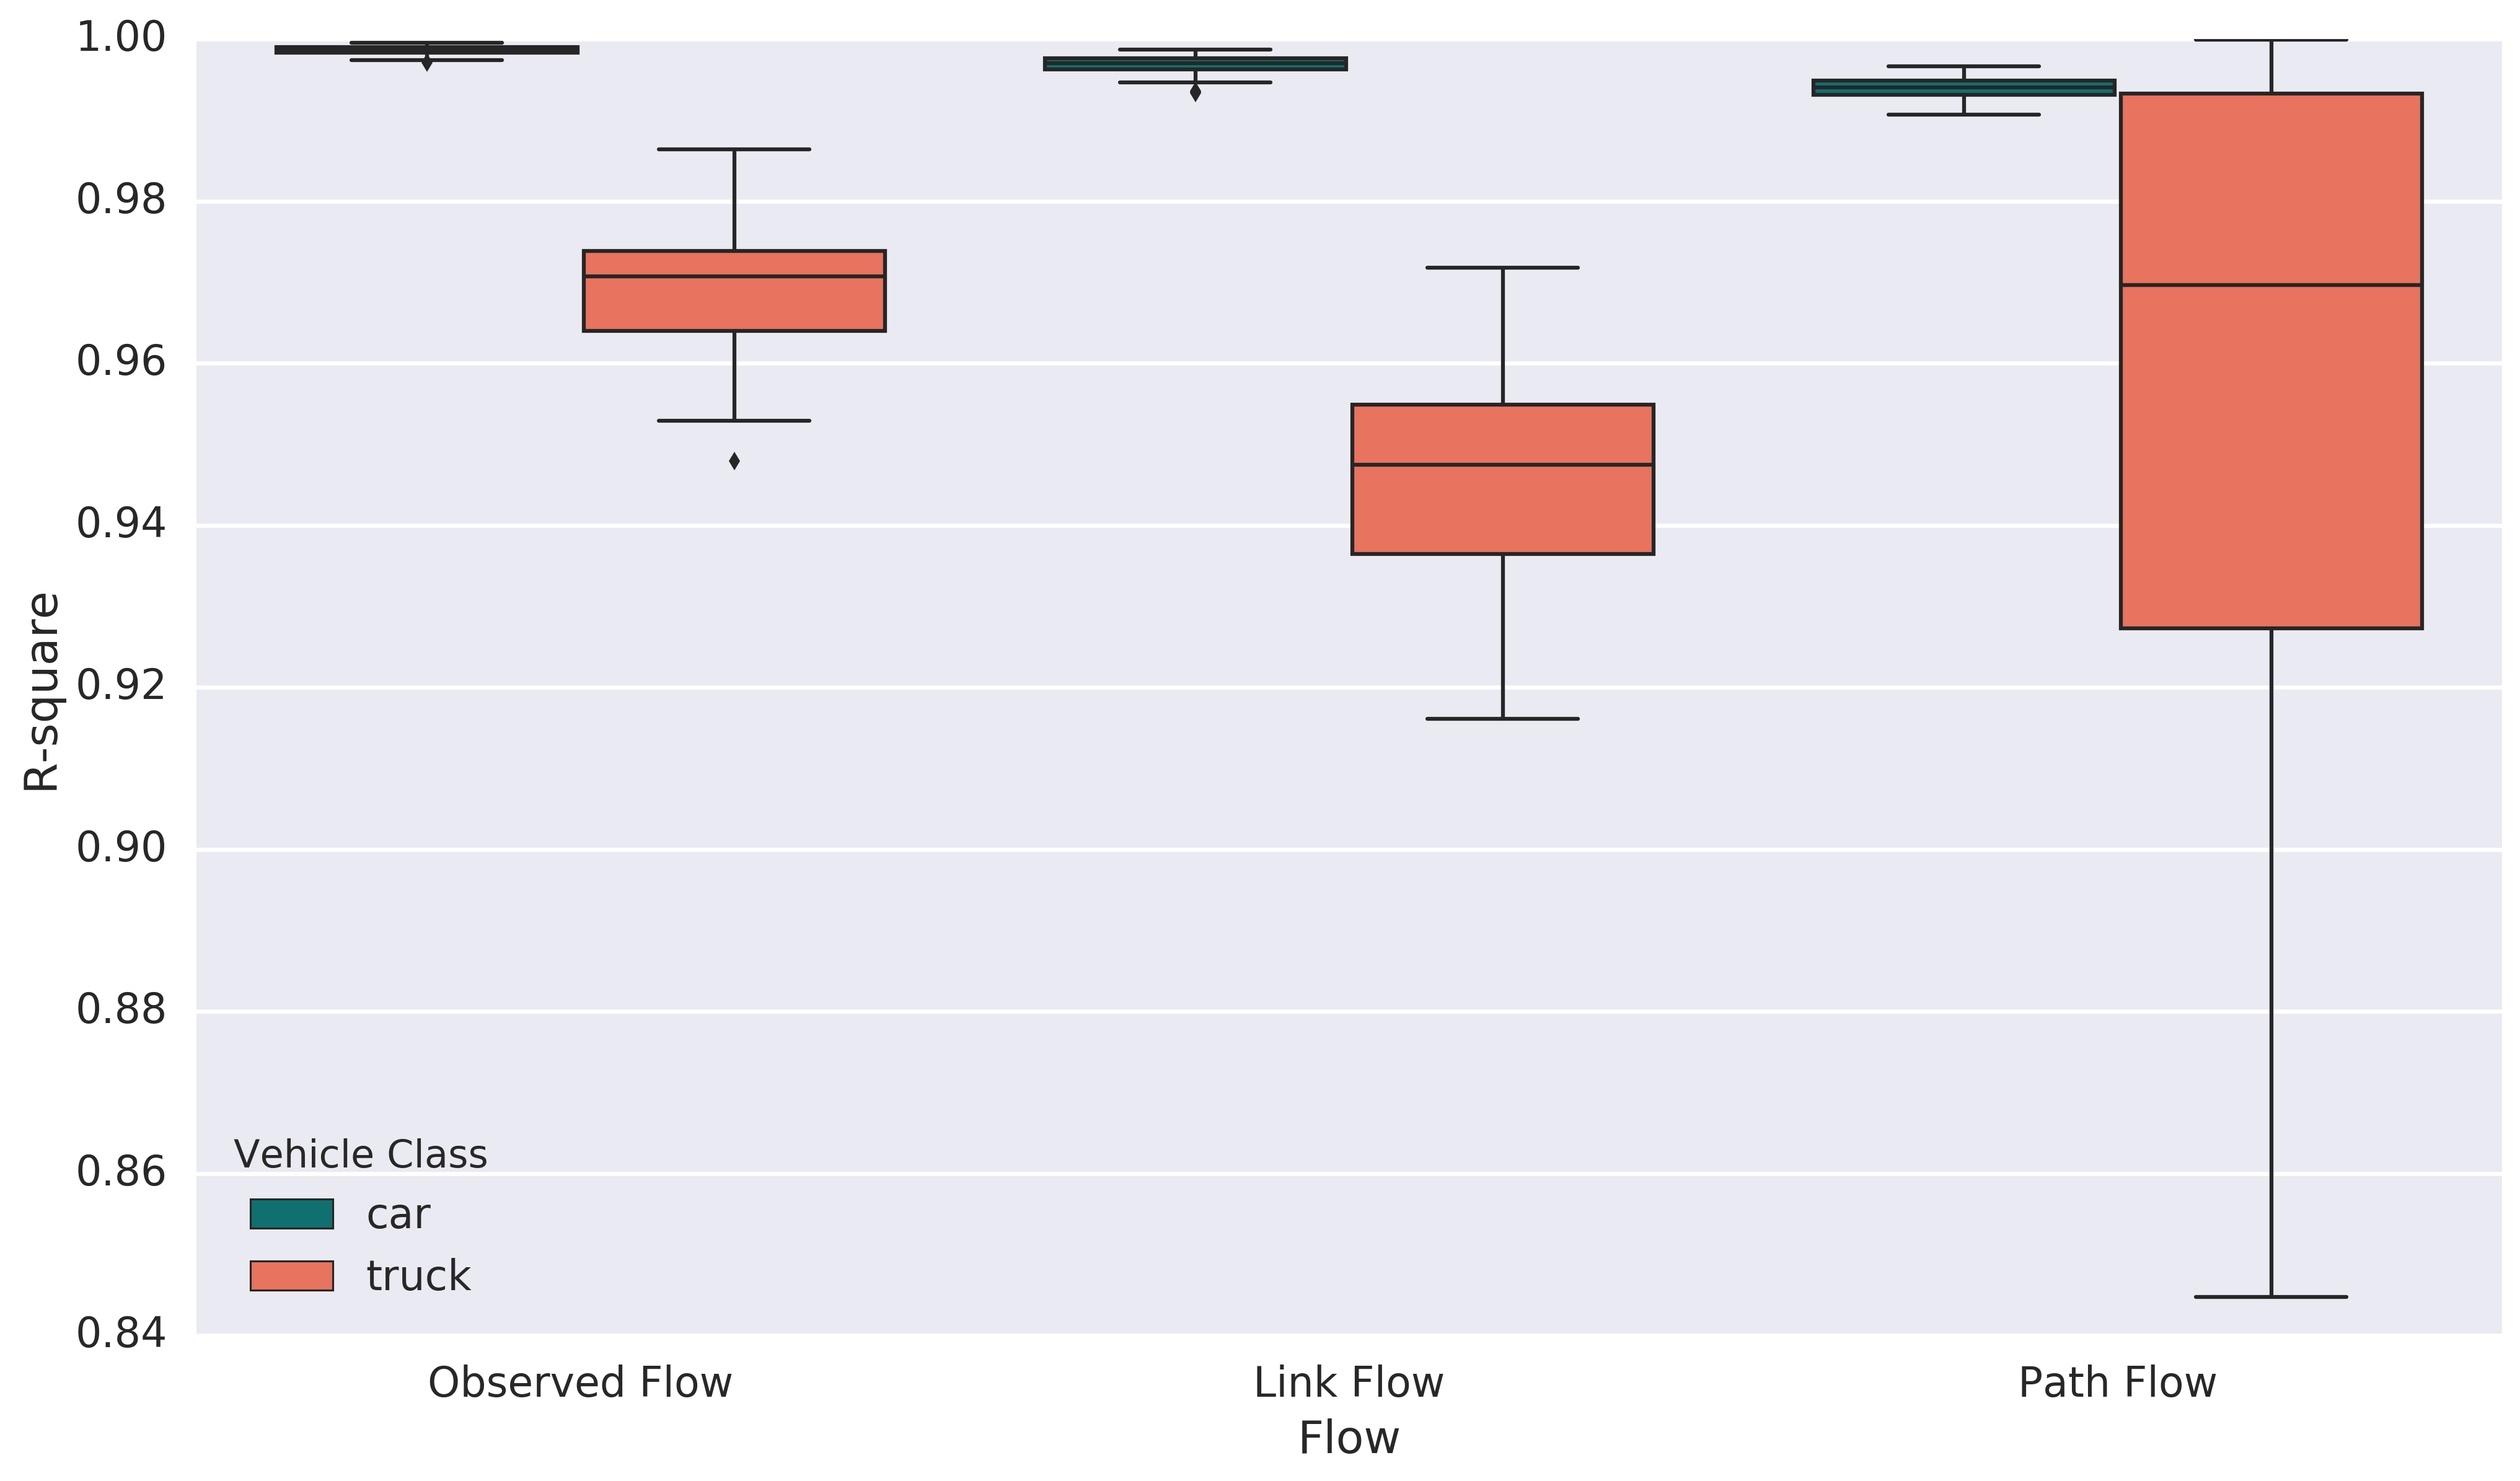

In [103]:
plt.figure(figsize = (16,9), dpi=300)
sns.boxplot(x="Flow", y="R-square", hue="Vehicle Class",
#                split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
                palette=["teal", "tomato"], linewidth=1.5, fliersize = 5,
               data=res_rdf)
plt.show()

## Different observation

In [29]:
res2_df = pd.DataFrame(index = range(100), columns = ['y_car', 'y_truck', 'x_car', 'x_truck', 'f_car', 'f_truck'])
for jjj in range(100):
    observed_link_list = [3, 4, 5, 6]
    ml_car = 6
    ml_truck = 4
    data_dict = dict()
    num_interval = nb.config.config_dict['DTA']['max_interval']
    true_car_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 100
    true_truck_f = np.random.rand(num_interval * nb.config.config_dict['FIXED']['num_path']) * 10
    # true_car_x = np.random.rand(num_interval * len(observed_link_list)) * 100
    # true_truck_x = np.random.rand(num_interval * len(observed_link_list)) * 10
    # L_car_one = np.random.randint(2, size = (ml_car, len(observed_link_list)))
    L_car_one = np.array([[1, 0, 0, 1],
                          [0, 0, 1, 1],
                          [1, 1, 0, 1],
                          [1, 0, 1, 1],
                          [1, 0, 0, 0],
                          [0, 1, 0, 0]])
    L_truck_one = np.array([[1, 0, 1, 1],
                            [0, 0, 0, 1],
                            [1, 1, 0, 1],
                            [1, 0, 0, 0]])
    # L_truck_one = np.random.randint(2, size = (ml_truck, len(observed_link_list)))
    L_car = csr_matrix(scipy.linalg.block_diag(*[L_car_one for i in range(num_interval)]))
    L_truck = csr_matrix(scipy.linalg.block_diag(*[L_truck_one for i in range(num_interval)]))

    config = dict()
    config['use_car_link_flow'] = True
    config['use_truck_link_flow'] = True
    config['use_car_link_tt'] = False
    config['use_truck_link_tt'] = False
    config['car_count_agg'] = True
    config['truck_count_agg'] = True
    config['link_car_flow_weight'] = 1
    config['link_truck_flow_weight'] = 1
    config['link_tt_weight'] = 1
    config['num_data'] = 1
    config['observed_links'] = observed_link_list
    config['paths_list'] = range(nb.config.config_dict['FIXED']['num_path'])


    dode = MCDODE(nb, config)
    dta = dode._run_simulation(true_car_f, true_truck_f)
    # (true_dar_car, true_dar_truck) = dode.get_dar(dta, true_car_f, true_truck_f)
    # true_car_x = true_dar_car.dot(true_car_f)
    # true_truck_x = true_dar_truck.dot(true_truck_f)
    true_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    true_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    m_car = L_car.dot(true_car_x)
    m_truck = L_truck.dot(true_truck_x)
    data_dict['car_count_agg_L_list'] = [L_car]
    data_dict['truck_count_agg_L_list'] = [L_truck]
    data_dict['car_link_flow'] = [m_car]
    data_dict['truck_link_flow'] = [m_truck]
    # data_dict['car_link_tt'] = [m_spd_car]
    # data_dict['truck_link_tt'] = [m_spd_truck]
    dode = MCDODE(nb, config)
    dode.add_data(data_dict)
    (car_flow, truck_flow, l_list) = dode.estimate_path_flow(max_epoch = 150, step_size = 1, car_init_scale = 5, 
                                                          truck_init_scale = 0.1, adagrad = True)
    dta = dode._run_simulation(car_flow, truck_flow)
    estimated_car_x = dta.get_link_car_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    estimated_truck_x = dta.get_link_truck_inflow(np.arange(0, dode.num_loading_interval, dode.ass_freq), 
                  np.arange(0, dode.num_loading_interval, dode.ass_freq) + dode.ass_freq).flatten(order = 'F')
    y_car = r2_score(m_car, L_car.dot(estimated_car_x))
    e_m_truck =L_truck.dot(estimated_truck_x)
    y_truck = r2_score(m_truck[e_m_truck < 50], e_m_truck[e_m_truck < 50])
    truck_flow = true_truck_f + np.random.rand(len(true_car_f)) * 2- 1
    x_car = r2_score(true_car_x, estimated_car_x)
    x_truck = r2_score(true_truck_x[estimated_truck_x<30], estimated_truck_x[estimated_truck_x<30])
    f_car =  r2_score(true_car_f[car_flow<140], car_flow[car_flow<140])
    f_truck =  r2_score(true_truck_f[truck_flow<15], truck_flow[truck_flow<15])
    res2_df.iloc[jjj] = [y_car, y_truck, x_car, x_truck, f_car, f_truck]

Epoch: 0 Loss: 1185.414669646692 1532760287.71
Epoch: 1 Loss: 1163.7675550917218 1532760287.77
Epoch: 2 Loss: 1137.778506527906 1532760287.83
Epoch: 3 Loss: 1104.0177750030532 1532760287.9
Epoch: 4 Loss: 1070.967205597349 1532760287.99
Epoch: 5 Loss: 1042.4747622968985 1532760288.08
Epoch: 6 Loss: 1019.3384294679411 1532760288.16
Epoch: 7 Loss: 998.0371517958334 1532760288.27
Epoch: 8 Loss: 982.3002841623868 1532760288.37
Epoch: 9 Loss: 962.9661262365044 1532760288.46
Epoch: 10 Loss: 947.9485525131555 1532760288.56
Epoch: 11 Loss: 926.0215946472276 1532760288.66
Epoch: 12 Loss: 910.8587180949572 1532760288.76
Epoch: 13 Loss: 892.7261942042145 1532760288.87
Epoch: 14 Loss: 876.8611642779931 1532760288.97
Epoch: 15 Loss: 854.1921835102494 1532760289.08
Epoch: 16 Loss: 841.9176791714193 1532760289.2
Epoch: 17 Loss: 823.4685899252996 1532760289.32
Epoch: 18 Loss: 804.3487861482818 1532760289.44
Epoch: 19 Loss: 795.3105355375521 1532760289.58
Epoch: 20 Loss: 773.275086603494 1532760289.75
E

Epoch: 21 Loss: 567.5657269288151 1532760319.2
Epoch: 22 Loss: 548.6908014194363 1532760319.32
Epoch: 23 Loss: 535.0097522880652 1532760319.44
Epoch: 24 Loss: 513.3102997884276 1532760319.58
Epoch: 25 Loss: 501.4474351112243 1532760319.72
Epoch: 26 Loss: 489.6964653116428 1532760319.85
Epoch: 27 Loss: 470.15813788177303 1532760319.99
Epoch: 28 Loss: 452.9982444781399 1532760320.12
Epoch: 29 Loss: 444.9315782682331 1532760320.26
Epoch: 30 Loss: 426.23814204039223 1532760320.4
Epoch: 31 Loss: 421.72149019189266 1532760320.55
Epoch: 32 Loss: 397.6454791772984 1532760320.69
Epoch: 33 Loss: 395.59669336733833 1532760320.84
Epoch: 34 Loss: 376.4350084433136 1532760320.99
Epoch: 35 Loss: 359.4628208724635 1532760321.14
Epoch: 36 Loss: 348.7037409959012 1532760321.29
Epoch: 37 Loss: 344.70529254531874 1532760321.45
Epoch: 38 Loss: 328.65159275564235 1532760321.61
Epoch: 39 Loss: 318.59516752137506 1532760321.76
Epoch: 40 Loss: 308.0833813807484 1532760321.92
Epoch: 41 Loss: 290.67797027113613 

Epoch: 41 Loss: 535.1836031847788 1532760347.34
Epoch: 42 Loss: 521.7198440781792 1532760347.5
Epoch: 43 Loss: 510.006474417102 1532760347.68
Epoch: 44 Loss: 505.6894718105809 1532760347.85
Epoch: 45 Loss: 491.5750669493287 1532760348.02
Epoch: 46 Loss: 474.4555147946905 1532760348.2
Epoch: 47 Loss: 465.2475834692499 1532760348.38
Epoch: 48 Loss: 446.99349136381124 1532760348.56
Epoch: 49 Loss: 440.3828060911101 1532760348.74
Epoch: 50 Loss: 424.5848881649941 1532760348.92
Epoch: 51 Loss: 411.0836334180878 1532760349.1
Epoch: 52 Loss: 399.7836021581049 1532760349.29
Epoch: 53 Loss: 387.42937182050815 1532760349.47
Epoch: 54 Loss: 377.79397349233926 1532760349.66
Epoch: 55 Loss: 365.6614974755403 1532760349.84
Epoch: 56 Loss: 356.3033056831274 1532760350.03
Epoch: 57 Loss: 345.13003320741586 1532760350.22
Epoch: 58 Loss: 334.3370220194822 1532760350.41
Epoch: 59 Loss: 326.0109479965054 1532760350.6
Epoch: 60 Loss: 317.0252458974478 1532760350.79
Epoch: 61 Loss: 303.9848796707283 1532760

Epoch: 60 Loss: 116.13533954098446 1532760378.8
Epoch: 61 Loss: 109.32187254821926 1532760378.99
Epoch: 62 Loss: 102.30325982323063 1532760379.2
Epoch: 63 Loss: 106.06615086802819 1532760379.4
Epoch: 64 Loss: 102.77762553557076 1532760379.59
Epoch: 65 Loss: 96.79126157837575 1532760379.79
Epoch: 66 Loss: 94.21815024064105 1532760379.98
Epoch: 67 Loss: 92.27610938039493 1532760380.17
Epoch: 68 Loss: 89.95809467167297 1532760380.37
Epoch: 69 Loss: 85.92305392156209 1532760380.56
Epoch: 70 Loss: 82.67119012194713 1532760380.78
Epoch: 71 Loss: 75.01985173125938 1532760380.97
Epoch: 72 Loss: 72.81793127024403 1532760381.17
Epoch: 73 Loss: 69.9305493608642 1532760381.36
Epoch: 74 Loss: 73.6578915593245 1532760381.54
Epoch: 75 Loss: 63.987536366766655 1532760381.73
Epoch: 76 Loss: 64.06262413746165 1532760381.91
Epoch: 77 Loss: 61.51173901391348 1532760382.09
Epoch: 78 Loss: 54.53495209072589 1532760382.28
Epoch: 79 Loss: 53.292589774250935 1532760382.47
Epoch: 80 Loss: 51.95217494955665 1532

Epoch: 81 Loss: 56.608958841892175 1532760407.34
Epoch: 82 Loss: 53.95764827204934 1532760407.52
Epoch: 83 Loss: 54.032060179963324 1532760407.7
Epoch: 84 Loss: 53.957428142592434 1532760407.87
Epoch: 85 Loss: 52.84552628563924 1532760408.05
Epoch: 86 Loss: 47.31959786221873 1532760408.23
Epoch: 87 Loss: 49.51274286901247 1532760408.4
Epoch: 88 Loss: 48.950822651458935 1532760408.58
Epoch: 89 Loss: 54.16669362676113 1532760408.77
Epoch: 90 Loss: 48.48323367827384 1532760408.95
Epoch: 91 Loss: 45.15950850490302 1532760409.13
Epoch: 92 Loss: 42.94836467865586 1532760409.31
Epoch: 93 Loss: 50.38914151098925 1532760409.49
Epoch: 94 Loss: 41.14591066892263 1532760409.67
Epoch: 95 Loss: 40.55097367256866 1532760409.84
Epoch: 96 Loss: 45.601028586367356 1532760410.02
Epoch: 97 Loss: 46.36344149895318 1532760410.2
Epoch: 98 Loss: 34.00544173976172 1532760410.37
Epoch: 99 Loss: 32.937918775354206 1532760410.55
Epoch: 100 Loss: 35.62249080971877 1532760410.73
Epoch: 101 Loss: 31.265545932266406 

Epoch: 101 Loss: 37.15193401593562 1532760435.69
Epoch: 102 Loss: 26.114448471007346 1532760435.87
Epoch: 103 Loss: 27.22644805171401 1532760436.05
Epoch: 104 Loss: 32.781711520849925 1532760436.24
Epoch: 105 Loss: 28.586159952550673 1532760436.42
Epoch: 106 Loss: 33.358542099364726 1532760436.6
Epoch: 107 Loss: 36.770772952904835 1532760436.79
Epoch: 108 Loss: 35.80391632205997 1532760436.97
Epoch: 109 Loss: 33.05986563426989 1532760437.15
Epoch: 110 Loss: 34.61234613969126 1532760437.34
Epoch: 111 Loss: 28.04293186936153 1532760437.52
Epoch: 112 Loss: 34.69409478771689 1532760437.7
Epoch: 113 Loss: 30.289150297593135 1532760437.89
Epoch: 114 Loss: 30.632297291732243 1532760438.07
Epoch: 115 Loss: 29.63906160431643 1532760438.26
Epoch: 116 Loss: 37.57917356066648 1532760438.44
Epoch: 117 Loss: 29.94402799726379 1532760438.63
Epoch: 118 Loss: 33.72306330751531 1532760438.81
Epoch: 119 Loss: 32.80319535718375 1532760439.0
Epoch: 120 Loss: 36.603825217023754 1532760439.19
Epoch: 121 Loss

Epoch: 120 Loss: 24.44357821686626 1532760465.14
Epoch: 121 Loss: 32.64288210019128 1532760465.34
Epoch: 122 Loss: 32.23985128987877 1532760465.54
Epoch: 123 Loss: 27.791701401539 1532760465.73
Epoch: 124 Loss: 36.154709072654086 1532760465.93
Epoch: 125 Loss: 31.194263056846232 1532760466.13
Epoch: 126 Loss: 33.06654480052778 1532760466.33
Epoch: 127 Loss: 30.6126755356454 1532760466.52
Epoch: 128 Loss: 30.394407179994957 1532760466.72
Epoch: 129 Loss: 35.854437733037535 1532760466.92
Epoch: 130 Loss: 31.1783055500429 1532760467.12
Epoch: 131 Loss: 27.24726432803594 1532760467.33
Epoch: 132 Loss: 35.66835072458153 1532760467.52
Epoch: 133 Loss: 34.72544203188188 1532760467.72
Epoch: 134 Loss: 36.79080531912281 1532760467.91
Epoch: 135 Loss: 32.37995464375789 1532760468.11
Epoch: 136 Loss: 30.231323383331187 1532760468.3
Epoch: 137 Loss: 30.53233851308067 1532760468.49
Epoch: 138 Loss: 35.343383066035976 1532760468.69
Epoch: 139 Loss: 35.16905998799111 1532760468.89
Epoch: 140 Loss: 24

Epoch: 140 Loss: 35.06867437676268 1532760494.49
Epoch: 141 Loss: 28.225003669395477 1532760494.68
Epoch: 142 Loss: 31.67561939985858 1532760494.87
Epoch: 143 Loss: 29.31409788404163 1532760495.06
Epoch: 144 Loss: 31.175215716801475 1532760495.25
Epoch: 145 Loss: 34.14838396616967 1532760495.44
Epoch: 146 Loss: 43.64821682474354 1532760495.62
Epoch: 147 Loss: 32.083938534311805 1532760495.81
Epoch: 148 Loss: 28.85252937414551 1532760496.0
Epoch: 149 Loss: 28.61354668111474 1532760496.19
Epoch: 0 Loss: 1032.2164404087273 1532760496.59
Epoch: 1 Loss: 1005.634584971196 1532760496.65
Epoch: 2 Loss: 974.5155413939882 1532760496.72
Epoch: 3 Loss: 947.0312406513577 1532760496.79
Epoch: 4 Loss: 914.8765051849089 1532760496.87
Epoch: 5 Loss: 887.1308834097438 1532760496.95
Epoch: 6 Loss: 866.2201507695443 1532760497.04
Epoch: 7 Loss: 848.0791171116484 1532760497.13
Epoch: 8 Loss: 826.4500652015415 1532760497.22
Epoch: 9 Loss: 811.5463792446308 1532760497.32
Epoch: 10 Loss: 790.3291833840741 153

Epoch: 10 Loss: 910.037392389599 1532760522.78
Epoch: 11 Loss: 896.9581176664278 1532760522.88
Epoch: 12 Loss: 873.9952281403342 1532760522.98
Epoch: 13 Loss: 861.0431262316221 1532760523.09
Epoch: 14 Loss: 843.3800891770733 1532760523.2
Epoch: 15 Loss: 831.1266523719967 1532760523.3
Epoch: 16 Loss: 812.4950901443577 1532760523.42
Epoch: 17 Loss: 793.5886544169977 1532760523.53
Epoch: 18 Loss: 770.6031177306716 1532760523.65
Epoch: 19 Loss: 753.9809295253425 1532760523.77
Epoch: 20 Loss: 744.7837524090003 1532760523.89
Epoch: 21 Loss: 727.460621798095 1532760524.01
Epoch: 22 Loss: 702.3476780621743 1532760524.14
Epoch: 23 Loss: 691.0878968458426 1532760524.27
Epoch: 24 Loss: 667.293381666393 1532760524.4
Epoch: 25 Loss: 652.6310050388089 1532760524.54
Epoch: 26 Loss: 623.7775310317123 1532760524.67
Epoch: 27 Loss: 609.2117695804245 1532760524.81
Epoch: 28 Loss: 586.170866256677 1532760524.95
Epoch: 29 Loss: 571.6222895815007 1532760525.09
Epoch: 30 Loss: 556.6899202821738 1532760525.23

Epoch: 31 Loss: 535.9630042880952 1532760550.12
Epoch: 32 Loss: 517.995645587111 1532760550.27
Epoch: 33 Loss: 508.3570805162228 1532760550.42
Epoch: 34 Loss: 488.9700175372979 1532760550.57
Epoch: 35 Loss: 475.1516964525482 1532760550.74
Epoch: 36 Loss: 453.5327002160536 1532760550.9
Epoch: 37 Loss: 436.21347862160997 1532760551.06
Epoch: 38 Loss: 420.9694889058922 1532760551.22
Epoch: 39 Loss: 408.03710055642017 1532760551.39
Epoch: 40 Loss: 392.06042589561093 1532760551.55
Epoch: 41 Loss: 373.97616149132045 1532760551.71
Epoch: 42 Loss: 362.5550157613219 1532760551.88
Epoch: 43 Loss: 349.6613001913836 1532760552.05
Epoch: 44 Loss: 339.96461558355907 1532760552.21
Epoch: 45 Loss: 313.504064306359 1532760552.38
Epoch: 46 Loss: 306.32263044157605 1532760552.55
Epoch: 47 Loss: 293.3324122864637 1532760552.71
Epoch: 48 Loss: 279.65339414613345 1532760552.88
Epoch: 49 Loss: 263.8606970743998 1532760553.05
Epoch: 50 Loss: 245.94014205020488 1532760553.23
Epoch: 51 Loss: 247.66488460059418 

Epoch: 50 Loss: 171.9250322681592 1532760578.75
Epoch: 51 Loss: 168.6995248252696 1532760578.91
Epoch: 52 Loss: 158.8290496387601 1532760579.08
Epoch: 53 Loss: 144.08546341980616 1532760579.25
Epoch: 54 Loss: 138.2942621591266 1532760579.42
Epoch: 55 Loss: 132.148061417019 1532760579.58
Epoch: 56 Loss: 124.41074145070556 1532760579.75
Epoch: 57 Loss: 114.66158147327883 1532760579.93
Epoch: 58 Loss: 110.83001641247567 1532760580.09
Epoch: 59 Loss: 113.93919642465451 1532760580.26
Epoch: 60 Loss: 102.40655874323743 1532760580.45
Epoch: 61 Loss: 101.19875750824175 1532760580.62
Epoch: 62 Loss: 96.89772354380344 1532760580.79
Epoch: 63 Loss: 95.07172545192155 1532760580.97
Epoch: 64 Loss: 88.3150443884168 1532760581.17
Epoch: 65 Loss: 91.47644949309777 1532760581.35
Epoch: 66 Loss: 88.86624934789526 1532760581.55
Epoch: 67 Loss: 82.15008053109449 1532760581.72
Epoch: 68 Loss: 81.37599804486564 1532760581.9
Epoch: 69 Loss: 82.0888000222781 1532760582.07
Epoch: 70 Loss: 76.80869526317241 153

Epoch: 70 Loss: 102.29102979064649 1532760605.87
Epoch: 71 Loss: 95.86969420958178 1532760606.04
Epoch: 72 Loss: 84.17664398095276 1532760606.2
Epoch: 73 Loss: 87.85134790329937 1532760606.37
Epoch: 74 Loss: 86.50998862794174 1532760606.54
Epoch: 75 Loss: 80.6620514299581 1532760606.7
Epoch: 76 Loss: 72.26420417944382 1532760606.87
Epoch: 77 Loss: 62.64201175029645 1532760607.03
Epoch: 78 Loss: 66.35791399047129 1532760607.2
Epoch: 79 Loss: 59.514599211342016 1532760607.36
Epoch: 80 Loss: 48.84895214300248 1532760607.53
Epoch: 81 Loss: 49.9569366537301 1532760607.7
Epoch: 82 Loss: 46.382266728760314 1532760607.87
Epoch: 83 Loss: 44.58247279546172 1532760608.03
Epoch: 84 Loss: 44.34312818061889 1532760608.2
Epoch: 85 Loss: 36.5223998289135 1532760608.36
Epoch: 86 Loss: 43.893360677444825 1532760608.53
Epoch: 87 Loss: 48.75771432876666 1532760608.7
Epoch: 88 Loss: 36.850981006185386 1532760608.86
Epoch: 89 Loss: 39.998301574759495 1532760609.05
Epoch: 90 Loss: 34.73844473510583 153276060

Epoch: 90 Loss: 35.40788174364949 1532760633.96
Epoch: 91 Loss: 41.89772328081535 1532760634.16
Epoch: 92 Loss: 36.804973157728064 1532760634.36
Epoch: 93 Loss: 35.71480064619013 1532760634.55
Epoch: 94 Loss: 30.140340674580756 1532760634.75
Epoch: 95 Loss: 31.250466480919783 1532760634.95
Epoch: 96 Loss: 45.76891787160688 1532760635.14
Epoch: 97 Loss: 29.223453422785525 1532760635.34
Epoch: 98 Loss: 31.384875412013244 1532760635.55
Epoch: 99 Loss: 32.343271930090744 1532760635.75
Epoch: 100 Loss: 40.83750218469018 1532760635.95
Epoch: 101 Loss: 34.87013860954477 1532760636.15
Epoch: 102 Loss: 32.67726632212729 1532760636.35
Epoch: 103 Loss: 27.292311128025467 1532760636.55
Epoch: 104 Loss: 35.46224553950329 1532760636.75
Epoch: 105 Loss: 32.454264743530175 1532760636.94
Epoch: 106 Loss: 31.326274037610055 1532760637.14
Epoch: 107 Loss: 41.90647355078073 1532760637.33
Epoch: 108 Loss: 32.18070486499733 1532760637.52
Epoch: 109 Loss: 36.87505668529938 1532760637.73
Epoch: 110 Loss: 36.8

Epoch: 109 Loss: 41.55581746988295 1532760665.34
Epoch: 110 Loss: 32.45645539766403 1532760665.54
Epoch: 111 Loss: 35.98320274627236 1532760665.75
Epoch: 112 Loss: 39.3592973553186 1532760665.96
Epoch: 113 Loss: 43.197654275218525 1532760666.17
Epoch: 114 Loss: 38.48501946748841 1532760666.38
Epoch: 115 Loss: 45.44406447501058 1532760666.59
Epoch: 116 Loss: 34.56783808282453 1532760666.81
Epoch: 117 Loss: 38.31084200477887 1532760667.03
Epoch: 118 Loss: 34.216915957435646 1532760667.24
Epoch: 119 Loss: 35.33623767325878 1532760667.45
Epoch: 120 Loss: 30.45615789868483 1532760667.65
Epoch: 121 Loss: 42.41785952969699 1532760667.85
Epoch: 122 Loss: 33.320216694618 1532760668.05
Epoch: 123 Loss: 37.90157998453954 1532760668.25
Epoch: 124 Loss: 35.63973758249313 1532760668.45
Epoch: 125 Loss: 43.343814816481455 1532760668.65
Epoch: 126 Loss: 27.710211520109475 1532760668.86
Epoch: 127 Loss: 34.827153271774506 1532760669.07
Epoch: 128 Loss: 35.55104082796278 1532760669.28
Epoch: 129 Loss: 3

Epoch: 128 Loss: 37.93152161218489 1532760697.33
Epoch: 129 Loss: 39.34448425984567 1532760697.54
Epoch: 130 Loss: 40.63491356827376 1532760697.75
Epoch: 131 Loss: 36.039344660862604 1532760697.96
Epoch: 132 Loss: 44.28212809990147 1532760698.17
Epoch: 133 Loss: 31.01010697591689 1532760698.39
Epoch: 134 Loss: 45.2162819271268 1532760698.64
Epoch: 135 Loss: 33.62862646045214 1532760698.88
Epoch: 136 Loss: 28.18079869268301 1532760699.11
Epoch: 137 Loss: 37.70057041429291 1532760699.35
Epoch: 138 Loss: 31.73576801522561 1532760699.6
Epoch: 139 Loss: 34.66628388591813 1532760699.84
Epoch: 140 Loss: 26.56183998687601 1532760700.06
Epoch: 141 Loss: 34.986120742036476 1532760700.29
Epoch: 142 Loss: 37.9136766635513 1532760700.54
Epoch: 143 Loss: 33.921082052363815 1532760700.77
Epoch: 144 Loss: 44.78467702235482 1532760700.99
Epoch: 145 Loss: 35.583818156228176 1532760701.24
Epoch: 146 Loss: 35.656734949616045 1532760701.47
Epoch: 147 Loss: 34.47894604513167 1532760701.69
Epoch: 148 Loss: 3

Epoch: 147 Loss: 29.82189907504088 1532760729.62
Epoch: 148 Loss: 36.931859944766146 1532760729.84
Epoch: 149 Loss: 29.00728328239027 1532760730.05
Epoch: 0 Loss: 1157.7594123134895 1532760730.51
Epoch: 1 Loss: 1130.6153105208105 1532760730.59
Epoch: 2 Loss: 1102.1743156521243 1532760730.67
Epoch: 3 Loss: 1069.52018498349 1532760730.75
Epoch: 4 Loss: 1044.0022783515353 1532760730.82
Epoch: 5 Loss: 1013.4388358839317 1532760730.91
Epoch: 6 Loss: 985.896671075518 1532760731.0
Epoch: 7 Loss: 961.3854726323277 1532760731.09
Epoch: 8 Loss: 945.4911186934828 1532760731.19
Epoch: 9 Loss: 925.757153538675 1532760731.28
Epoch: 10 Loss: 909.1213845262705 1532760731.38
Epoch: 11 Loss: 889.0626300515942 1532760731.48
Epoch: 12 Loss: 873.0246738881758 1532760731.58
Epoch: 13 Loss: 856.3696250432083 1532760731.68
Epoch: 14 Loss: 836.9382746220973 1532760731.79
Epoch: 15 Loss: 815.7718654395159 1532760731.9
Epoch: 16 Loss: 802.7400082317099 1532760732.02
Epoch: 17 Loss: 784.130807415256 1532760732.14

Epoch: 18 Loss: 715.7761543680815 1532760760.05
Epoch: 19 Loss: 698.4430488077736 1532760760.17
Epoch: 20 Loss: 686.710855563326 1532760760.29
Epoch: 21 Loss: 664.9576530039515 1532760760.42
Epoch: 22 Loss: 654.2641255916253 1532760760.54
Epoch: 23 Loss: 634.1260540332041 1532760760.67
Epoch: 24 Loss: 624.8985472308384 1532760760.81
Epoch: 25 Loss: 610.8209859128539 1532760760.94
Epoch: 26 Loss: 591.9816949485801 1532760761.08
Epoch: 27 Loss: 584.9738331359763 1532760761.21
Epoch: 28 Loss: 560.6975000054009 1532760761.36
Epoch: 29 Loss: 550.9776229635733 1532760761.5
Epoch: 30 Loss: 538.7859670060124 1532760761.65
Epoch: 31 Loss: 518.095873832894 1532760761.8
Epoch: 32 Loss: 499.2895154218023 1532760761.95
Epoch: 33 Loss: 498.9118748807774 1532760762.1
Epoch: 34 Loss: 474.94815721910834 1532760762.26
Epoch: 35 Loss: 468.70940672698805 1532760762.42
Epoch: 36 Loss: 450.60093817342243 1532760762.57
Epoch: 37 Loss: 443.4461328009319 1532760762.74
Epoch: 38 Loss: 433.63507517490166 1532760

Epoch: 38 Loss: 177.33608387707739 1532760791.86
Epoch: 39 Loss: 168.77678142907928 1532760792.03
Epoch: 40 Loss: 153.49243742037552 1532760792.18
Epoch: 41 Loss: 145.7147483276934 1532760792.34
Epoch: 42 Loss: 139.34125619822368 1532760792.5
Epoch: 43 Loss: 127.63715921706795 1532760792.67
Epoch: 44 Loss: 120.9902308624243 1532760792.84
Epoch: 45 Loss: 117.76181464735181 1532760793.0
Epoch: 46 Loss: 107.89369576653131 1532760793.18
Epoch: 47 Loss: 102.66511554467743 1532760793.34
Epoch: 48 Loss: 96.5416516622547 1532760793.51
Epoch: 49 Loss: 94.64861451737683 1532760793.68
Epoch: 50 Loss: 87.01466134499515 1532760793.84
Epoch: 51 Loss: 86.71031029295537 1532760794.0
Epoch: 52 Loss: 80.95535342611498 1532760794.16
Epoch: 53 Loss: 76.38256729733786 1532760794.32
Epoch: 54 Loss: 71.85714581240661 1532760794.47
Epoch: 55 Loss: 70.02651197000756 1532760794.63
Epoch: 56 Loss: 64.85755355742754 1532760794.79
Epoch: 57 Loss: 65.52020868055281 1532760794.95
Epoch: 58 Loss: 63.42768613856988 15

Epoch: 59 Loss: 198.07214140843234 1532760817.79
Epoch: 60 Loss: 197.02100415012524 1532760817.96
Epoch: 61 Loss: 185.56686746344366 1532760818.14
Epoch: 62 Loss: 184.3048861717377 1532760818.31
Epoch: 63 Loss: 173.6079039461361 1532760818.49
Epoch: 64 Loss: 173.74714615313871 1532760818.66
Epoch: 65 Loss: 158.05514427043934 1532760818.83
Epoch: 66 Loss: 156.87402460436746 1532760819.01
Epoch: 67 Loss: 155.31774263237733 1532760819.18
Epoch: 68 Loss: 145.19996571247657 1532760819.35
Epoch: 69 Loss: 148.4343292841807 1532760819.53
Epoch: 70 Loss: 126.08018210146055 1532760819.7
Epoch: 71 Loss: 130.35025246841485 1532760819.88
Epoch: 72 Loss: 119.39862613179419 1532760820.06
Epoch: 73 Loss: 112.329249433673 1532760820.24
Epoch: 74 Loss: 99.403250911758 1532760820.41
Epoch: 75 Loss: 101.8910628447677 1532760820.59
Epoch: 76 Loss: 100.37837679058934 1532760820.76
Epoch: 77 Loss: 100.15687414805146 1532760820.94
Epoch: 78 Loss: 92.03206699951897 1532760821.12
Epoch: 79 Loss: 86.408637452290

Epoch: 78 Loss: 62.70957175102206 1532760845.3
Epoch: 79 Loss: 51.82788892403302 1532760845.47
Epoch: 80 Loss: 53.03843473909266 1532760845.65
Epoch: 81 Loss: 46.2238163928663 1532760845.82
Epoch: 82 Loss: 50.1413591007998 1532760845.99
Epoch: 83 Loss: 45.807296064918795 1532760846.17
Epoch: 84 Loss: 45.49550949363389 1532760846.34
Epoch: 85 Loss: 38.72475083913424 1532760846.52
Epoch: 86 Loss: 35.86080225038783 1532760846.69
Epoch: 87 Loss: 39.66588420895573 1532760846.86
Epoch: 88 Loss: 40.22176397525401 1532760847.04
Epoch: 89 Loss: 38.345357318632594 1532760847.21
Epoch: 90 Loss: 33.71649291993904 1532760847.38
Epoch: 91 Loss: 34.32673025497975 1532760847.55
Epoch: 92 Loss: 31.902940980783434 1532760847.72
Epoch: 93 Loss: 36.1696879646627 1532760847.91
Epoch: 94 Loss: 27.543661224835297 1532760848.1
Epoch: 95 Loss: 31.807806958029843 1532760848.28
Epoch: 96 Loss: 33.12402753192541 1532760848.45
Epoch: 97 Loss: 31.2695803765955 1532760848.62
Epoch: 98 Loss: 31.271762441591278 153276

Epoch: 98 Loss: 39.862516327440275 1532760874.01
Epoch: 99 Loss: 40.466549289002025 1532760874.21
Epoch: 100 Loss: 37.04666204392212 1532760874.41
Epoch: 101 Loss: 42.34891909972849 1532760874.61
Epoch: 102 Loss: 40.923997664905826 1532760874.81
Epoch: 103 Loss: 39.76177208138405 1532760875.01
Epoch: 104 Loss: 36.057078217769806 1532760875.21
Epoch: 105 Loss: 41.017331191103416 1532760875.41
Epoch: 106 Loss: 33.735629416744494 1532760875.61
Epoch: 107 Loss: 38.61176671797593 1532760875.81
Epoch: 108 Loss: 39.83348334515008 1532760876.01
Epoch: 109 Loss: 38.64612295554413 1532760876.21
Epoch: 110 Loss: 36.188126822588856 1532760876.41
Epoch: 111 Loss: 38.90622442262513 1532760876.61
Epoch: 112 Loss: 36.751831380008916 1532760876.81
Epoch: 113 Loss: 36.32325774560405 1532760877.01
Epoch: 114 Loss: 28.156085794174103 1532760877.21
Epoch: 115 Loss: 33.28237887055311 1532760877.4
Epoch: 116 Loss: 38.85332718306634 1532760877.6
Epoch: 117 Loss: 35.160633552217114 1532760877.8
Epoch: 118 Loss

Epoch: 118 Loss: 37.557025716684805 1532760903.29
Epoch: 119 Loss: 32.938693140503 1532760903.48
Epoch: 120 Loss: 38.25719875498409 1532760903.66
Epoch: 121 Loss: 31.872799976956273 1532760903.85
Epoch: 122 Loss: 32.73257948430022 1532760904.04
Epoch: 123 Loss: 41.5108803672072 1532760904.22
Epoch: 124 Loss: 32.753683155375576 1532760904.41
Epoch: 125 Loss: 27.14419213924579 1532760904.6
Epoch: 126 Loss: 34.16734243761763 1532760904.79
Epoch: 127 Loss: 40.65588960533529 1532760904.98
Epoch: 128 Loss: 37.293811927947786 1532760905.17
Epoch: 129 Loss: 31.30023554573612 1532760905.35
Epoch: 130 Loss: 31.068248523953788 1532760905.54
Epoch: 131 Loss: 43.80762847397325 1532760905.73
Epoch: 132 Loss: 33.86451141869379 1532760905.91
Epoch: 133 Loss: 32.2118947026476 1532760906.1
Epoch: 134 Loss: 32.93505127087462 1532760906.29
Epoch: 135 Loss: 35.35235977867099 1532760906.47
Epoch: 136 Loss: 27.523858066080358 1532760906.66
Epoch: 137 Loss: 34.402364899181386 1532760906.85
Epoch: 138 Loss: 33

Epoch: 138 Loss: 31.17770699603645 1532760932.51
Epoch: 139 Loss: 33.00149214299195 1532760932.7
Epoch: 140 Loss: 35.842603296406985 1532760932.89
Epoch: 141 Loss: 31.509568454899338 1532760933.08
Epoch: 142 Loss: 34.47211523706232 1532760933.28
Epoch: 143 Loss: 29.714624345334123 1532760933.47
Epoch: 144 Loss: 36.22720292843249 1532760933.66
Epoch: 145 Loss: 31.84342931201936 1532760933.85
Epoch: 146 Loss: 27.82078448160591 1532760934.04
Epoch: 147 Loss: 36.36849793624265 1532760934.23
Epoch: 148 Loss: 34.32299443807204 1532760934.42
Epoch: 149 Loss: 34.47339515209572 1532760934.61
Epoch: 0 Loss: 1066.1827158854653 1532760935.0
Epoch: 1 Loss: 1041.0422626425711 1532760935.06
Epoch: 2 Loss: 1014.1130611974984 1532760935.12
Epoch: 3 Loss: 979.7165326400461 1532760935.19
Epoch: 4 Loss: 948.3038013536259 1532760935.26
Epoch: 5 Loss: 915.4151209409534 1532760935.35
Epoch: 6 Loss: 888.5540592770783 1532760935.43
Epoch: 7 Loss: 863.1316765879221 1532760935.52
Epoch: 8 Loss: 847.8893230925385

Epoch: 7 Loss: 920.3101890055534 1532760959.1
Epoch: 8 Loss: 902.0397756720334 1532760959.19
Epoch: 9 Loss: 888.281732880885 1532760959.28
Epoch: 10 Loss: 864.7185737152013 1532760959.38
Epoch: 11 Loss: 845.04390052744 1532760959.48
Epoch: 12 Loss: 829.8705341320102 1532760959.58
Epoch: 13 Loss: 808.2559859850708 1532760959.69
Epoch: 14 Loss: 790.3167303949341 1532760959.79
Epoch: 15 Loss: 776.4450407833291 1532760959.9
Epoch: 16 Loss: 757.358282815307 1532760960.01
Epoch: 17 Loss: 738.4707529101042 1532760960.13
Epoch: 18 Loss: 720.7627827801889 1532760960.24
Epoch: 19 Loss: 705.9666564185014 1532760960.36
Epoch: 20 Loss: 682.4864805824271 1532760960.48
Epoch: 21 Loss: 670.7939636553981 1532760960.6
Epoch: 22 Loss: 654.25841086316 1532760960.72
Epoch: 23 Loss: 631.9408815647247 1532760960.85
Epoch: 24 Loss: 613.477084165176 1532760960.98
Epoch: 25 Loss: 603.8245584297001 1532760961.11
Epoch: 26 Loss: 583.5340766118092 1532760961.24
Epoch: 27 Loss: 570.6555771865513 1532760961.37
Epoch

Epoch: 28 Loss: 559.3725440300507 1532760986.08
Epoch: 29 Loss: 536.3119535630149 1532760986.22
Epoch: 30 Loss: 528.1998133670849 1532760986.37
Epoch: 31 Loss: 507.9538027010077 1532760986.52
Epoch: 32 Loss: 501.270343471503 1532760986.66
Epoch: 33 Loss: 481.61950507582696 1532760986.81
Epoch: 34 Loss: 465.19979120895107 1532760986.97
Epoch: 35 Loss: 445.7857430397003 1532760987.12
Epoch: 36 Loss: 446.47967510553667 1532760987.27
Epoch: 37 Loss: 427.4169050801784 1532760987.43
Epoch: 38 Loss: 418.22397327068717 1532760987.59
Epoch: 39 Loss: 393.31524486199805 1532760987.75
Epoch: 40 Loss: 386.5241668531061 1532760987.91
Epoch: 41 Loss: 374.9632451436417 1532760988.07
Epoch: 42 Loss: 362.00534225129763 1532760988.23
Epoch: 43 Loss: 359.02132073297554 1532760988.4
Epoch: 44 Loss: 341.5201336070658 1532760988.57
Epoch: 45 Loss: 323.4720876930015 1532760988.75
Epoch: 46 Loss: 315.15765964472007 1532760988.92
Epoch: 47 Loss: 302.9219227117425 1532760989.1
Epoch: 48 Loss: 284.7616985783761 1

Epoch: 48 Loss: 299.18403163037766 1532761015.07
Epoch: 49 Loss: 291.593788232114 1532761015.23
Epoch: 50 Loss: 286.5738982330945 1532761015.4
Epoch: 51 Loss: 271.1796132897048 1532761015.57
Epoch: 52 Loss: 261.07054681281784 1532761015.74
Epoch: 53 Loss: 247.48054328161024 1532761015.91
Epoch: 54 Loss: 230.09451678398642 1532761016.09
Epoch: 55 Loss: 224.15663143281884 1532761016.26
Epoch: 56 Loss: 214.8284361229062 1532761016.44
Epoch: 57 Loss: 206.11559663517798 1532761016.61
Epoch: 58 Loss: 197.36424284767628 1532761016.79
Epoch: 59 Loss: 187.0073651379384 1532761016.96
Epoch: 60 Loss: 173.7388136889793 1532761017.14
Epoch: 61 Loss: 163.23586770801194 1532761017.32
Epoch: 62 Loss: 164.5277251505266 1532761017.5
Epoch: 63 Loss: 156.43028029861506 1532761017.68
Epoch: 64 Loss: 136.9563201219073 1532761017.86
Epoch: 65 Loss: 137.1575078098673 1532761018.04
Epoch: 66 Loss: 132.79088603040606 1532761018.24
Epoch: 67 Loss: 113.12370883995523 1532761018.43
Epoch: 68 Loss: 117.486010463852

Epoch: 67 Loss: 87.8870744409104 1532761043.58
Epoch: 68 Loss: 79.27914895931873 1532761043.75
Epoch: 69 Loss: 81.90393535087883 1532761043.92
Epoch: 70 Loss: 73.9009516057082 1532761044.09
Epoch: 71 Loss: 76.88830667854572 1532761044.26
Epoch: 72 Loss: 70.93373335497706 1532761044.43
Epoch: 73 Loss: 73.18687891147077 1532761044.6
Epoch: 74 Loss: 68.2282525111441 1532761044.77
Epoch: 75 Loss: 62.84178195300024 1532761044.94
Epoch: 76 Loss: 57.10763194502148 1532761045.11
Epoch: 77 Loss: 60.56718090084462 1532761045.29
Epoch: 78 Loss: 62.165605862392205 1532761045.46
Epoch: 79 Loss: 53.91987701722251 1532761045.63
Epoch: 80 Loss: 55.49570896937581 1532761045.8
Epoch: 81 Loss: 53.59759444693482 1532761045.97
Epoch: 82 Loss: 58.30153547836827 1532761046.15
Epoch: 83 Loss: 44.06586523563399 1532761046.32
Epoch: 84 Loss: 47.59969126854693 1532761046.49
Epoch: 85 Loss: 47.63665510658403 1532761046.66
Epoch: 86 Loss: 41.48933674641607 1532761046.84
Epoch: 87 Loss: 42.34298517380357 1532761047

Epoch: 87 Loss: 46.81969951711512 1532761070.36
Epoch: 88 Loss: 36.851917900099906 1532761070.54
Epoch: 89 Loss: 36.61588755451487 1532761070.71
Epoch: 90 Loss: 42.212708851046294 1532761070.89
Epoch: 91 Loss: 35.7316935481316 1532761071.07
Epoch: 92 Loss: 37.67133154719519 1532761071.24
Epoch: 93 Loss: 33.4025453856969 1532761071.42
Epoch: 94 Loss: 34.759520597931896 1532761071.59
Epoch: 95 Loss: 38.70966174420137 1532761071.77
Epoch: 96 Loss: 36.48939683312835 1532761071.94
Epoch: 97 Loss: 36.09623653355611 1532761072.12
Epoch: 98 Loss: 36.73787326900603 1532761072.3
Epoch: 99 Loss: 38.45884239543497 1532761072.49
Epoch: 100 Loss: 35.06543074713969 1532761072.67
Epoch: 101 Loss: 36.841236030757635 1532761072.84
Epoch: 102 Loss: 31.011740320307634 1532761073.03
Epoch: 103 Loss: 33.18341845869205 1532761073.2
Epoch: 104 Loss: 38.479810747356446 1532761073.38
Epoch: 105 Loss: 47.02357906292123 1532761073.55
Epoch: 106 Loss: 35.33119043054019 1532761073.73
Epoch: 107 Loss: 30.99529057542

Epoch: 108 Loss: 36.139636814707764 1532761098.46
Epoch: 109 Loss: 41.52821215534404 1532761098.64
Epoch: 110 Loss: 42.246802305257205 1532761098.82
Epoch: 111 Loss: 32.708740143747725 1532761099.01
Epoch: 112 Loss: 38.62157031340978 1532761099.19
Epoch: 113 Loss: 30.67857445356841 1532761099.37
Epoch: 114 Loss: 39.19580166952177 1532761099.56
Epoch: 115 Loss: 38.64625277917921 1532761099.74
Epoch: 116 Loss: 39.40789479504505 1532761099.92
Epoch: 117 Loss: 39.67862217938224 1532761100.11
Epoch: 118 Loss: 35.780341064249555 1532761100.29
Epoch: 119 Loss: 29.064662945572714 1532761100.47
Epoch: 120 Loss: 41.068949675805605 1532761100.66
Epoch: 121 Loss: 38.84414777553016 1532761100.84
Epoch: 122 Loss: 34.320004225166194 1532761101.03
Epoch: 123 Loss: 38.656020923222194 1532761101.21
Epoch: 124 Loss: 30.62668342593443 1532761101.39
Epoch: 125 Loss: 32.42770499553019 1532761101.58
Epoch: 126 Loss: 38.592933393342825 1532761101.76
Epoch: 127 Loss: 30.01914203221642 1532761101.94
Epoch: 128 

Epoch: 128 Loss: 43.9543177148932 1532761125.2
Epoch: 129 Loss: 30.934067154086538 1532761125.36
Epoch: 130 Loss: 37.865240996789396 1532761125.52
Epoch: 131 Loss: 36.338586437982414 1532761125.68
Epoch: 132 Loss: 30.994366745306426 1532761125.84
Epoch: 133 Loss: 36.63019216731149 1532761126.01
Epoch: 134 Loss: 37.58165965209366 1532761126.17
Epoch: 135 Loss: 29.521311584482774 1532761126.33
Epoch: 136 Loss: 32.8609277120171 1532761126.5
Epoch: 137 Loss: 29.347792513474896 1532761126.66
Epoch: 138 Loss: 26.585300395451256 1532761126.82
Epoch: 139 Loss: 31.170956412242624 1532761126.98
Epoch: 140 Loss: 27.98987581211002 1532761127.14
Epoch: 141 Loss: 22.47970345896115 1532761127.3
Epoch: 142 Loss: 27.613272211566134 1532761127.46
Epoch: 143 Loss: 33.486458102933675 1532761127.62
Epoch: 144 Loss: 31.392453051146866 1532761127.78
Epoch: 145 Loss: 27.590867854811414 1532761127.95
Epoch: 146 Loss: 35.1093142705774 1532761128.11
Epoch: 147 Loss: 25.066974303559086 1532761128.27
Epoch: 148 Lo

Epoch: 147 Loss: 32.257954875856754 1532761152.03
Epoch: 148 Loss: 27.293550325326056 1532761152.2
Epoch: 149 Loss: 25.02549380290396 1532761152.38
Epoch: 0 Loss: 1037.104057690263 1532761152.76
Epoch: 1 Loss: 1014.1062879482766 1532761152.82
Epoch: 2 Loss: 979.119893779765 1532761152.88
Epoch: 3 Loss: 950.9316686706635 1532761152.95
Epoch: 4 Loss: 922.0246358865568 1532761153.03
Epoch: 5 Loss: 896.317152188096 1532761153.11
Epoch: 6 Loss: 872.9914107040709 1532761153.2
Epoch: 7 Loss: 854.4457357289108 1532761153.29
Epoch: 8 Loss: 838.7204412479874 1532761153.38
Epoch: 9 Loss: 819.1435413390441 1532761153.47
Epoch: 10 Loss: 802.0242498725175 1532761153.57
Epoch: 11 Loss: 787.8561579294295 1532761153.67
Epoch: 12 Loss: 766.370509614981 1532761153.77
Epoch: 13 Loss: 751.4969415039483 1532761153.88
Epoch: 14 Loss: 741.3470692940846 1532761153.98
Epoch: 15 Loss: 717.9347703582862 1532761154.09
Epoch: 16 Loss: 704.2086023088019 1532761154.2
Epoch: 17 Loss: 684.7916516251244 1532761154.31
Ep

Epoch: 18 Loss: 793.0761032032281 1532761179.02
Epoch: 19 Loss: 767.2122058267114 1532761179.14
Epoch: 20 Loss: 750.8500069665023 1532761179.26
Epoch: 21 Loss: 729.1525126277255 1532761179.39
Epoch: 22 Loss: 720.2093988614382 1532761179.52
Epoch: 23 Loss: 699.8413320896868 1532761179.65
Epoch: 24 Loss: 684.8385039620478 1532761179.78
Epoch: 25 Loss: 666.5775526660133 1532761179.91
Epoch: 26 Loss: 649.918932340584 1532761180.04
Epoch: 27 Loss: 636.1210840182 1532761180.18
Epoch: 28 Loss: 614.7070658848752 1532761180.32
Epoch: 29 Loss: 602.7970528799832 1532761180.46
Epoch: 30 Loss: 581.391993659053 1532761180.6
Epoch: 31 Loss: 565.0033842644027 1532761180.75
Epoch: 32 Loss: 547.8874760502157 1532761180.89
Epoch: 33 Loss: 541.9579199421057 1532761181.04
Epoch: 34 Loss: 515.6118528104382 1532761181.19
Epoch: 35 Loss: 500.7297246630646 1532761181.34
Epoch: 36 Loss: 485.8897243244485 1532761181.49
Epoch: 37 Loss: 480.1313824661531 1532761181.64
Epoch: 38 Loss: 463.51866891218873 1532761181.

Epoch: 38 Loss: 354.61800217851146 1532761207.25
Epoch: 39 Loss: 345.5861514927985 1532761207.41
Epoch: 40 Loss: 331.6016910205756 1532761207.57
Epoch: 41 Loss: 318.18745576743237 1532761207.73
Epoch: 42 Loss: 301.961366940124 1532761207.89
Epoch: 43 Loss: 290.3426282233442 1532761208.06
Epoch: 44 Loss: 278.7372501616614 1532761208.22
Epoch: 45 Loss: 265.2543552212208 1532761208.39
Epoch: 46 Loss: 242.0764071981556 1532761208.55
Epoch: 47 Loss: 236.4022626427006 1532761208.72
Epoch: 48 Loss: 231.93438468937626 1532761208.89
Epoch: 49 Loss: 213.5131179491944 1532761209.06
Epoch: 50 Loss: 206.58036250450144 1532761209.23
Epoch: 51 Loss: 189.73730203419245 1532761209.4
Epoch: 52 Loss: 183.96709915526438 1532761209.58
Epoch: 53 Loss: 170.4363480442236 1532761209.75
Epoch: 54 Loss: 168.29470651732143 1532761209.93
Epoch: 55 Loss: 156.45573809143562 1532761210.1
Epoch: 56 Loss: 152.40626253033176 1532761210.28
Epoch: 57 Loss: 143.891818453158 1532761210.46
Epoch: 58 Loss: 133.55769048597597 

Epoch: 57 Loss: 118.69170154085583 1532761234.86
Epoch: 58 Loss: 114.71953003981832 1532761235.02
Epoch: 59 Loss: 113.93849990954386 1532761235.19
Epoch: 60 Loss: 98.08692680538724 1532761235.37
Epoch: 61 Loss: 99.59380195092785 1532761235.53
Epoch: 62 Loss: 88.8097604203945 1532761235.69
Epoch: 63 Loss: 87.17012385324163 1532761235.86
Epoch: 64 Loss: 96.11245598115308 1532761236.02
Epoch: 65 Loss: 78.45361169078217 1532761236.19
Epoch: 66 Loss: 77.34114383168556 1532761236.35
Epoch: 67 Loss: 80.09838050866011 1532761236.52
Epoch: 68 Loss: 65.86045238958488 1532761236.68
Epoch: 69 Loss: 77.85299300410115 1532761236.85
Epoch: 70 Loss: 67.44741521401167 1532761237.02
Epoch: 71 Loss: 70.37941440813242 1532761237.19
Epoch: 72 Loss: 61.37404187436394 1532761237.36
Epoch: 73 Loss: 64.6635083033216 1532761237.54
Epoch: 74 Loss: 60.06312130794658 1532761237.71
Epoch: 75 Loss: 54.1131123723999 1532761237.88
Epoch: 76 Loss: 58.882580389073404 1532761238.05
Epoch: 77 Loss: 51.897803206986254 1532

Epoch: 76 Loss: 88.18404239845398 1532761262.8
Epoch: 77 Loss: 82.02973440543946 1532761263.01
Epoch: 78 Loss: 82.6318092578502 1532761263.22
Epoch: 79 Loss: 75.49636965940408 1532761263.43
Epoch: 80 Loss: 75.76679356155526 1532761263.63
Epoch: 81 Loss: 67.42686665508869 1532761263.84
Epoch: 82 Loss: 58.46964631127328 1532761264.05
Epoch: 83 Loss: 45.75923807418691 1532761264.26
Epoch: 84 Loss: 53.67462928712272 1532761264.47
Epoch: 85 Loss: 42.02699935172428 1532761264.68
Epoch: 86 Loss: 51.61497344282176 1532761264.89
Epoch: 87 Loss: 46.77519903596193 1532761265.1
Epoch: 88 Loss: 42.48753522556038 1532761265.31
Epoch: 89 Loss: 43.26639102625794 1532761265.52
Epoch: 90 Loss: 47.241231512556396 1532761265.72
Epoch: 91 Loss: 41.41355277482677 1532761265.93
Epoch: 92 Loss: 38.44913723400628 1532761266.14
Epoch: 93 Loss: 40.475527562640984 1532761266.34
Epoch: 94 Loss: 43.46142467841036 1532761266.55
Epoch: 95 Loss: 42.467562085190366 1532761266.76
Epoch: 96 Loss: 39.53914730361707 153276

Epoch: 96 Loss: 39.766158788657336 1532761292.39
Epoch: 97 Loss: 34.93589666732347 1532761292.57
Epoch: 98 Loss: 34.19127599428873 1532761292.75
Epoch: 99 Loss: 34.3916112457487 1532761292.94
Epoch: 100 Loss: 34.18003708528135 1532761293.12
Epoch: 101 Loss: 36.51793577527475 1532761293.29
Epoch: 102 Loss: 38.19438248364698 1532761293.47
Epoch: 103 Loss: 34.05781705359909 1532761293.65
Epoch: 104 Loss: 28.58411500793955 1532761293.83
Epoch: 105 Loss: 33.57304926651869 1532761294.01
Epoch: 106 Loss: 35.67405521310172 1532761294.19
Epoch: 107 Loss: 29.073632423951558 1532761294.37
Epoch: 108 Loss: 47.29299484256522 1532761294.55
Epoch: 109 Loss: 32.90180111208339 1532761294.73
Epoch: 110 Loss: 30.33817746938267 1532761294.91
Epoch: 111 Loss: 32.98914897876459 1532761295.09
Epoch: 112 Loss: 37.439433829340416 1532761295.27
Epoch: 113 Loss: 28.443117562378166 1532761295.45
Epoch: 114 Loss: 29.159890125852016 1532761295.63
Epoch: 115 Loss: 27.767526496851318 1532761295.81
Epoch: 116 Loss: 34

Epoch: 116 Loss: 37.37423610449811 1532761320.97
Epoch: 117 Loss: 39.16731278158189 1532761321.16
Epoch: 118 Loss: 31.26744489448307 1532761321.35
Epoch: 119 Loss: 31.052503824701155 1532761321.54
Epoch: 120 Loss: 36.90844080299915 1532761321.73
Epoch: 121 Loss: 39.167192378872514 1532761321.91
Epoch: 122 Loss: 32.049026446769695 1532761322.1
Epoch: 123 Loss: 29.70710606050345 1532761322.28
Epoch: 124 Loss: 32.84406207210229 1532761322.46
Epoch: 125 Loss: 38.857428275790824 1532761322.65
Epoch: 126 Loss: 30.578631116835076 1532761322.83
Epoch: 127 Loss: 33.5376258509877 1532761323.02
Epoch: 128 Loss: 30.65250947461177 1532761323.2
Epoch: 129 Loss: 39.87315903557427 1532761323.39
Epoch: 130 Loss: 27.14126528727622 1532761323.57
Epoch: 131 Loss: 39.065672687987615 1532761323.75
Epoch: 132 Loss: 32.037046357388924 1532761323.94
Epoch: 133 Loss: 29.53818737652746 1532761324.13
Epoch: 134 Loss: 30.89012549663334 1532761324.31
Epoch: 135 Loss: 25.248591951739222 1532761324.5
Epoch: 136 Loss:

Epoch: 136 Loss: 33.42040677872869 1532761349.37
Epoch: 137 Loss: 36.64978341083677 1532761349.55
Epoch: 138 Loss: 44.36687344399223 1532761349.72
Epoch: 139 Loss: 35.306368274371415 1532761349.9
Epoch: 140 Loss: 28.09358328773827 1532761350.08
Epoch: 141 Loss: 27.23667963087712 1532761350.25
Epoch: 142 Loss: 32.182086105006526 1532761350.43
Epoch: 143 Loss: 33.27076270651824 1532761350.61
Epoch: 144 Loss: 38.77511971300193 1532761350.78
Epoch: 145 Loss: 40.34014789044154 1532761350.96
Epoch: 146 Loss: 26.00090042735988 1532761351.14
Epoch: 147 Loss: 27.074541064928496 1532761351.31
Epoch: 148 Loss: 34.00112214337638 1532761351.49
Epoch: 149 Loss: 40.014274062906125 1532761351.67
Epoch: 0 Loss: 1050.31483921875 1532761352.06
Epoch: 1 Loss: 1030.0483796763142 1532761352.11
Epoch: 2 Loss: 1006.0094851801929 1532761352.17
Epoch: 3 Loss: 974.5609696150274 1532761352.24
Epoch: 4 Loss: 947.5804528487615 1532761352.32
Epoch: 5 Loss: 917.081341788355 1532761352.4
Epoch: 6 Loss: 888.61815823116

Epoch: 7 Loss: 759.4853141424344 1532761377.51
Epoch: 8 Loss: 734.1363116800727 1532761377.6
Epoch: 9 Loss: 716.1425238189685 1532761377.7
Epoch: 10 Loss: 694.5989666508996 1532761377.8
Epoch: 11 Loss: 681.6882670668482 1532761377.89
Epoch: 12 Loss: 661.7550263131028 1532761377.99
Epoch: 13 Loss: 644.5103201484465 1532761378.1
Epoch: 14 Loss: 625.9297936232094 1532761378.2
Epoch: 15 Loss: 605.6687500407791 1532761378.31
Epoch: 16 Loss: 590.410081227101 1532761378.42
Epoch: 17 Loss: 574.2552165948156 1532761378.54
Epoch: 18 Loss: 556.5489703657078 1532761378.65
Epoch: 19 Loss: 535.037014160181 1532761378.77
Epoch: 20 Loss: 515.7059682622144 1532761378.9
Epoch: 21 Loss: 501.1765601502777 1532761379.02
Epoch: 22 Loss: 484.61549186577423 1532761379.15
Epoch: 23 Loss: 465.9601211091598 1532761379.27
Epoch: 24 Loss: 447.69064256779797 1532761379.4
Epoch: 25 Loss: 434.0501058797042 1532761379.54
Epoch: 26 Loss: 417.12282982175185 1532761379.68
Epoch: 27 Loss: 401.39138479050456 1532761379.82


Epoch: 28 Loss: 401.64279322078363 1532761404.85
Epoch: 29 Loss: 384.2198250269299 1532761404.98
Epoch: 30 Loss: 373.36180130716707 1532761405.12
Epoch: 31 Loss: 351.16081654703856 1532761405.27
Epoch: 32 Loss: 338.7616065614926 1532761405.41
Epoch: 33 Loss: 335.06500640451384 1532761405.55
Epoch: 34 Loss: 311.5482605379308 1532761405.7
Epoch: 35 Loss: 300.4187471180028 1532761405.85
Epoch: 36 Loss: 284.4092218203626 1532761406.0
Epoch: 37 Loss: 271.7178995424963 1532761406.15
Epoch: 38 Loss: 261.79999367067984 1532761406.3
Epoch: 39 Loss: 243.10552735948087 1532761406.45
Epoch: 40 Loss: 241.1529647034052 1532761406.61
Epoch: 41 Loss: 221.25486890089167 1532761406.77
Epoch: 42 Loss: 210.13588656487093 1532761406.93
Epoch: 43 Loss: 194.49033271745685 1532761407.08
Epoch: 44 Loss: 196.0028611521572 1532761407.24
Epoch: 45 Loss: 178.7035430863346 1532761407.4
Epoch: 46 Loss: 170.1551517501801 1532761407.56
Epoch: 47 Loss: 169.5515319429289 1532761407.73
Epoch: 48 Loss: 144.41909014946268 

Epoch: 48 Loss: 267.01521320268216 1532761431.95
Epoch: 49 Loss: 261.42604013270727 1532761432.13
Epoch: 50 Loss: 250.1464582368173 1532761432.33
Epoch: 51 Loss: 242.41958246251968 1532761432.53
Epoch: 52 Loss: 227.40043406026982 1532761432.71
Epoch: 53 Loss: 221.29685709888304 1532761432.9
Epoch: 54 Loss: 207.82489885832555 1532761433.09
Epoch: 55 Loss: 198.34146487952825 1532761433.28
Epoch: 56 Loss: 194.3049895849437 1532761433.47
Epoch: 57 Loss: 182.44523080899938 1532761433.65
Epoch: 58 Loss: 174.075474837232 1532761433.84
Epoch: 59 Loss: 174.57329344683575 1532761434.03
Epoch: 60 Loss: 164.14530775354362 1532761434.23
Epoch: 61 Loss: 154.79859410386246 1532761434.42
Epoch: 62 Loss: 151.70907204025707 1532761434.62
Epoch: 63 Loss: 139.7156002441699 1532761434.81
Epoch: 64 Loss: 134.33391313410988 1532761435.01
Epoch: 65 Loss: 128.72175472301106 1532761435.2
Epoch: 66 Loss: 129.76572570631558 1532761435.4
Epoch: 67 Loss: 112.75476101648735 1532761435.59
Epoch: 68 Loss: 105.91693906

Epoch: 67 Loss: 186.55401182513899 1532761461.64
Epoch: 68 Loss: 172.0547129786368 1532761461.83
Epoch: 69 Loss: 163.60404670636143 1532761462.02
Epoch: 70 Loss: 150.89767030835446 1532761462.21
Epoch: 71 Loss: 149.49220492198924 1532761462.41
Epoch: 72 Loss: 135.75529008863487 1532761462.6
Epoch: 73 Loss: 120.7551416082925 1532761462.79
Epoch: 74 Loss: 109.59865631151288 1532761462.99
Epoch: 75 Loss: 107.07599060506145 1532761463.18
Epoch: 76 Loss: 94.56760311657376 1532761463.38
Epoch: 77 Loss: 94.83137947693763 1532761463.57
Epoch: 78 Loss: 77.05162286828053 1532761463.77
Epoch: 79 Loss: 79.12292489884226 1532761463.97
Epoch: 80 Loss: 70.02152872309264 1532761464.17
Epoch: 81 Loss: 63.81587404269887 1532761464.36
Epoch: 82 Loss: 60.82826110583716 1532761464.56
Epoch: 83 Loss: 67.98162844888337 1532761464.76
Epoch: 84 Loss: 55.06334618767244 1532761464.96
Epoch: 85 Loss: 54.35803314434368 1532761465.16
Epoch: 86 Loss: 47.845236540625415 1532761465.37
Epoch: 87 Loss: 41.43676464771514

Epoch: 87 Loss: 37.135866387660485 1532761492.8
Epoch: 88 Loss: 37.1145959107662 1532761493.0
Epoch: 89 Loss: 34.20561411970521 1532761493.18
Epoch: 90 Loss: 36.99641411446379 1532761493.36
Epoch: 91 Loss: 34.56534879374029 1532761493.54
Epoch: 92 Loss: 35.76403105367184 1532761493.72
Epoch: 93 Loss: 30.72572939772667 1532761493.9
Epoch: 94 Loss: 35.575159241388576 1532761494.07
Epoch: 95 Loss: 29.0648308790276 1532761494.24
Epoch: 96 Loss: 34.04858766589627 1532761494.42
Epoch: 97 Loss: 27.28749134759988 1532761494.59
Epoch: 98 Loss: 34.30715389600629 1532761494.78
Epoch: 99 Loss: 37.44716875368401 1532761494.96
Epoch: 100 Loss: 30.690840517942018 1532761495.14
Epoch: 101 Loss: 29.963549144185922 1532761495.32
Epoch: 102 Loss: 31.43111876254107 1532761495.5
Epoch: 103 Loss: 25.96580084487752 1532761495.68
Epoch: 104 Loss: 45.06585194231838 1532761495.86
Epoch: 105 Loss: 31.797570678646625 1532761496.04
Epoch: 106 Loss: 35.62631698153509 1532761496.22
Epoch: 107 Loss: 32.68042343611407

Epoch: 106 Loss: 33.13144333413631 1532761524.44
Epoch: 107 Loss: 26.12783216693656 1532761524.67
Epoch: 108 Loss: 38.671309035845354 1532761524.9
Epoch: 109 Loss: 31.196386307102806 1532761525.11
Epoch: 110 Loss: 34.40506237636883 1532761525.38
Epoch: 111 Loss: 46.078869736625784 1532761525.6
Epoch: 112 Loss: 31.369195939222358 1532761525.83
Epoch: 113 Loss: 33.15825380711804 1532761526.07
Epoch: 114 Loss: 44.1274248498427 1532761526.32
Epoch: 115 Loss: 32.67488575829233 1532761526.55
Epoch: 116 Loss: 40.96868600058349 1532761526.8
Epoch: 117 Loss: 29.61769417574754 1532761527.04
Epoch: 118 Loss: 27.721201782967334 1532761527.31
Epoch: 119 Loss: 28.773850543359785 1532761527.53
Epoch: 120 Loss: 33.011372594405 1532761527.78
Epoch: 121 Loss: 35.20099262956538 1532761528.04
Epoch: 122 Loss: 34.90947274539702 1532761528.28
Epoch: 123 Loss: 28.899072152546292 1532761528.56
Epoch: 124 Loss: 30.31488161942206 1532761528.78
Epoch: 125 Loss: 30.474151363885415 1532761528.99
Epoch: 126 Loss: 2

Epoch: 127 Loss: 37.792444044874884 1532761559.39
Epoch: 128 Loss: 34.88565475026399 1532761559.59
Epoch: 129 Loss: 38.80166844907052 1532761559.79
Epoch: 130 Loss: 28.194094514254637 1532761559.99
Epoch: 131 Loss: 37.48370661521279 1532761560.2
Epoch: 132 Loss: 35.465174634818766 1532761560.4
Epoch: 133 Loss: 35.44096043687948 1532761560.61
Epoch: 134 Loss: 34.145352410470636 1532761560.81
Epoch: 135 Loss: 42.374782786856926 1532761561.02
Epoch: 136 Loss: 28.759228949404356 1532761561.23
Epoch: 137 Loss: 47.18870074855361 1532761561.43
Epoch: 138 Loss: 26.971510205790455 1532761561.64
Epoch: 139 Loss: 31.29782165654472 1532761561.84
Epoch: 140 Loss: 36.16337174312153 1532761562.05
Epoch: 141 Loss: 34.63561953454841 1532761562.25
Epoch: 142 Loss: 28.94991838976194 1532761562.47
Epoch: 143 Loss: 33.0558468739647 1532761562.68
Epoch: 144 Loss: 32.62145468848431 1532761562.89
Epoch: 145 Loss: 33.41280697009051 1532761563.09
Epoch: 146 Loss: 23.514990387341086 1532761563.3
Epoch: 147 Loss:

Epoch: 146 Loss: 36.568461221910795 1532761591.88
Epoch: 147 Loss: 33.91251681203636 1532761592.09
Epoch: 148 Loss: 25.858292688968262 1532761592.35
Epoch: 149 Loss: 32.97132190664242 1532761592.56
Epoch: 0 Loss: 1126.0726902876117 1532761593.03
Epoch: 1 Loss: 1104.251327038041 1532761593.08
Epoch: 2 Loss: 1078.718445492828 1532761593.15
Epoch: 3 Loss: 1047.100202020154 1532761593.22
Epoch: 4 Loss: 1015.8873958262125 1532761593.3
Epoch: 5 Loss: 989.458201050438 1532761593.4
Epoch: 6 Loss: 962.8570318309906 1532761593.51
Epoch: 7 Loss: 940.1659218589092 1532761593.63
Epoch: 8 Loss: 917.5131575304733 1532761593.74
Epoch: 9 Loss: 892.8622508709111 1532761593.84
Epoch: 10 Loss: 877.2982418119859 1532761593.95
Epoch: 11 Loss: 859.7173270016921 1532761594.06
Epoch: 12 Loss: 844.075554704979 1532761594.17
Epoch: 13 Loss: 824.8858059915939 1532761594.29
Epoch: 14 Loss: 807.9774157619448 1532761594.41
Epoch: 15 Loss: 794.3604504304591 1532761594.55
Epoch: 16 Loss: 772.7438649633567 1532761594.6

Epoch: 16 Loss: 787.5622643569612 1532761623.87
Epoch: 17 Loss: 776.5309058390292 1532761623.99
Epoch: 18 Loss: 758.0222346673495 1532761624.12
Epoch: 19 Loss: 734.6200798158887 1532761624.25
Epoch: 20 Loss: 721.8190564015449 1532761624.38
Epoch: 21 Loss: 700.3018998507786 1532761624.52
Epoch: 22 Loss: 686.224295289009 1532761624.66
Epoch: 23 Loss: 669.1296338652356 1532761624.81
Epoch: 24 Loss: 654.93744919314 1532761624.95
Epoch: 25 Loss: 635.5212311978499 1532761625.09
Epoch: 26 Loss: 618.0514969727728 1532761625.24
Epoch: 27 Loss: 601.8561953818545 1532761625.38
Epoch: 28 Loss: 595.5190461329861 1532761625.53
Epoch: 29 Loss: 583.6834387108563 1532761625.68
Epoch: 30 Loss: 565.8560670232438 1532761625.84
Epoch: 31 Loss: 547.1091453564604 1532761625.99
Epoch: 32 Loss: 532.9304620559574 1532761626.15
Epoch: 33 Loss: 514.347635596637 1532761626.31
Epoch: 34 Loss: 507.1633891758961 1532761626.48
Epoch: 35 Loss: 491.6834220589335 1532761626.64
Epoch: 36 Loss: 480.90559608942334 153276162

Epoch: 37 Loss: 361.74774510039055 1532761654.44
Epoch: 38 Loss: 356.2400421564255 1532761654.6
Epoch: 39 Loss: 338.8970285319167 1532761654.78
Epoch: 40 Loss: 327.415563930014 1532761654.95
Epoch: 41 Loss: 308.2211595590836 1532761655.13
Epoch: 42 Loss: 293.23609729631653 1532761655.32
Epoch: 43 Loss: 287.0053184301856 1532761655.5
Epoch: 44 Loss: 275.279353758947 1532761655.68
Epoch: 45 Loss: 265.5149717952907 1532761655.86
Epoch: 46 Loss: 249.1062041128242 1532761656.04
Epoch: 47 Loss: 244.19176735425597 1532761656.22
Epoch: 48 Loss: 226.34328632650954 1532761656.41
Epoch: 49 Loss: 223.85158083281348 1532761656.61
Epoch: 50 Loss: 212.11096563488238 1532761656.8
Epoch: 51 Loss: 199.91347987327114 1532761656.99
Epoch: 52 Loss: 195.25537352666555 1532761657.19
Epoch: 53 Loss: 178.364458363452 1532761657.37
Epoch: 54 Loss: 172.51539545309797 1532761657.55
Epoch: 55 Loss: 158.85848302064176 1532761657.74
Epoch: 56 Loss: 150.16260909922465 1532761657.92
Epoch: 57 Loss: 142.12011715022277 

Epoch: 57 Loss: 198.6725696833947 1532761686.36
Epoch: 58 Loss: 208.41789875523747 1532761686.55
Epoch: 59 Loss: 190.7476460070206 1532761686.75
Epoch: 60 Loss: 188.3830640818863 1532761686.95
Epoch: 61 Loss: 184.1574032505901 1532761687.12
Epoch: 62 Loss: 178.57708603172765 1532761687.31
Epoch: 63 Loss: 174.41664496609286 1532761687.49
Epoch: 64 Loss: 165.96325496817175 1532761687.67
Epoch: 65 Loss: 163.45577080985186 1532761687.86
Epoch: 66 Loss: 157.6447004112555 1532761688.05
Epoch: 67 Loss: 153.93989633574338 1532761688.23
Epoch: 68 Loss: 148.98894377099478 1532761688.47
Epoch: 69 Loss: 144.07854527402432 1532761688.65
Epoch: 70 Loss: 141.51286016929078 1532761688.83
Epoch: 71 Loss: 140.99400253946055 1532761689.01
Epoch: 72 Loss: 138.88459133346106 1532761689.2
Epoch: 73 Loss: 135.09349683986136 1532761689.4
Epoch: 74 Loss: 135.41371954532636 1532761689.58
Epoch: 75 Loss: 129.21568724716272 1532761689.8
Epoch: 76 Loss: 127.55889520480319 1532761689.99
Epoch: 77 Loss: 125.14128762

Epoch: 76 Loss: 77.34670349903048 1532761715.78
Epoch: 77 Loss: 61.7449774506518 1532761715.99
Epoch: 78 Loss: 65.0534869264148 1532761716.2
Epoch: 79 Loss: 61.62052272429854 1532761716.4
Epoch: 80 Loss: 58.35405323012881 1532761716.6
Epoch: 81 Loss: 56.759259225042776 1532761716.81
Epoch: 82 Loss: 59.48891069874631 1532761717.02
Epoch: 83 Loss: 53.32782652256347 1532761717.22
Epoch: 84 Loss: 60.576030184820354 1532761717.43
Epoch: 85 Loss: 53.46935726466513 1532761717.64
Epoch: 86 Loss: 52.436348631952946 1532761717.85
Epoch: 87 Loss: 50.50538235079999 1532761718.05
Epoch: 88 Loss: 49.51812245189758 1532761718.27
Epoch: 89 Loss: 48.19134315099632 1532761718.47
Epoch: 90 Loss: 40.44241643439177 1532761718.68
Epoch: 91 Loss: 53.82700410315831 1532761718.89
Epoch: 92 Loss: 40.84038567437818 1532761719.1
Epoch: 93 Loss: 34.703171664088956 1532761719.32
Epoch: 94 Loss: 40.56428054035091 1532761719.53
Epoch: 95 Loss: 43.444647746789975 1532761719.74
Epoch: 96 Loss: 46.188997559453675 153276

Epoch: 96 Loss: 42.76371244737746 1532761747.82
Epoch: 97 Loss: 34.2956424464867 1532761748.04
Epoch: 98 Loss: 38.12437499060995 1532761748.25
Epoch: 99 Loss: 39.29456944753397 1532761748.45
Epoch: 100 Loss: 36.98093848265181 1532761748.66
Epoch: 101 Loss: 38.02328860038694 1532761748.86
Epoch: 102 Loss: 32.170787590346215 1532761749.07
Epoch: 103 Loss: 36.42604888557854 1532761749.27
Epoch: 104 Loss: 34.405052156916 1532761749.47
Epoch: 105 Loss: 28.773109913086728 1532761749.67
Epoch: 106 Loss: 29.40378517850702 1532761749.88
Epoch: 107 Loss: 33.21106606696094 1532761750.07
Epoch: 108 Loss: 30.73820526907022 1532761750.28
Epoch: 109 Loss: 29.445034260260485 1532761750.48
Epoch: 110 Loss: 33.72770933157908 1532761750.69
Epoch: 111 Loss: 35.95921362525616 1532761750.89
Epoch: 112 Loss: 35.03218587247846 1532761751.1
Epoch: 113 Loss: 31.09042532339935 1532761751.31
Epoch: 114 Loss: 39.17642904864439 1532761751.51
Epoch: 115 Loss: 31.454010603707687 1532761751.72
Epoch: 116 Loss: 37.1363

Epoch: 115 Loss: 35.629611328414 1532761779.31
Epoch: 116 Loss: 33.541068323383925 1532761779.5
Epoch: 117 Loss: 31.42763186098463 1532761779.73
Epoch: 118 Loss: 32.874187865440945 1532761779.92
Epoch: 119 Loss: 37.43116232685259 1532761780.11
Epoch: 120 Loss: 32.505919454915364 1532761780.31
Epoch: 121 Loss: 34.68604663236802 1532761780.5
Epoch: 122 Loss: 36.08145592946977 1532761780.7
Epoch: 123 Loss: 38.64203722202154 1532761780.9
Epoch: 124 Loss: 29.251150911595985 1532761781.1
Epoch: 125 Loss: 37.83400455630252 1532761781.3
Epoch: 126 Loss: 34.373129105272824 1532761781.51
Epoch: 127 Loss: 36.73871338044451 1532761781.71
Epoch: 128 Loss: 33.52154011936687 1532761781.91
Epoch: 129 Loss: 35.500837082301075 1532761782.1
Epoch: 130 Loss: 36.889004945710305 1532761782.29
Epoch: 131 Loss: 32.696671200872 1532761782.49
Epoch: 132 Loss: 33.28672981188285 1532761782.72
Epoch: 133 Loss: 30.002835041921443 1532761782.93
Epoch: 134 Loss: 44.112843385682254 1532761783.15
Epoch: 135 Loss: 36.95

Epoch: 135 Loss: 39.804265901059225 1532761812.47
Epoch: 136 Loss: 41.08853468313962 1532761812.67
Epoch: 137 Loss: 38.939483665187446 1532761812.87
Epoch: 138 Loss: 39.856460214056696 1532761813.07
Epoch: 139 Loss: 38.326336122287685 1532761813.28
Epoch: 140 Loss: 36.558171617180435 1532761813.48
Epoch: 141 Loss: 38.10944829081968 1532761813.68
Epoch: 142 Loss: 37.835122020133234 1532761813.88
Epoch: 143 Loss: 36.93315967268247 1532761814.07
Epoch: 144 Loss: 32.84615632146256 1532761814.27
Epoch: 145 Loss: 29.890359055331324 1532761814.48
Epoch: 146 Loss: 36.759233893337175 1532761814.68
Epoch: 147 Loss: 36.39720952153496 1532761814.89
Epoch: 148 Loss: 34.852769438202856 1532761815.09
Epoch: 149 Loss: 35.3584575552135 1532761815.29
Epoch: 0 Loss: 1055.4319988907916 1532761815.74
Epoch: 1 Loss: 1035.595941582218 1532761815.8
Epoch: 2 Loss: 1009.4083301986959 1532761815.86
Epoch: 3 Loss: 984.1031897044268 1532761815.93
Epoch: 4 Loss: 961.2298610042027 1532761816.01
Epoch: 5 Loss: 937.53

Epoch: 4 Loss: 1250.9590401427974 1532761844.09
Epoch: 5 Loss: 1220.3813782580821 1532761844.18
Epoch: 6 Loss: 1182.7890886705463 1532761844.27
Epoch: 7 Loss: 1158.0765395241428 1532761844.37
Epoch: 8 Loss: 1134.627942716403 1532761844.47
Epoch: 9 Loss: 1118.9525723809911 1532761844.58
Epoch: 10 Loss: 1094.4049278687714 1532761844.69
Epoch: 11 Loss: 1082.870695544074 1532761844.8
Epoch: 12 Loss: 1058.2521798575012 1532761844.91
Epoch: 13 Loss: 1044.4051312444233 1532761845.02
Epoch: 14 Loss: 1022.8153563159649 1532761845.14
Epoch: 15 Loss: 1009.1928256258522 1532761845.26
Epoch: 16 Loss: 989.0136743949332 1532761845.38
Epoch: 17 Loss: 970.9236679471668 1532761845.5
Epoch: 18 Loss: 949.9364851545931 1532761845.63
Epoch: 19 Loss: 932.3936487344249 1532761845.76
Epoch: 20 Loss: 915.8878999949816 1532761845.89
Epoch: 21 Loss: 903.0461703548514 1532761846.02
Epoch: 22 Loss: 880.2782692165891 1532761846.17
Epoch: 23 Loss: 865.7740139106673 1532761846.31
Epoch: 24 Loss: 838.9380959885558 1532

Epoch: 24 Loss: 407.5605951233469 1532761879.3
Epoch: 25 Loss: 388.79995967337413 1532761879.44
Epoch: 26 Loss: 374.09768214800926 1532761879.58
Epoch: 27 Loss: 361.7455919052153 1532761879.73
Epoch: 28 Loss: 348.1841049453346 1532761879.87
Epoch: 29 Loss: 338.37803800515167 1532761880.02
Epoch: 30 Loss: 335.20875140478176 1532761880.17
Epoch: 31 Loss: 314.6436804243857 1532761880.31
Epoch: 32 Loss: 303.64159846145157 1532761880.47
Epoch: 33 Loss: 294.16277041932057 1532761880.62
Epoch: 34 Loss: 273.20502511282075 1532761880.78
Epoch: 35 Loss: 264.942388274873 1532761880.93
Epoch: 36 Loss: 258.0770942987918 1532761881.1
Epoch: 37 Loss: 249.85455189746983 1532761881.27
Epoch: 38 Loss: 230.88800079339526 1532761881.43
Epoch: 39 Loss: 224.12862442455432 1532761881.59
Epoch: 40 Loss: 210.7915255066049 1532761881.76
Epoch: 41 Loss: 208.16988660634433 1532761881.92
Epoch: 42 Loss: 196.0128834552714 1532761882.08
Epoch: 43 Loss: 180.78411431919068 1532761882.24
Epoch: 44 Loss: 179.16556505930

Epoch: 45 Loss: 416.99663017201283 1532761907.46
Epoch: 46 Loss: 400.6577171622215 1532761907.64
Epoch: 47 Loss: 376.3261478832534 1532761907.84
Epoch: 48 Loss: 369.1036488348337 1532761908.03
Epoch: 49 Loss: 359.8184970680098 1532761908.22
Epoch: 50 Loss: 347.8604701775365 1532761908.42
Epoch: 51 Loss: 333.48722010812514 1532761908.62
Epoch: 52 Loss: 303.863654076882 1532761908.83
Epoch: 53 Loss: 306.87182261545195 1532761909.03
Epoch: 54 Loss: 284.47635962353155 1532761909.25
Epoch: 55 Loss: 258.9799865847867 1532761909.46
Epoch: 56 Loss: 258.98498517518937 1532761909.68
Epoch: 57 Loss: 240.40788225583773 1532761909.9
Epoch: 58 Loss: 230.25885245092564 1532761910.12
Epoch: 59 Loss: 220.61186707943563 1532761910.34
Epoch: 60 Loss: 211.46774533782144 1532761910.56
Epoch: 61 Loss: 192.24223148406153 1532761910.79
Epoch: 62 Loss: 180.94879120913305 1532761911.02
Epoch: 63 Loss: 174.93837218918233 1532761911.24
Epoch: 64 Loss: 156.4942854429624 1532761911.48
Epoch: 65 Loss: 154.1442416283

Epoch: 66 Loss: 74.08200369786401 1532761942.7
Epoch: 67 Loss: 76.41802240784816 1532761942.88
Epoch: 68 Loss: 70.1936391766747 1532761943.06
Epoch: 69 Loss: 70.48424925231916 1532761943.24
Epoch: 70 Loss: 69.03804604356954 1532761943.41
Epoch: 71 Loss: 66.00984077326227 1532761943.59
Epoch: 72 Loss: 62.71439363669014 1532761943.77
Epoch: 73 Loss: 64.81526906696192 1532761943.94
Epoch: 74 Loss: 61.299361821781005 1532761944.12
Epoch: 75 Loss: 57.27955289005067 1532761944.3
Epoch: 76 Loss: 61.85839933504328 1532761944.48
Epoch: 77 Loss: 55.70974778284127 1532761944.66
Epoch: 78 Loss: 53.88139630787638 1532761944.83
Epoch: 79 Loss: 53.00971272035457 1532761945.01
Epoch: 80 Loss: 53.19819470158727 1532761945.19
Epoch: 81 Loss: 48.282811420932475 1532761945.37
Epoch: 82 Loss: 50.45709185310951 1532761945.54
Epoch: 83 Loss: 46.19431201100244 1532761945.72
Epoch: 84 Loss: 47.53473008795866 1532761945.9
Epoch: 85 Loss: 44.56378520363037 1532761946.08
Epoch: 86 Loss: 48.89482222043084 15327619

Epoch: 86 Loss: 39.694316024474446 1532761971.09
Epoch: 87 Loss: 40.973410777206006 1532761971.27
Epoch: 88 Loss: 41.8086384906731 1532761971.44
Epoch: 89 Loss: 33.23015932856726 1532761971.62
Epoch: 90 Loss: 38.919924707061945 1532761971.79
Epoch: 91 Loss: 35.19973936861963 1532761971.96
Epoch: 92 Loss: 35.48834907807906 1532761972.13
Epoch: 93 Loss: 41.7454695811075 1532761972.3
Epoch: 94 Loss: 40.484051707892945 1532761972.48
Epoch: 95 Loss: 32.692149803615266 1532761972.65
Epoch: 96 Loss: 39.27609462844174 1532761972.83
Epoch: 97 Loss: 39.45973460188734 1532761973.01
Epoch: 98 Loss: 37.748020807087144 1532761973.18
Epoch: 99 Loss: 33.185662090449014 1532761973.35
Epoch: 100 Loss: 33.446579282136746 1532761973.53
Epoch: 101 Loss: 30.15083167907791 1532761973.7
Epoch: 102 Loss: 33.88239495768747 1532761973.87
Epoch: 103 Loss: 32.67465445487386 1532761974.04
Epoch: 104 Loss: 29.477491243070062 1532761974.21
Epoch: 105 Loss: 33.75672306617036 1532761974.38
Epoch: 106 Loss: 33.193226717

Epoch: 105 Loss: 27.314262195171768 1532762000.36
Epoch: 106 Loss: 32.84921806654576 1532762000.57
Epoch: 107 Loss: 31.94263492979396 1532762000.78
Epoch: 108 Loss: 33.81313571745669 1532762000.99
Epoch: 109 Loss: 40.54538497728713 1532762001.19
Epoch: 110 Loss: 28.348829912745337 1532762001.39
Epoch: 111 Loss: 27.96425529323661 1532762001.59
Epoch: 112 Loss: 33.88511170676769 1532762001.81
Epoch: 113 Loss: 36.42631203094615 1532762002.01
Epoch: 114 Loss: 28.311918974671926 1532762002.22
Epoch: 115 Loss: 31.82797833823942 1532762002.42
Epoch: 116 Loss: 38.68898980156655 1532762002.62
Epoch: 117 Loss: 38.902587776032554 1532762002.83
Epoch: 118 Loss: 26.71099358845729 1532762003.04
Epoch: 119 Loss: 34.315190548270195 1532762003.24
Epoch: 120 Loss: 27.873555325435593 1532762003.45
Epoch: 121 Loss: 28.491732811395103 1532762003.65
Epoch: 122 Loss: 29.29881923469923 1532762003.86
Epoch: 123 Loss: 33.42369677470449 1532762004.07
Epoch: 124 Loss: 28.822368374460282 1532762004.27
Epoch: 125 L

Epoch: 124 Loss: 34.75799834149408 1532762030.5
Epoch: 125 Loss: 33.04784797680836 1532762030.69
Epoch: 126 Loss: 29.194972366708562 1532762030.88
Epoch: 127 Loss: 29.40793415816476 1532762031.07
Epoch: 128 Loss: 35.58917496379364 1532762031.26
Epoch: 129 Loss: 36.069371958744505 1532762031.45
Epoch: 130 Loss: 36.42800830426376 1532762031.64
Epoch: 131 Loss: 25.804187788892396 1532762031.83
Epoch: 132 Loss: 39.71257512185234 1532762032.02
Epoch: 133 Loss: 31.66439281381516 1532762032.22
Epoch: 134 Loss: 36.276081505961486 1532762032.4
Epoch: 135 Loss: 28.351940900771233 1532762032.6
Epoch: 136 Loss: 38.5264438900373 1532762032.82
Epoch: 137 Loss: 26.813200734978842 1532762033.02
Epoch: 138 Loss: 28.620055656100178 1532762033.22
Epoch: 139 Loss: 26.02727022378568 1532762033.41
Epoch: 140 Loss: 41.96996423930459 1532762033.6
Epoch: 141 Loss: 38.45856222696189 1532762033.79
Epoch: 142 Loss: 31.885390952929683 1532762033.98
Epoch: 143 Loss: 32.76506847931606 1532762034.17
Epoch: 144 Loss: 

Epoch: 144 Loss: 32.72055644013481 1532762060.77
Epoch: 145 Loss: 26.118686329504655 1532762060.97
Epoch: 146 Loss: 27.9624925809184 1532762061.16
Epoch: 147 Loss: 40.43905496591552 1532762061.36
Epoch: 148 Loss: 28.457322956769424 1532762061.55
Epoch: 149 Loss: 34.279626136849586 1532762061.75
Epoch: 0 Loss: 1215.810983651348 1532762062.19
Epoch: 1 Loss: 1193.9659865593558 1532762062.25
Epoch: 2 Loss: 1166.6681254825662 1532762062.31
Epoch: 3 Loss: 1138.2888453571093 1532762062.38
Epoch: 4 Loss: 1107.8141370169078 1532762062.46
Epoch: 5 Loss: 1082.3848925435948 1532762062.54
Epoch: 6 Loss: 1052.2026909920826 1532762062.63
Epoch: 7 Loss: 1029.9165692257034 1532762062.73
Epoch: 8 Loss: 1006.7850679465996 1532762062.82
Epoch: 9 Loss: 988.051465864738 1532762062.92
Epoch: 10 Loss: 972.8823064203012 1532762063.02
Epoch: 11 Loss: 950.7634385086153 1532762063.13
Epoch: 12 Loss: 935.4406173714908 1532762063.24
Epoch: 13 Loss: 915.1004660536579 1532762063.35
Epoch: 14 Loss: 901.3815806485374 1

Epoch: 14 Loss: 848.864326204977 1532762092.2
Epoch: 15 Loss: 827.1831341784871 1532762092.31
Epoch: 16 Loss: 812.5545372197968 1532762092.43
Epoch: 17 Loss: 793.2822363758883 1532762092.55
Epoch: 18 Loss: 777.8855259207315 1532762092.67
Epoch: 19 Loss: 758.7952144842475 1532762092.79
Epoch: 20 Loss: 742.9240853586233 1532762092.92
Epoch: 21 Loss: 722.6244953558721 1532762093.05
Epoch: 22 Loss: 709.9439467995956 1532762093.18
Epoch: 23 Loss: 694.6481178775304 1532762093.31
Epoch: 24 Loss: 677.6166930395439 1532762093.44
Epoch: 25 Loss: 666.3702352492822 1532762093.58
Epoch: 26 Loss: 644.6703186036799 1532762093.71
Epoch: 27 Loss: 630.3434825142075 1532762093.86
Epoch: 28 Loss: 622.5651573614639 1532762094.0
Epoch: 29 Loss: 600.9413420800939 1532762094.14
Epoch: 30 Loss: 587.7244188723589 1532762094.29
Epoch: 31 Loss: 564.1185635612758 1532762094.44
Epoch: 32 Loss: 555.8833978060208 1532762094.59
Epoch: 33 Loss: 535.1603110439717 1532762094.74
Epoch: 34 Loss: 528.2745650384771 153276209

Epoch: 34 Loss: 516.5424852368619 1532762120.99
Epoch: 35 Loss: 495.77129183972795 1532762121.16
Epoch: 36 Loss: 480.74805424789713 1532762121.31
Epoch: 37 Loss: 462.99147230084316 1532762121.47
Epoch: 38 Loss: 450.6150162284633 1532762121.63
Epoch: 39 Loss: 437.1620243223187 1532762121.8
Epoch: 40 Loss: 422.11388818505804 1532762121.96
Epoch: 41 Loss: 399.90454611497546 1532762122.13
Epoch: 42 Loss: 395.3162637869967 1532762122.3
Epoch: 43 Loss: 384.4991398006071 1532762122.47
Epoch: 44 Loss: 374.4377311071503 1532762122.64
Epoch: 45 Loss: 366.18933717573617 1532762122.81
Epoch: 46 Loss: 348.7411390540205 1532762122.98
Epoch: 47 Loss: 333.8894652825643 1532762123.16
Epoch: 48 Loss: 327.9863527955697 1532762123.34
Epoch: 49 Loss: 314.3630144512155 1532762123.52
Epoch: 50 Loss: 307.9241571287612 1532762123.7
Epoch: 51 Loss: 292.8096418621922 1532762123.88
Epoch: 52 Loss: 284.1800717326567 1532762124.07
Epoch: 53 Loss: 269.71699101623113 1532762124.25
Epoch: 54 Loss: 263.32967933926363 1

Epoch: 53 Loss: 333.3616918081815 1532762150.85
Epoch: 54 Loss: 314.1054333238223 1532762151.04
Epoch: 55 Loss: 299.35042204628184 1532762151.24
Epoch: 56 Loss: 288.2144424285493 1532762151.43
Epoch: 57 Loss: 270.08555590557086 1532762151.63
Epoch: 58 Loss: 271.597070487783 1532762151.82
Epoch: 59 Loss: 264.00803399840635 1532762152.02
Epoch: 60 Loss: 243.66394388131494 1532762152.22
Epoch: 61 Loss: 247.20996016338566 1532762152.42
Epoch: 62 Loss: 235.49016535539994 1532762152.62
Epoch: 63 Loss: 223.4496092829269 1532762152.87
Epoch: 64 Loss: 212.46263735483018 1532762153.07
Epoch: 65 Loss: 200.00232234252476 1532762153.28
Epoch: 66 Loss: 198.67327015048988 1532762153.48
Epoch: 67 Loss: 172.6486615721443 1532762153.69
Epoch: 68 Loss: 175.03513928470818 1532762153.9
Epoch: 69 Loss: 162.17845768350452 1532762154.11
Epoch: 70 Loss: 152.92533602790752 1532762154.32
Epoch: 71 Loss: 141.9733372829543 1532762154.53
Epoch: 72 Loss: 143.57627843241102 1532762154.75
Epoch: 73 Loss: 136.912656099

Epoch: 72 Loss: 54.894268546923044 1532762183.48
Epoch: 73 Loss: 48.92839412214621 1532762183.67
Epoch: 74 Loss: 53.07854804341346 1532762183.86
Epoch: 75 Loss: 60.31993556473121 1532762184.04
Epoch: 76 Loss: 54.30725508321835 1532762184.22
Epoch: 77 Loss: 49.87879461591659 1532762184.41
Epoch: 78 Loss: 46.646787089587164 1532762184.6
Epoch: 79 Loss: 43.01919000483343 1532762184.78
Epoch: 80 Loss: 47.553672345966504 1532762184.97
Epoch: 81 Loss: 43.26218626635654 1532762185.16
Epoch: 82 Loss: 41.48078117995131 1532762185.35
Epoch: 83 Loss: 39.469249588657206 1532762185.53
Epoch: 84 Loss: 41.0719427394891 1532762185.72
Epoch: 85 Loss: 37.26900645587881 1532762185.9
Epoch: 86 Loss: 40.5736311017653 1532762186.09
Epoch: 87 Loss: 31.67833066605042 1532762186.28
Epoch: 88 Loss: 41.46817182061834 1532762186.46
Epoch: 89 Loss: 38.78636447144114 1532762186.65
Epoch: 90 Loss: 34.51254571835523 1532762186.85
Epoch: 91 Loss: 37.11958606271166 1532762187.04
Epoch: 92 Loss: 39.37490715416325 153276

Epoch: 93 Loss: 49.40934959100252 1532762213.84
Epoch: 94 Loss: 39.72729410190085 1532762214.04
Epoch: 95 Loss: 46.040473614193886 1532762214.25
Epoch: 96 Loss: 42.39411100966757 1532762214.45
Epoch: 97 Loss: 40.1699022191059 1532762214.65
Epoch: 98 Loss: 42.01517669202207 1532762214.85
Epoch: 99 Loss: 41.74522536266333 1532762215.05
Epoch: 100 Loss: 45.871361638423565 1532762215.24
Epoch: 101 Loss: 38.722408032058475 1532762215.45
Epoch: 102 Loss: 49.00441194401192 1532762215.65
Epoch: 103 Loss: 34.411600854499135 1532762215.85
Epoch: 104 Loss: 42.21922404948593 1532762216.04
Epoch: 105 Loss: 39.97082475310836 1532762216.24
Epoch: 106 Loss: 32.9345429915504 1532762216.44
Epoch: 107 Loss: 37.55058770852381 1532762216.64
Epoch: 108 Loss: 38.04657099551257 1532762216.83
Epoch: 109 Loss: 32.23101386746893 1532762217.03
Epoch: 110 Loss: 41.628984897720876 1532762217.23
Epoch: 111 Loss: 37.42503426198145 1532762217.43
Epoch: 112 Loss: 35.952835457514226 1532762217.63
Epoch: 113 Loss: 36.569

Epoch: 112 Loss: 37.83294969724237 1532762243.9
Epoch: 113 Loss: 30.216782562937404 1532762244.1
Epoch: 114 Loss: 28.276324870327734 1532762244.29
Epoch: 115 Loss: 29.80166933204641 1532762244.5
Epoch: 116 Loss: 33.96415761005798 1532762244.75
Epoch: 117 Loss: 29.91011252000827 1532762244.96
Epoch: 118 Loss: 30.497698631927744 1532762245.18
Epoch: 119 Loss: 40.413342785869006 1532762245.41
Epoch: 120 Loss: 27.43153310638019 1532762245.62
Epoch: 121 Loss: 27.622475525087697 1532762245.85
Epoch: 122 Loss: 28.796358683918456 1532762246.11
Epoch: 123 Loss: 29.36390231923992 1532762246.39
Epoch: 124 Loss: 34.14956200812912 1532762246.68
Epoch: 125 Loss: 23.924597397280117 1532762246.96
Epoch: 126 Loss: 33.615913191266586 1532762247.16
Epoch: 127 Loss: 28.9163643102091 1532762247.39
Epoch: 128 Loss: 31.819789099787904 1532762247.63
Epoch: 129 Loss: 30.42392810996764 1532762247.87
Epoch: 130 Loss: 34.30899679078211 1532762248.1
Epoch: 131 Loss: 31.267535567515136 1532762248.35
Epoch: 132 Loss

Epoch: 131 Loss: 33.22042083924503 1532762276.78
Epoch: 132 Loss: 36.12209780096122 1532762276.98
Epoch: 133 Loss: 37.32238121759222 1532762277.18
Epoch: 134 Loss: 36.626239822799064 1532762277.38
Epoch: 135 Loss: 39.520460913527344 1532762277.57
Epoch: 136 Loss: 30.007979668128254 1532762277.77
Epoch: 137 Loss: 30.60342290259669 1532762277.97
Epoch: 138 Loss: 35.24613032770799 1532762278.16
Epoch: 139 Loss: 24.82909970134578 1532762278.35
Epoch: 140 Loss: 27.176060136617917 1532762278.55
Epoch: 141 Loss: 34.31228260052872 1532762278.75
Epoch: 142 Loss: 30.896463726029246 1532762278.94
Epoch: 143 Loss: 28.3184390467041 1532762279.14
Epoch: 144 Loss: 35.777916432117735 1532762279.33
Epoch: 145 Loss: 28.0696157872236 1532762279.52
Epoch: 146 Loss: 30.80839114399717 1532762279.72
Epoch: 147 Loss: 36.76585372137207 1532762279.92
Epoch: 148 Loss: 30.732679582266883 1532762280.11
Epoch: 149 Loss: 42.156091619192914 1532762280.31
Epoch: 0 Loss: 1230.1145313171587 1532762280.74
Epoch: 1 Loss: 

Epoch: 4 Loss: 1069.8210633079707 1532762309.84
Epoch: 5 Loss: 1040.5314229755718 1532762309.92
Epoch: 6 Loss: 1014.4602296678364 1532762310.02
Epoch: 7 Loss: 990.2067870048929 1532762310.11
Epoch: 8 Loss: 965.9133446999159 1532762310.21
Epoch: 9 Loss: 945.4591950725529 1532762310.32
Epoch: 10 Loss: 928.7069022015551 1532762310.43
Epoch: 11 Loss: 905.3314270561078 1532762310.53
Epoch: 12 Loss: 895.1605967412045 1532762310.65
Epoch: 13 Loss: 866.2997594843773 1532762310.76
Epoch: 14 Loss: 843.6479717546921 1532762310.87
Epoch: 15 Loss: 834.1629375109537 1532762310.99
Epoch: 16 Loss: 814.3350519269404 1532762311.1
Epoch: 17 Loss: 796.7494824554176 1532762311.23
Epoch: 18 Loss: 781.1344176923515 1532762311.35
Epoch: 19 Loss: 758.5213260800386 1532762311.48
Epoch: 20 Loss: 741.7305464196082 1532762311.6
Epoch: 21 Loss: 724.8283099534468 1532762311.74
Epoch: 22 Loss: 706.1342107019507 1532762311.87
Epoch: 23 Loss: 691.7014341970022 1532762312.03
Epoch: 24 Loss: 667.5394273309452 1532762312.

Epoch: 25 Loss: 530.2449562378835 1532762340.05
Epoch: 26 Loss: 501.86059618726415 1532762340.19
Epoch: 27 Loss: 488.6548186924984 1532762340.34
Epoch: 28 Loss: 471.6551357933337 1532762340.48
Epoch: 29 Loss: 458.17753823060326 1532762340.64
Epoch: 30 Loss: 441.6328200996378 1532762340.79
Epoch: 31 Loss: 418.55248945380816 1532762340.94
Epoch: 32 Loss: 407.17352181461746 1532762341.1
Epoch: 33 Loss: 390.8431815304127 1532762341.26
Epoch: 34 Loss: 377.49082455889743 1532762341.41
Epoch: 35 Loss: 358.0134902617919 1532762341.58
Epoch: 36 Loss: 346.6576646047488 1532762341.74
Epoch: 37 Loss: 328.71321326004016 1532762341.91
Epoch: 38 Loss: 316.829578735795 1532762342.08
Epoch: 39 Loss: 304.2398764423692 1532762342.25
Epoch: 40 Loss: 285.27878863070094 1532762342.42
Epoch: 41 Loss: 271.97783787523815 1532762342.59
Epoch: 42 Loss: 267.7725972494921 1532762342.77
Epoch: 43 Loss: 249.09955166358887 1532762342.95
Epoch: 44 Loss: 236.98658455241628 1532762343.13
Epoch: 45 Loss: 229.945726928725

Epoch: 46 Loss: 217.6315150581765 1532762370.05
Epoch: 47 Loss: 212.02979818765638 1532762370.22
Epoch: 48 Loss: 198.66837497621012 1532762370.39
Epoch: 49 Loss: 183.3187173353416 1532762370.56
Epoch: 50 Loss: 188.76964451150656 1532762370.74
Epoch: 51 Loss: 171.53455138622508 1532762370.91
Epoch: 52 Loss: 162.40761425229925 1532762371.08
Epoch: 53 Loss: 154.91952018832956 1532762371.25
Epoch: 54 Loss: 148.36126046559573 1532762371.43
Epoch: 55 Loss: 144.9856708775533 1532762371.6
Epoch: 56 Loss: 162.21586372313718 1532762371.78
Epoch: 57 Loss: 141.25711591104928 1532762371.95
Epoch: 58 Loss: 136.31652710980072 1532762372.12
Epoch: 59 Loss: 137.8091869379132 1532762372.31
Epoch: 60 Loss: 118.29307079245375 1532762372.48
Epoch: 61 Loss: 111.74628955397915 1532762372.66
Epoch: 62 Loss: 108.17570388198261 1532762372.83
Epoch: 63 Loss: 110.18372511387268 1532762373.01
Epoch: 64 Loss: 97.78855060813966 1532762373.18
Epoch: 65 Loss: 98.34820647737455 1532762373.36
Epoch: 66 Loss: 84.74229863

Epoch: 66 Loss: 130.66235013204724 1532762397.9
Epoch: 67 Loss: 129.36973045296978 1532762398.09
Epoch: 68 Loss: 116.04888089961491 1532762398.27
Epoch: 69 Loss: 110.63513759161988 1532762398.45
Epoch: 70 Loss: 110.55273913419813 1532762398.64
Epoch: 71 Loss: 113.1670815697859 1532762398.82
Epoch: 72 Loss: 89.58288422390595 1532762399.01
Epoch: 73 Loss: 103.86406867153077 1532762399.19
Epoch: 74 Loss: 77.70428871439267 1532762399.37
Epoch: 75 Loss: 88.49379436368179 1532762399.55
Epoch: 76 Loss: 80.08254919903146 1532762399.73
Epoch: 77 Loss: 73.19005217739632 1532762399.92
Epoch: 78 Loss: 70.2298181178321 1532762400.1
Epoch: 79 Loss: 69.82725279624798 1532762400.29
Epoch: 80 Loss: 53.712052937479875 1532762400.47
Epoch: 81 Loss: 53.83637716528622 1532762400.66
Epoch: 82 Loss: 45.961511699565364 1532762400.84
Epoch: 83 Loss: 47.462770115911695 1532762401.03
Epoch: 84 Loss: 47.696701158017206 1532762401.22
Epoch: 85 Loss: 43.3765870113016 1532762401.4
Epoch: 86 Loss: 33.279495655242954 

Epoch: 86 Loss: 36.43461295060339 1532762426.35
Epoch: 87 Loss: 43.67237601856803 1532762426.52
Epoch: 88 Loss: 36.8436304286066 1532762426.7
Epoch: 89 Loss: 43.02543248302261 1532762426.88
Epoch: 90 Loss: 36.225001447824084 1532762427.06
Epoch: 91 Loss: 31.82488170711317 1532762427.24
Epoch: 92 Loss: 34.85360006225507 1532762427.42
Epoch: 93 Loss: 39.26536089565191 1532762427.6
Epoch: 94 Loss: 35.22231394085365 1532762427.78
Epoch: 95 Loss: 34.906900326081555 1532762427.96
Epoch: 96 Loss: 35.62583331788452 1532762428.13
Epoch: 97 Loss: 30.534647538297772 1532762428.31
Epoch: 98 Loss: 34.593054176219184 1532762428.49
Epoch: 99 Loss: 28.64201480259089 1532762428.67
Epoch: 100 Loss: 32.005060210410456 1532762428.85
Epoch: 101 Loss: 31.406979630559015 1532762429.03
Epoch: 102 Loss: 30.768047412016294 1532762429.21
Epoch: 103 Loss: 44.12371037043958 1532762429.39
Epoch: 104 Loss: 39.36990700027004 1532762429.57
Epoch: 105 Loss: 26.84597470315947 1532762429.75
Epoch: 106 Loss: 34.2770809403

Epoch: 105 Loss: 33.29778520669714 1532762456.56
Epoch: 106 Loss: 39.846526018150776 1532762456.79
Epoch: 107 Loss: 36.14464792549754 1532762457.0
Epoch: 108 Loss: 45.40388750279222 1532762457.23
Epoch: 109 Loss: 41.359225330716626 1532762457.44
Epoch: 110 Loss: 44.197783163025534 1532762457.7
Epoch: 111 Loss: 41.712314782213596 1532762457.91
Epoch: 112 Loss: 38.721862857639614 1532762458.12
Epoch: 113 Loss: 33.29021696233854 1532762458.34
Epoch: 114 Loss: 35.7658310893747 1532762458.55
Epoch: 115 Loss: 38.71793742727531 1532762458.76
Epoch: 116 Loss: 36.03385260924862 1532762458.96
Epoch: 117 Loss: 35.18872953477096 1532762459.17
Epoch: 118 Loss: 40.486362866984884 1532762459.38
Epoch: 119 Loss: 30.18725604492888 1532762459.59
Epoch: 120 Loss: 38.54638877101325 1532762459.8
Epoch: 121 Loss: 36.56797258314838 1532762460.01
Epoch: 122 Loss: 39.858248422364944 1532762460.22
Epoch: 123 Loss: 32.75226759584348 1532762460.43
Epoch: 124 Loss: 38.35370984230044 1532762460.64
Epoch: 125 Loss: 

Epoch: 125 Loss: 39.43623315513812 1532762487.76
Epoch: 126 Loss: 47.04621162848157 1532762487.96
Epoch: 127 Loss: 27.65192699265621 1532762488.16
Epoch: 128 Loss: 42.764032482882826 1532762488.36
Epoch: 129 Loss: 31.579731721404027 1532762488.56
Epoch: 130 Loss: 37.50329259480629 1532762488.76
Epoch: 131 Loss: 22.726819656834685 1532762488.96
Epoch: 132 Loss: 37.9025655146827 1532762489.16
Epoch: 133 Loss: 28.74345325556937 1532762489.36
Epoch: 134 Loss: 41.63298887774105 1532762489.56
Epoch: 135 Loss: 29.187843004286634 1532762489.76
Epoch: 136 Loss: 31.55015183809907 1532762489.96
Epoch: 137 Loss: 32.55363445765143 1532762490.16
Epoch: 138 Loss: 35.82580240480665 1532762490.36
Epoch: 139 Loss: 31.33233189080341 1532762490.55
Epoch: 140 Loss: 41.70271468181008 1532762490.76
Epoch: 141 Loss: 31.81188024963506 1532762490.95
Epoch: 142 Loss: 34.24169975347792 1532762491.15
Epoch: 143 Loss: 38.343512986665516 1532762491.35
Epoch: 144 Loss: 32.2193986569067 1532762491.55
Epoch: 145 Loss: 

Epoch: 145 Loss: 31.518052901688336 1532762518.31
Epoch: 146 Loss: 35.73669500941876 1532762518.5
Epoch: 147 Loss: 24.707789853318744 1532762518.7
Epoch: 148 Loss: 24.219549656570354 1532762518.89
Epoch: 149 Loss: 35.48295559536461 1532762519.09
Epoch: 0 Loss: 1099.7511256087428 1532762519.51
Epoch: 1 Loss: 1076.4346405374577 1532762519.57
Epoch: 2 Loss: 1054.098671819148 1532762519.63
Epoch: 3 Loss: 1030.9596776696583 1532762519.7
Epoch: 4 Loss: 1003.5251912873966 1532762519.77
Epoch: 5 Loss: 974.4621162944171 1532762519.85
Epoch: 6 Loss: 951.2190787963782 1532762519.94
Epoch: 7 Loss: 922.4101770307408 1532762520.03
Epoch: 8 Loss: 898.4564651470956 1532762520.12
Epoch: 9 Loss: 874.9042175873358 1532762520.22
Epoch: 10 Loss: 854.6358387872903 1532762520.32
Epoch: 11 Loss: 834.9672590663636 1532762520.42
Epoch: 12 Loss: 821.1684366950508 1532762520.52
Epoch: 13 Loss: 802.005460566041 1532762520.63
Epoch: 14 Loss: 785.807379849998 1532762520.74
Epoch: 15 Loss: 774.9795640060386 153276252

Epoch: 15 Loss: 713.7106470910396 1532762547.8
Epoch: 16 Loss: 696.2470109811666 1532762547.92
Epoch: 17 Loss: 688.9017671716773 1532762548.04
Epoch: 18 Loss: 669.4726363314003 1532762548.17
Epoch: 19 Loss: 652.4972358208007 1532762548.3
Epoch: 20 Loss: 636.4357338004268 1532762548.45
Epoch: 21 Loss: 619.5100275218412 1532762548.59
Epoch: 22 Loss: 600.9150217084192 1532762548.73
Epoch: 23 Loss: 582.4869378331862 1532762548.87
Epoch: 24 Loss: 573.6192661073158 1532762549.01
Epoch: 25 Loss: 550.9351439614263 1532762549.15
Epoch: 26 Loss: 537.4968610229871 1532762549.29
Epoch: 27 Loss: 528.2458058967045 1532762549.43
Epoch: 28 Loss: 510.24069907903083 1532762549.58
Epoch: 29 Loss: 494.17923892600055 1532762549.73
Epoch: 30 Loss: 478.87343574488557 1532762549.88
Epoch: 31 Loss: 467.4983825897654 1532762550.03
Epoch: 32 Loss: 448.0362778740483 1532762550.19
Epoch: 33 Loss: 444.55422707318496 1532762550.34
Epoch: 34 Loss: 422.9418155070245 1532762550.5
Epoch: 35 Loss: 414.74366200623456 1532

Epoch: 34 Loss: 456.62885923709996 1532762575.92
Epoch: 35 Loss: 439.7164060101262 1532762576.09
Epoch: 36 Loss: 434.36668174334744 1532762576.25
Epoch: 37 Loss: 412.5089235325586 1532762576.4
Epoch: 38 Loss: 401.2574011261983 1532762576.56
Epoch: 39 Loss: 386.43424359670405 1532762576.72
Epoch: 40 Loss: 379.8144168393236 1532762576.89
Epoch: 41 Loss: 360.78404241080983 1532762577.05
Epoch: 42 Loss: 355.4866343616658 1532762577.22
Epoch: 43 Loss: 337.7256083214116 1532762577.38
Epoch: 44 Loss: 325.3357535376025 1532762577.55
Epoch: 45 Loss: 321.9720413522538 1532762577.72
Epoch: 46 Loss: 305.3771463261185 1532762577.89
Epoch: 47 Loss: 286.0022587883444 1532762578.06
Epoch: 48 Loss: 279.8402957913174 1532762578.24
Epoch: 49 Loss: 264.02978804006415 1532762578.43
Epoch: 50 Loss: 258.7659025617403 1532762578.6
Epoch: 51 Loss: 240.05055203676645 1532762578.78
Epoch: 52 Loss: 235.38624193274939 1532762578.96
Epoch: 53 Loss: 235.0832185995126 1532762579.14
Epoch: 54 Loss: 221.15799539695612 

Epoch: 54 Loss: 337.74799060681175 1532762606.95
Epoch: 55 Loss: 322.88570762684765 1532762607.13
Epoch: 56 Loss: 315.912121625787 1532762607.32
Epoch: 57 Loss: 299.42679068282115 1532762607.5
Epoch: 58 Loss: 289.620400731016 1532762607.71
Epoch: 59 Loss: 289.02747370477033 1532762607.9
Epoch: 60 Loss: 274.4089524182942 1532762608.08
Epoch: 61 Loss: 258.2056850177068 1532762608.26
Epoch: 62 Loss: 239.56506995818373 1532762608.46
Epoch: 63 Loss: 249.39339988532328 1532762608.72
Epoch: 64 Loss: 224.44951944887413 1532762608.94
Epoch: 65 Loss: 234.6221498116729 1532762609.14
Epoch: 66 Loss: 210.73544744319904 1532762609.33
Epoch: 67 Loss: 196.6910905133451 1532762609.52
Epoch: 68 Loss: 194.44771372896238 1532762609.71
Epoch: 69 Loss: 181.08273313500055 1532762609.91
Epoch: 70 Loss: 158.61524575838584 1532762610.11
Epoch: 71 Loss: 164.39680747995712 1532762610.3
Epoch: 72 Loss: 152.0125062741571 1532762610.5
Epoch: 73 Loss: 144.18588049193593 1532762610.7
Epoch: 74 Loss: 119.7089063584113 

Epoch: 74 Loss: 82.27773732145717 1532762637.73
Epoch: 75 Loss: 64.62116223012788 1532762637.91
Epoch: 76 Loss: 59.94207015141801 1532762638.08
Epoch: 77 Loss: 57.36482269378514 1532762638.26
Epoch: 78 Loss: 57.02305281848048 1532762638.45
Epoch: 79 Loss: 48.9475722058036 1532762638.63
Epoch: 80 Loss: 42.82546807637886 1532762638.8
Epoch: 81 Loss: 41.29604552305101 1532762639.0
Epoch: 82 Loss: 47.58471436808595 1532762639.25
Epoch: 83 Loss: 35.93559835429884 1532762639.43
Epoch: 84 Loss: 45.524848226512084 1532762639.62
Epoch: 85 Loss: 40.57735902887142 1532762639.82
Epoch: 86 Loss: 41.60551719040943 1532762639.99
Epoch: 87 Loss: 38.47556207091732 1532762640.18
Epoch: 88 Loss: 37.160354692828705 1532762640.36
Epoch: 89 Loss: 37.58308672553461 1532762640.54
Epoch: 90 Loss: 36.615965218789555 1532762640.73
Epoch: 91 Loss: 27.510308948978615 1532762640.91
Epoch: 92 Loss: 36.10309809922843 1532762641.08
Epoch: 93 Loss: 32.49836146477414 1532762641.28
Epoch: 94 Loss: 27.307701450133635 1532

Epoch: 94 Loss: 43.21548372052832 1532762667.43
Epoch: 95 Loss: 41.44712264313289 1532762667.62
Epoch: 96 Loss: 47.64682827618572 1532762667.82
Epoch: 97 Loss: 34.48026297078071 1532762668.02
Epoch: 98 Loss: 36.834195984845195 1532762668.22
Epoch: 99 Loss: 37.93950150839733 1532762668.41
Epoch: 100 Loss: 49.92948203415163 1532762668.61
Epoch: 101 Loss: 37.53179847539152 1532762668.82
Epoch: 102 Loss: 38.95034008468233 1532762669.02
Epoch: 103 Loss: 37.57693487805442 1532762669.23
Epoch: 104 Loss: 41.41215500910604 1532762669.42
Epoch: 105 Loss: 31.913859758923646 1532762669.62
Epoch: 106 Loss: 51.33474097514426 1532762669.82
Epoch: 107 Loss: 35.99950223253407 1532762670.02
Epoch: 108 Loss: 35.68144663118903 1532762670.22
Epoch: 109 Loss: 42.65596360936787 1532762670.42
Epoch: 110 Loss: 34.57480933346634 1532762670.62
Epoch: 111 Loss: 40.8229769197836 1532762670.82
Epoch: 112 Loss: 33.36929716871966 1532762671.02
Epoch: 113 Loss: 38.29339442498673 1532762671.22
Epoch: 114 Loss: 40.40293

Epoch: 114 Loss: 38.44792331206618 1532762699.17
Epoch: 115 Loss: 32.15282409396745 1532762699.38
Epoch: 116 Loss: 32.0786149109837 1532762699.59
Epoch: 117 Loss: 33.891323342763016 1532762699.82
Epoch: 118 Loss: 34.250555830706716 1532762700.03
Epoch: 119 Loss: 31.420803789161003 1532762700.24
Epoch: 120 Loss: 42.56538564212462 1532762700.45
Epoch: 121 Loss: 35.23083026078051 1532762700.66
Epoch: 122 Loss: 40.17876680749054 1532762700.87
Epoch: 123 Loss: 36.872228614179576 1532762701.09
Epoch: 124 Loss: 32.311668771958246 1532762701.31
Epoch: 125 Loss: 37.08953232009103 1532762701.53
Epoch: 126 Loss: 33.91907707220987 1532762701.76
Epoch: 127 Loss: 44.21273039060831 1532762701.99
Epoch: 128 Loss: 39.1370157437788 1532762702.21
Epoch: 129 Loss: 30.490587901222945 1532762702.42
Epoch: 130 Loss: 33.92035791671556 1532762702.63
Epoch: 131 Loss: 48.8915936694784 1532762702.84
Epoch: 132 Loss: 32.620361963754476 1532762703.05
Epoch: 133 Loss: 38.18178326842842 1532762703.26
Epoch: 134 Loss:

Epoch: 135 Loss: 35.370449756399395 1532762731.8
Epoch: 136 Loss: 34.708248174505684 1532762732.0
Epoch: 137 Loss: 39.20194518898093 1532762732.21
Epoch: 138 Loss: 30.738745614752148 1532762732.41
Epoch: 139 Loss: 31.587252508062758 1532762732.61
Epoch: 140 Loss: 27.2463229569819 1532762732.81
Epoch: 141 Loss: 33.757875362306436 1532762733.02
Epoch: 142 Loss: 30.813057211281354 1532762733.22
Epoch: 143 Loss: 32.674525408084534 1532762733.43
Epoch: 144 Loss: 30.5986697156849 1532762733.63
Epoch: 145 Loss: 29.038943478489827 1532762733.84
Epoch: 146 Loss: 34.67519374101282 1532762734.04
Epoch: 147 Loss: 30.834127773916517 1532762734.24
Epoch: 148 Loss: 33.8854848474643 1532762734.44
Epoch: 149 Loss: 31.573915146994963 1532762734.64
Epoch: 0 Loss: 1052.6047390135982 1532762735.08
Epoch: 1 Loss: 1023.4680657065915 1532762735.14
Epoch: 2 Loss: 994.1264739875494 1532762735.21
Epoch: 3 Loss: 960.9061253679588 1532762735.28
Epoch: 4 Loss: 931.8277704663226 1532762735.37
Epoch: 5 Loss: 896.3304

Epoch: 4 Loss: 1109.1192255881388 1532762762.3
Epoch: 5 Loss: 1078.3031176311626 1532762762.39
Epoch: 6 Loss: 1048.2632309649896 1532762762.47
Epoch: 7 Loss: 1025.3759477288668 1532762762.56
Epoch: 8 Loss: 1005.2220253378302 1532762762.66
Epoch: 9 Loss: 987.6130452958538 1532762762.76
Epoch: 10 Loss: 966.8239551689643 1532762762.86
Epoch: 11 Loss: 949.7254102637963 1532762762.96
Epoch: 12 Loss: 926.1727170542517 1532762763.07
Epoch: 13 Loss: 911.9809781513239 1532762763.17
Epoch: 14 Loss: 894.1339283046224 1532762763.28
Epoch: 15 Loss: 877.230349799829 1532762763.4
Epoch: 16 Loss: 852.5439685576555 1532762763.51
Epoch: 17 Loss: 843.1924646625591 1532762763.63
Epoch: 18 Loss: 818.1775319627719 1532762763.75
Epoch: 19 Loss: 805.883497483818 1532762763.87
Epoch: 20 Loss: 786.0337109707169 1532762764.0
Epoch: 21 Loss: 769.5927862421722 1532762764.13
Epoch: 22 Loss: 752.7794974823539 1532762764.26
Epoch: 23 Loss: 733.497402667582 1532762764.39
Epoch: 24 Loss: 715.1992168476945 1532762764.53

Epoch: 24 Loss: 614.7693690038478 1532762793.17
Epoch: 25 Loss: 597.310197377789 1532762793.32
Epoch: 26 Loss: 591.0691798511926 1532762793.46
Epoch: 27 Loss: 569.681599464481 1532762793.6
Epoch: 28 Loss: 552.3622841413755 1532762793.75
Epoch: 29 Loss: 530.3038482476003 1532762793.9
Epoch: 30 Loss: 520.2890633336722 1532762794.06
Epoch: 31 Loss: 506.34098516289754 1532762794.21
Epoch: 32 Loss: 483.6056685826159 1532762794.37
Epoch: 33 Loss: 474.05911027824 1532762794.53
Epoch: 34 Loss: 454.86405900515257 1532762794.7
Epoch: 35 Loss: 438.24339271207475 1532762794.87
Epoch: 36 Loss: 424.56717440943953 1532762795.03
Epoch: 37 Loss: 410.7356403863795 1532762795.2
Epoch: 38 Loss: 396.9311416609326 1532762795.37
Epoch: 39 Loss: 384.30053302778725 1532762795.54
Epoch: 40 Loss: 378.3858430343346 1532762795.71
Epoch: 41 Loss: 356.70687817405894 1532762795.89
Epoch: 42 Loss: 340.01234013006564 1532762796.06
Epoch: 43 Loss: 334.50983441527114 1532762796.24
Epoch: 44 Loss: 318.65583966387715 15327

Epoch: 44 Loss: 286.5569508201088 1532762823.87
Epoch: 45 Loss: 280.00114132046895 1532762824.04
Epoch: 46 Loss: 266.5223324412828 1532762824.23
Epoch: 47 Loss: 253.86200347889027 1532762824.42
Epoch: 48 Loss: 244.56487612169644 1532762824.59
Epoch: 49 Loss: 234.21113675829 1532762824.75
Epoch: 50 Loss: 226.30595657481413 1532762824.93
Epoch: 51 Loss: 215.26418503333292 1532762825.1
Epoch: 52 Loss: 207.71397907364062 1532762825.27
Epoch: 53 Loss: 189.22692344016644 1532762825.46
Epoch: 54 Loss: 194.95480216314874 1532762825.64
Epoch: 55 Loss: 179.11478929700596 1532762825.83
Epoch: 56 Loss: 173.76059367182773 1532762826.02
Epoch: 57 Loss: 167.00519161125294 1532762826.19
Epoch: 58 Loss: 155.36811140989957 1532762826.37
Epoch: 59 Loss: 149.07002344519884 1532762826.54
Epoch: 60 Loss: 146.85499002669252 1532762826.72
Epoch: 61 Loss: 137.4913444862965 1532762826.89
Epoch: 62 Loss: 127.92997807798946 1532762827.07
Epoch: 63 Loss: 116.68996806709377 1532762827.26
Epoch: 64 Loss: 116.8519718

Epoch: 65 Loss: 116.78094798063259 1532762853.5
Epoch: 66 Loss: 111.75036186787965 1532762853.69
Epoch: 67 Loss: 111.2417142978036 1532762853.88
Epoch: 68 Loss: 98.61736171102143 1532762854.07
Epoch: 69 Loss: 89.33965279128861 1532762854.27
Epoch: 70 Loss: 91.64062206788032 1532762854.46
Epoch: 71 Loss: 83.8186180812562 1532762854.65
Epoch: 72 Loss: 75.72997053752182 1532762854.85
Epoch: 73 Loss: 70.68338328977046 1532762855.13
Epoch: 74 Loss: 68.73693739140148 1532762855.37
Epoch: 75 Loss: 63.2161423434673 1532762855.57
Epoch: 76 Loss: 71.41055808342978 1532762855.77
Epoch: 77 Loss: 60.12951067204369 1532762855.95
Epoch: 78 Loss: 58.80023705725294 1532762856.15
Epoch: 79 Loss: 50.66628264345896 1532762856.34
Epoch: 80 Loss: 52.5402607466649 1532762856.53
Epoch: 81 Loss: 47.22395275306517 1532762856.72
Epoch: 82 Loss: 44.94013031628754 1532762856.91
Epoch: 83 Loss: 41.73401507315629 1532762857.1
Epoch: 84 Loss: 46.47521986590621 1532762857.3
Epoch: 85 Loss: 46.13049034463071 1532762857

Epoch: 86 Loss: 62.29555771126293 1532762883.77
Epoch: 87 Loss: 43.348567547125256 1532762883.95
Epoch: 88 Loss: 44.042244828137996 1532762884.13
Epoch: 89 Loss: 36.22396405516329 1532762884.31
Epoch: 90 Loss: 35.03197446089791 1532762884.49
Epoch: 91 Loss: 39.045293253568964 1532762884.67
Epoch: 92 Loss: 40.60506112828716 1532762884.85
Epoch: 93 Loss: 35.31702111704658 1532762885.03
Epoch: 94 Loss: 41.545014217573105 1532762885.21
Epoch: 95 Loss: 35.63126893623053 1532762885.39
Epoch: 96 Loss: 37.84704469113862 1532762885.57
Epoch: 97 Loss: 36.31071104949083 1532762885.75
Epoch: 98 Loss: 30.581409888569393 1532762885.94
Epoch: 99 Loss: 35.52778522530879 1532762886.11
Epoch: 100 Loss: 40.60964980917808 1532762886.3
Epoch: 101 Loss: 30.64299250779644 1532762886.48
Epoch: 102 Loss: 44.74794868908069 1532762886.66
Epoch: 103 Loss: 37.96386180772821 1532762886.84
Epoch: 104 Loss: 30.21035775725865 1532762887.02
Epoch: 105 Loss: 36.470348940876484 1532762887.2
Epoch: 106 Loss: 32.5926440669

Epoch: 106 Loss: 36.462535163458554 1532762914.39
Epoch: 107 Loss: 33.70857810247446 1532762914.6
Epoch: 108 Loss: 30.38984985598497 1532762914.83
Epoch: 109 Loss: 39.40510864163504 1532762915.05
Epoch: 110 Loss: 33.787728878160365 1532762915.27
Epoch: 111 Loss: 30.988484566602516 1532762915.5
Epoch: 112 Loss: 37.66436368514141 1532762915.73
Epoch: 113 Loss: 36.842183140743415 1532762915.95
Epoch: 114 Loss: 44.66961659492656 1532762916.17
Epoch: 115 Loss: 41.43541776126981 1532762916.38
Epoch: 116 Loss: 30.0378516371595 1532762916.6
Epoch: 117 Loss: 38.74035559006424 1532762916.82
Epoch: 118 Loss: 29.860277689868088 1532762917.03
Epoch: 119 Loss: 28.834409504656158 1532762917.26
Epoch: 120 Loss: 38.05087134910291 1532762917.47
Epoch: 121 Loss: 41.108994670408336 1532762917.7
Epoch: 122 Loss: 34.28830375605014 1532762917.92
Epoch: 123 Loss: 34.84337889613139 1532762918.14
Epoch: 124 Loss: 38.317141355978094 1532762918.35
Epoch: 125 Loss: 37.064155462119935 1532762918.57
Epoch: 126 Loss:

In [31]:
pickle.dump(res2_df, open('res2_df.pickle', 'wb'))

In [78]:
res2_rdf = pd.DataFrame(index = range(600), columns = ['R-square', 'Vehicle Class', 'Flow'])
for i in range(100):
#     print i
    res2_rdf.iloc[i * 6 + 0] = [res2_df.iloc[i, 0], 'car', 'Observed Flow']
    res2_rdf.iloc[i * 6 + 1] = [res2_df.iloc[i, 1], 'truck', 'Observed Flow']
    res2_rdf.iloc[i * 6 + 2] = [res2_df.iloc[i, 2], 'car', 'Link Flow']
    res2_rdf.iloc[i * 6 + 3] = [res2_df.iloc[i, 3], 'truck', 'Link Flow']
    res2_rdf.iloc[i * 6 + 4] = [res2_df.iloc[i, 4], 'car', 'Path Flow']
    res2_rdf.iloc[i * 6 + 5] = [res2_df.iloc[i, 5], 'truck', 'Path Flow']

In [80]:
res2_rdf['R-square'] = res2_rdf['R-square'].astype(np.float32)

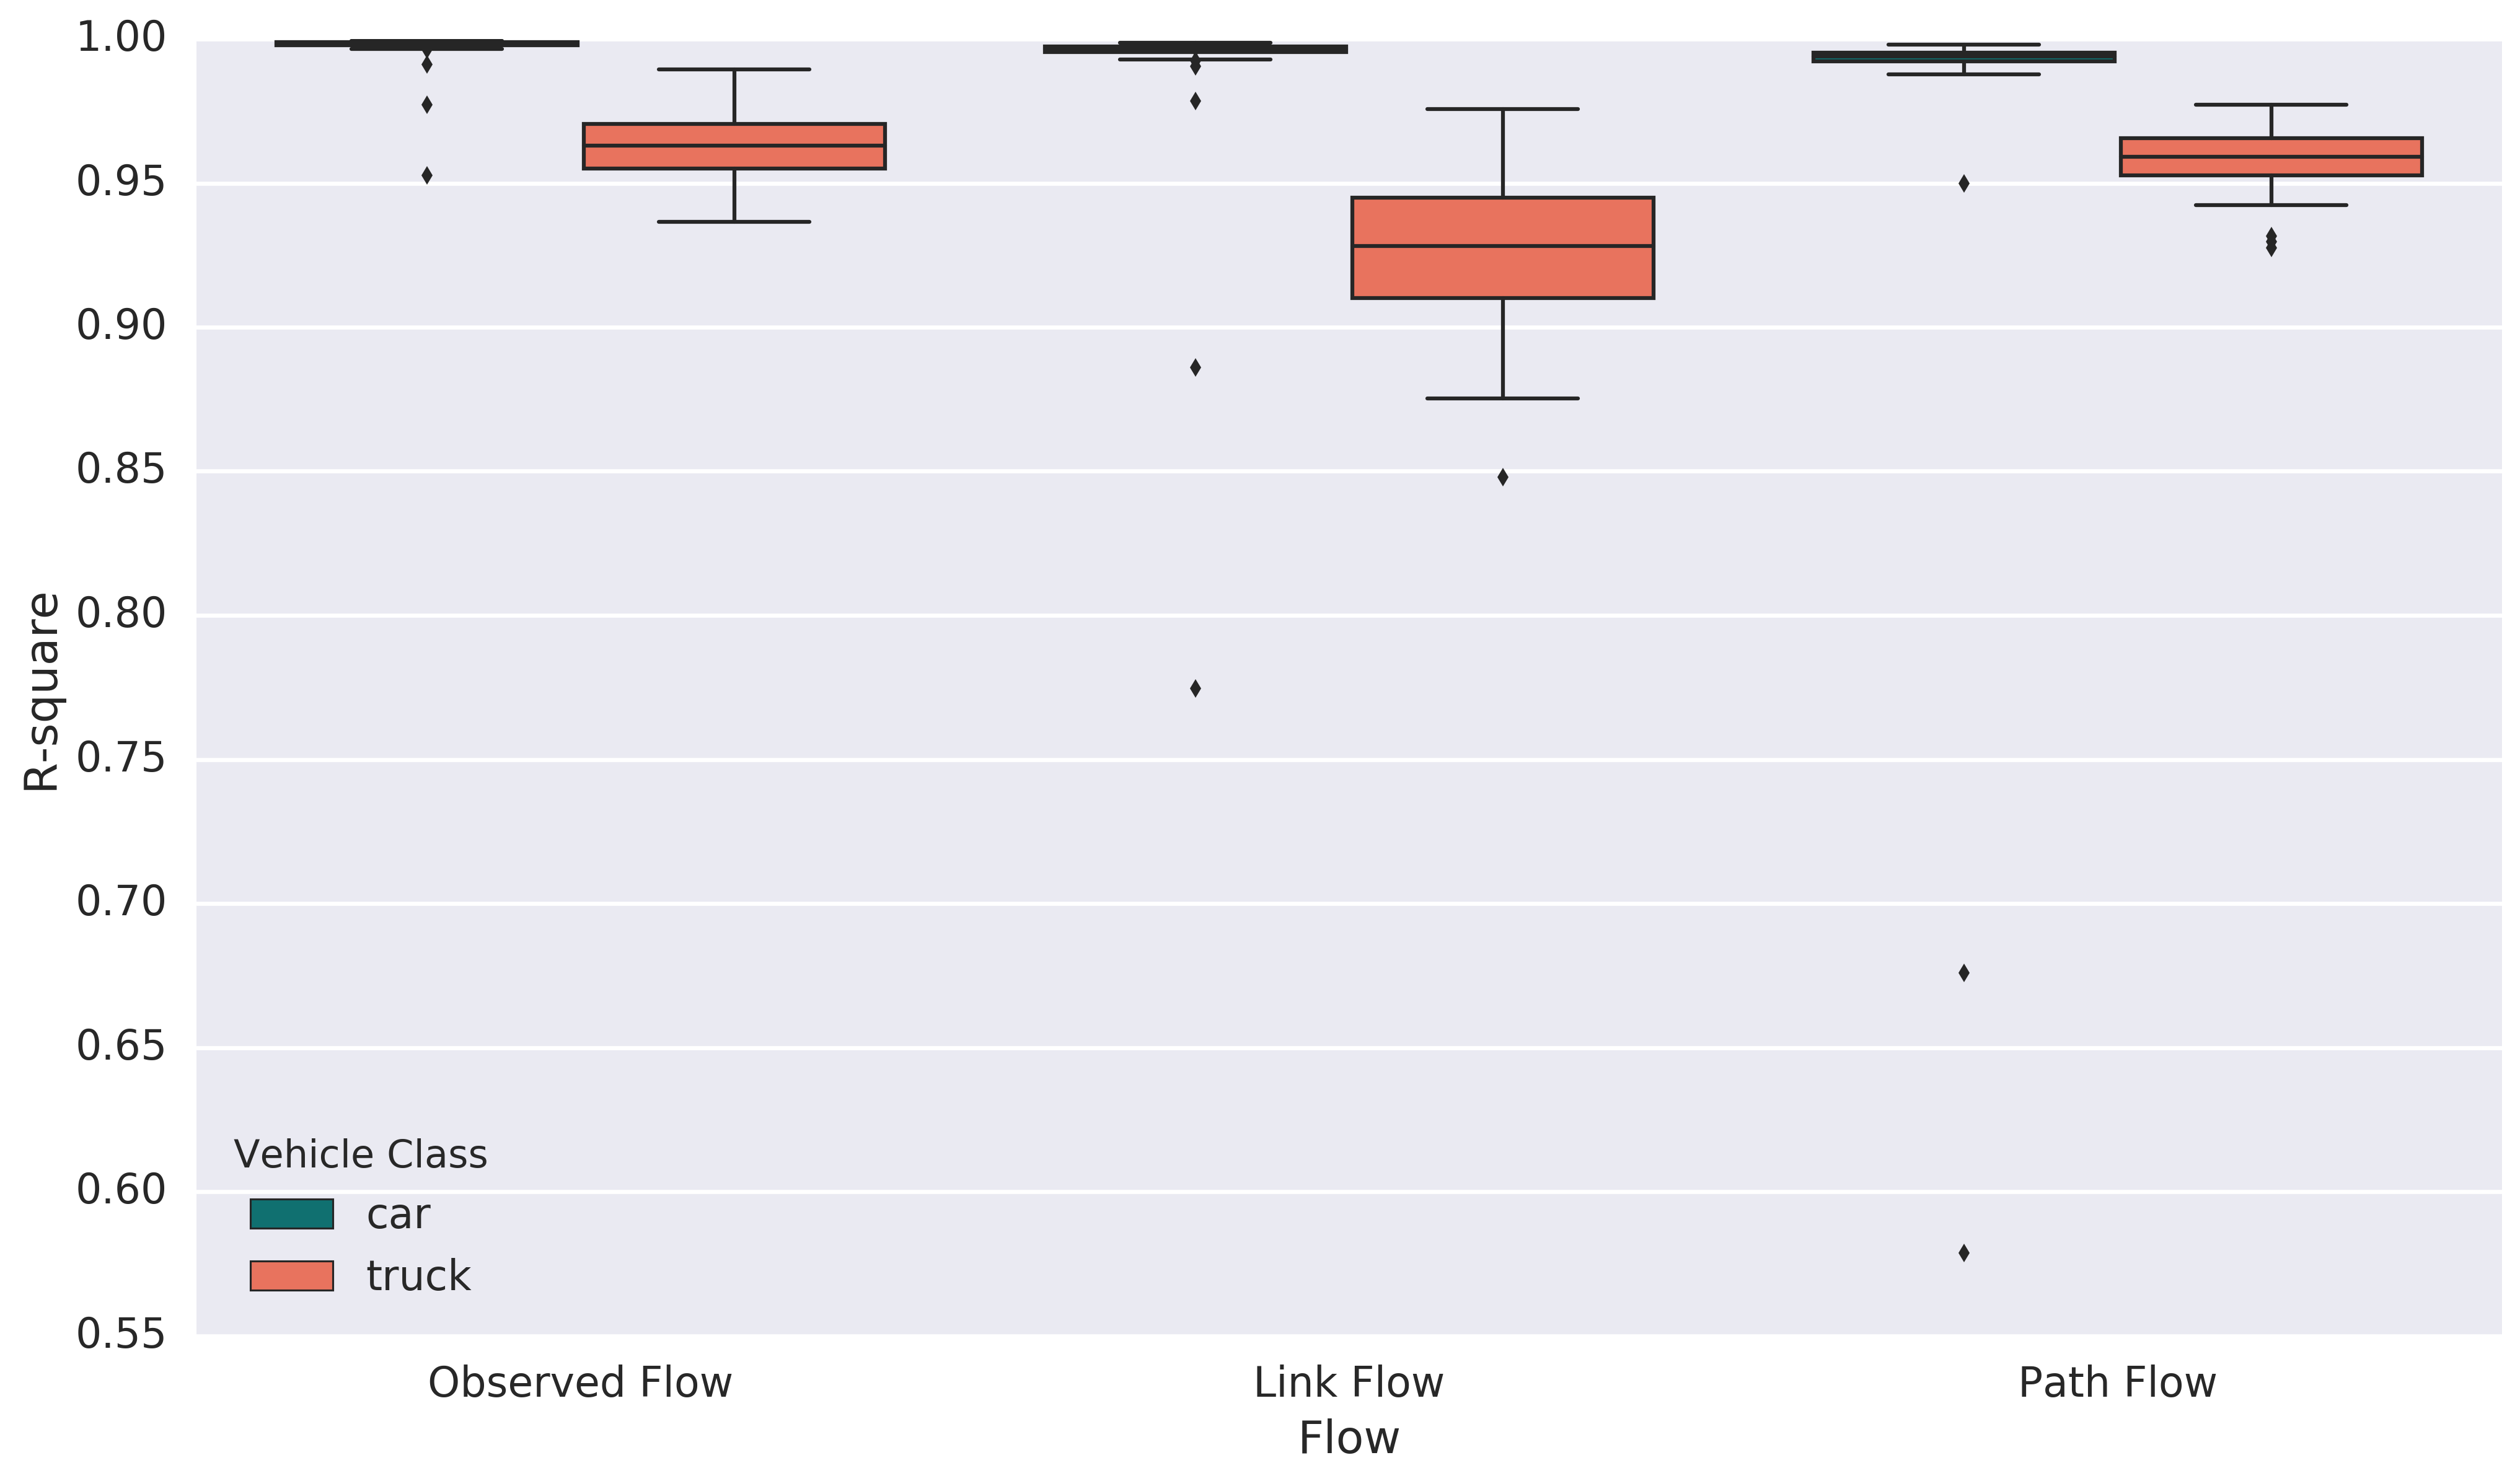

In [102]:
plt.figure(figsize = (16,9), dpi=300)
sns.boxplot(x="Flow", y="R-square", hue="Vehicle Class",
#                split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
            palette=["teal", "tomato"], linewidth=1.5, fliersize = 5,
               data=res2_rdf)
plt.show()

In [47]:
tips = sns.load_dataset("tips")

In [50]:
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

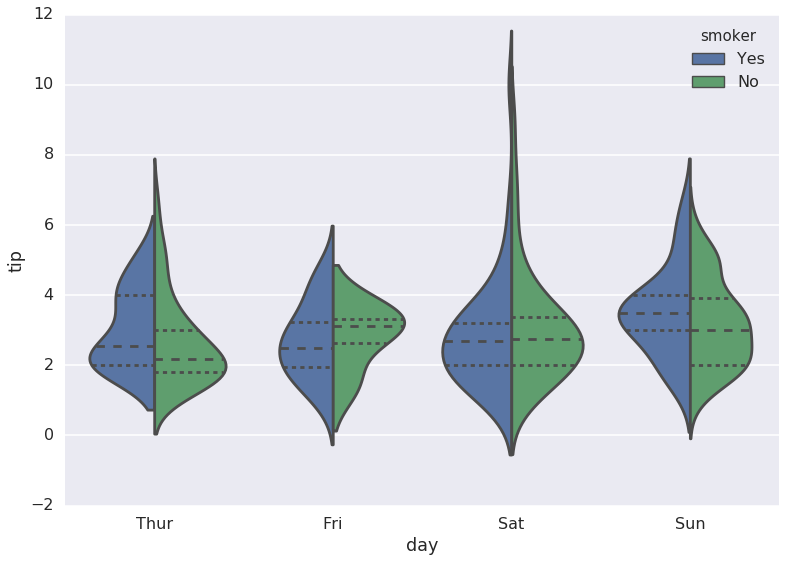

In [54]:
sns.violinplot(x="day", y="tip", hue="smoker",
               split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
               data=tips)